# An Word2Vec Based Encoder Approach to Entity Resolution

Hi Readers!

In this notebook, we take a look at exploring the **Entity Resolution** problem based on a Word2Vec based Encoder Approach. 

### Problem Statement

Given a corpus of text $C$, a set $R = \{ r \in C \}$ of resolutions for real world entities (such as the string "Donald Trump" for the real world person), and a set $E = \{ e \}$ of real world entities, create a function $F(r, C): R \rightarrow E$ to predict which entity a given resolution represnents.

For example, given a Fox News Article, create a funciton or algorithm that can determine the string "Donald Trump" represents the real world human president, and "Donald Duck" represents the cartoon character. A resolution such as "Donald" may map to either based on the corpus of text it is given (essentially dependent on context).

### Basic Imports, Nothing to fancy

In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import os

### Opening the articles in datatset
These are 100 different articles fron different news channels in their raw text form. We also get a labelled set of named resolutions and the entities they represent, based on an entity id. For example, we may be given a Fox News article on Donald Trump, as well as a dictionary mapping all of the entities in said articles, such as { "Donald" : 123, "Trump": 123, "Pelosi": 330 }, where 123 is the id for the real life person Donald Trump, and 330 is the id for the real life Senator Nancy Pelosi. These Ids will be used later.

## Note: All directories to files (```articles.json``` and ```named-resolutions.csv```) are HARD-CODED. Please change these directories to run your code with the file you have.

In [2]:
import json

with open('/kaggle/input/articles-json/articles (1).json') as f:
    articles = json.load(f)
articles
len(articles)

100

### Basic Text Preprocessing
Given an article, the ```parse_string``` method splits the articel by paragraph and sentence, removes all unnecessary characters (i.e dashes, exclamation points, @ symbols, etc. ), lemmatizes the document, and returns the new preprocessed article with sentences serarated by # and paragraphs separated by |.

Lemmatization is the process of finding the root word of any given word. For example, the lemma for "hates" is hate and the token for "processing" is "process".

In [3]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)
nlp = spacy.load('en', disable=['ner', 'parser'])
def parse_string(s):
    ## Replaces all sentence enders (question marks and exclamation points) with a period.
    s = s.replace('?', '.').replace('!', '.')
    ## Splits the article by paragraph and sentence and performs basic text processing, including removing al
    string = '|'.join(['#'.join([re.sub("[^A-Za-z']+", ' ', i).lower() for i in j.split('.')]) for j in s.split('\n')])
    trial  = nlp.pipe([string], batch_size=5000, n_threads=-1)
    # Cleans the document
    i = cleaning(next(trial))
    return i

Run ```parse_string``` on all the documents in the dataframe ```article```

In [4]:
for article in articles:
    article['content'] = parse_string(article['content'])

**This is what an article looks like after ```parse_string``` is run**

In [5]:
articles[0]['content']

"cool new broadway musical usually regard square slice american pie # answer arrive song daniel fish wide awake jolting altogether wonderful production rodger hammerstein oklahoma # open sunday night circle square theater#| oh beautiful mornin ' title opening line familiar number paean land promisingly blue sky open space # curly cowboy sing cushion expect lush orchestration # actor play usual solid slab beefcake strap tenor#|as embody excellent damon daunno lad prairie wiry wire unchanneled sexual energy expect implode # hint wobble cocky strut voice#|doe good project confidence entirely feel accompaniment home guitar palpably young # true big boy unsettled hormone read little dangerous#|he lot like feisty evolve nation proud belong # united states america now#|making broadway debut director mr # fish reconceive work see byword optimism mirror age doubt anxiety # oklahoma # era longstanding american legacy examine newly skeptical eyes#|such metamorphosis realize scarcely change word o

### Helper Methods

These are methods to help find a word given a paragraph, sentence, and article number. I don't think I ever actually use thme in this notebook, but they are useful to have.

```find_word``` returns the frist appearance of a given word in an article given its paragraph number and sentence number. ```find_nth``` is a helper method for ```find_word```

In [6]:
def find_nth(haystack, needle, n):
    if(n == 0):
        return 0
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start
def find_word(word, paragraph, sentence, article):
    if(word[-1] == 's'):
        word = word[:-1]
    if(sentence == -1):
        para_idx = find_nth(article, '|', paragraph-1)
        para_idx_next = find_nth(article, '|', paragraph)
        word_idx = article[para_idx:para_idx_next].find(word)
        return para_idx+word_idx
    para_idx = find_nth(article, '|', paragraph-1)
    sent_idx = find_nth(article[para_idx:], '#', sentence-1)
    sent_idx_next = find_nth(article[para_idx:], '#', sentence)
    word_idx = article[para_idx + sent_idx:para_idx + sent_idx_next].find(word)
    if(word_idx == -1):
        return -1
    else:
        return para_idx+sent_idx+word_idx

    

### The Labelled Named Resolutions

The dataframe ```words``` will be used extensively throughout this notebook, so make sure you understand what it is. The ```words``` dataframe contains a list of all named resolutions found by ```article_id``` as well as information on where in the article they were found. The ```entity_id``` is a unique id given to each real world entity. Thus, the resolutions "The United States of America" and "USA" will have the same ```entity_id```.

In [7]:
words = pd.read_csv('/kaggle/input/named-resolutions-march/named_resolution (1).csv')
words.head(12)

,id,article_id,model,name,type,entity_id,paragraph,sentence
0,27303856,331842,english.all.3class.distsim.crf.ser,Broadway,LOCATION,2551,1,1
1,27303857,331842,english.all.3class.distsim.crf.ser,Daniel Fish,PERSON,85567,1,2
2,27303858,331842,english.all.3class.distsim.crf.ser,Rodgers,PERSON,70833,1,2
3,27303859,331842,english.all.3class.distsim.crf.ser,Hammerstein,PERSON,98182,1,2
4,27303860,331842,english.all.3class.distsim.crf.ser,Oklahoma,LOCATION,1332,1,2
5,27303861,331842,english.all.3class.distsim.crf.ser,Square Theater,LOCATION,546338,1,2
6,27303863,331842,english.all.3class.distsim.crf.ser,Damon Daunno,PERSON,546335,3,1
7,27303865,331842,english.all.3class.distsim.crf.ser,United States of America,LOCATION,2882,5,2
8,27303869,331842,english.all.3class.distsim.crf.ser,Broadway,LOCATION,2551,6,1
9,27303870,331842,english.all.3class.distsim.crf.ser,Fish,PERSON,85567,6,2


# Starting Word2Vec Vecotirzation

Now, we will train a Word2Vec model on the 100 articles given to us in the ```articles``` dataframe. Here I load the articles in to a Pandas dataframe, drop all columns aside from the article itself, and drop all duplicate articles.

In [8]:
with open('/kaggle/input/articles-json/articles (1).json') as f:
    articles_temp = json.load(f)
articles_df = pd.DataFrame.from_dict(articles_temp)
articles_df = articles_df.drop(["title", "subtitle", "publish_date", "articleurl", "type", "media_id", "description",
                               "section", "comments", "sentiment_status", "ner_status"], axis = 1)
articles_df = articles_df.drop_duplicates().reset_index()
df = articles_df
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

index      0
id         0
content    0
dtype: int64

### A little redundancy

I inlcuded the lemmatiation function from earlier over here since we will reuse it in cleaning the articles for Word2Vec. We will reclean as done previously, but we will drop the sentence and paragraph structure that we kept previously. It does seem quite redundant, and honeslty, it is, since I dont really use the previously cleaned articles, but I am too lazy to delete that code, so I guess I will keep it :)

In [9]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [10]:
df

,index,id,content
0,0,331842,How is it that the coolest new show on Broadwa...
1,1,305370,"As you enter the theater, there are 163 men on..."
2,2,283956,Some plays are seeds and some are stones.\nSee...
3,3,320418,That was the way I felt during much of Sam Gol...
4,4,424546,Not signed up yet for Fox News First? Click he...
...,...,...,...
95,95,423142,White House counselor Kellyanne Conway pushed ...
96,96,423140,"A member of the ""Miracle on Ice"" 1980 Winter O..."
97,97,423290,Acting Homeland Security Secretary Kevin McAle...
98,98,423139,"Even a ""Super Space Genius"" can make a mistake..."


I reclean all the articles.

In [11]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['content'])

In [12]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=500, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.06 mins


In [13]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(100, 1)

* ### An overview of ```df_clean```

As of now, ```df_clean``` is the dataframe holding only the cleaned articles from the original dataset. The articles are cleaned by making everything lower case, removing all unnecesarry characters, and performing lemmatization, as previously stated.

In [14]:
df_clean

,clean
0,cool new broadway musical usually regard squar...
1,enter theater man onstage person battalion fra...
2,play seed stone seed one grow change course st...
3,way feel sam gold production king lear open th...
4,sign fox news click find miss fox news compile...
...,...
95,white house counselor kellyanne conway push mo...
96,member miracle ice winter olympics team hockey...
97,act homeland security secretary kevin mcaleena...
98,super space genius mistake spacex ceo elon mus...


## Training the Word2Vec Model
Now, once we have cleaned the articles, we can actually train a Word2Vec Model.
### Overview of Word2Vec
Word2Vec is a deep-learning based word embedding generator. The idea behind Word2Vec is to represent all words as $n$-dimensional vectors in some arbitrary vector space, where the vectors for these words are based on the context the words appear in. For example, if the word "Trump" appears commonly with the word "wall", the word embedding for "Trump" will numerically include the fact that it is relted to the word "wall" and so on.

With word embedding, one can, in a real sense, add, subtract, and multiply words, since they are part of a vector space. This allows for numerical calculations in something as abstract as natural language, which is very useful when using computers.
### Steps to training Word2Vec
* We will first train a Phraser, which determines common "phrases" such as "White House" or "United States of America". It considers these phrases to be one word
* We then give the articles, split by word (done by Word2Vec's Phraser) to the Word2Vec Model. It's that simple!

In [15]:
from gensim.models.phrases import Phrases, Phraser


Here we just split each article by word

In [16]:
sent = [row.split() for row in df_clean['clean']]
sent

[['cool',
  'new',
  'broadway',
  'musical',
  'usually',
  'regard',
  'square',
  'slice',
  'american',
  'pie',
  'answer',
  'arrive',
  'song',
  'daniel',
  'fish',
  'wide',
  'awake',
  'jolting',
  'altogether',
  'wonderful',
  'production',
  'rodger',
  'hammerstein',
  'oklahoma',
  'open',
  'sunday',
  'night',
  'circle',
  'square',
  'theater',
  'oh',
  'beautiful',
  'mornin',
  "'",
  'title',
  'opening',
  'line',
  'familiar',
  'number',
  'paean',
  'land',
  'promisingly',
  'blue',
  'sky',
  'open',
  'space',
  'curly',
  'cowboy',
  'sing',
  'cushion',
  'expect',
  'lush',
  'orchestration',
  'actor',
  'play',
  'usual',
  'solid',
  'slab',
  'beefcake',
  'strap',
  'tenor',
  'embody',
  'excellent',
  'damon',
  'daunno',
  'lad',
  'prairie',
  'wiry',
  'wire',
  'unchanneled',
  'sexual',
  'energy',
  'expect',
  'implode',
  'hint',
  'wobble',
  'cocky',
  'strut',
  'voice',
  'good',
  'project',
  'confidence',
  'entirely',
  'feel',
 

Here we find a dictionary of common phrases with their respective frequencies. As defined in the intiiation of the ```Phrases``` object, any phrase with a frequency less than 3 thorugh the copus of text will not be considered as a phrase.

In [17]:
phrases = Phrases(sent, min_count=3, progress_per=100)
phrases.vocab

defaultdict(int,
            {b'cool': 1,
             b'new': 77,
             b'cool_new': 1,
             b'broadway': 9,
             b'new_broadway': 1,
             b'musical': 3,
             b'broadway_musical': 1,
             b'usually': 5,
             b'musical_usually': 1,
             b'regard': 5,
             b'usually_regard': 1,
             b'square': 2,
             b'regard_square': 1,
             b'slice': 1,
             b'square_slice': 1,
             b'american': 38,
             b'slice_american': 1,
             b'pie': 2,
             b'american_pie': 1,
             b'answer': 11,
             b'pie_answer': 1,
             b'arrive': 12,
             b'answer_arrive': 1,
             b'song': 2,
             b'arrive_song': 1,
             b'daniel': 9,
             b'song_daniel': 1,
             b'fish': 9,
             b'daniel_fish': 1,
             b'wide': 3,
             b'fish_wide': 1,
             b'awake': 1,
             b'wide_awake': 1,
   

We create our new corpus of words (and phrases), split by word. From here on I will refer to words and phrases as tokesn.

In [18]:
bigram = Phraser(phrases)
sentences = bigram[sent]
sentences.corpus

[['cool',
  'new',
  'broadway',
  'musical',
  'usually',
  'regard',
  'square',
  'slice',
  'american',
  'pie',
  'answer',
  'arrive',
  'song',
  'daniel',
  'fish',
  'wide',
  'awake',
  'jolting',
  'altogether',
  'wonderful',
  'production',
  'rodger',
  'hammerstein',
  'oklahoma',
  'open',
  'sunday',
  'night',
  'circle',
  'square',
  'theater',
  'oh',
  'beautiful',
  'mornin',
  "'",
  'title',
  'opening',
  'line',
  'familiar',
  'number',
  'paean',
  'land',
  'promisingly',
  'blue',
  'sky',
  'open',
  'space',
  'curly',
  'cowboy',
  'sing',
  'cushion',
  'expect',
  'lush',
  'orchestration',
  'actor',
  'play',
  'usual',
  'solid',
  'slab',
  'beefcake',
  'strap',
  'tenor',
  'embody',
  'excellent',
  'damon',
  'daunno',
  'lad',
  'prairie',
  'wiry',
  'wire',
  'unchanneled',
  'sexual',
  'energy',
  'expect',
  'implode',
  'hint',
  'wobble',
  'cocky',
  'strut',
  'voice',
  'good',
  'project',
  'confidence',
  'entirely',
  'feel',
 

In [19]:
import multiprocessing

from gensim.models import Word2Vec

Checking how many CPU cores I have available

In [20]:
cores = multiprocessing.cpu_count() 

## The parameters:
* min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
* window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
* size = int - Dimensionality of the feature vectors. - (50, 300)
* sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
* alpha = float - The initial learning rate - (0.01, 0.05)
* min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
* negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
* workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [21]:
w2v_model = Word2Vec(min_count=2,
                     window=15,
                     size=250,
                     sample=6e-5, 
                     alpha=0.01, 
                     min_alpha=0.0002, 
                     negative=20,
                     workers=cores-1)

## Building the Vocabulary Table:
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [22]:
t = time()

w2v_model.build_vocab(sentences, progress_per=1000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.03 mins


## Train the model!

In [23]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=900, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 3.12 mins


### Here are the words most similar to "trump"
Remember, all words in the Word2Vec vocabulary are lower case as a result of our preprocessesing.

In [24]:
w2v_model.wv.most_similar(positive=["trump"], topn = 10)

[('president', 0.8237543702125549),
 ('critic', 0.6355081796646118),
 ('president_trump', 0.5808196663856506),
 ('comedian', 0.5697128176689148),
 ('illegal', 0.568647027015686),
 ('obvious', 0.5569486021995544),
 ('meme', 0.5534908771514893),
 ('donald', 0.5525747537612915),
 ('will', 0.5464908480644226),
 ('delay', 0.5301393866539001)]

### And here is the word embedding for "trump"

In [25]:
w2v_model["trump"]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.1833642 , -0.12371442,  0.9275798 ,  0.50007373,  1.0712602 ,
        0.1287047 , -0.6398266 , -0.5996975 , -0.0224344 , -0.08306679,
        0.4344267 , -0.64031565, -1.2879165 ,  0.17545569, -0.47776005,
        0.43974924, -0.22017252, -0.3594218 , -0.1218411 , -0.42055395,
        1.0131161 , -1.1695812 ,  0.05030508,  0.28367317,  0.13603593,
       -0.30271024, -0.322152  , -0.13126737,  0.1620915 , -0.79517883,
       -0.74711275,  0.72296673,  0.1478936 , -0.6803955 , -0.24417311,
        0.1679905 , -0.4927115 , -0.5540088 , -0.2565946 , -0.5628034 ,
        0.01486127, -0.8480397 , -0.5007735 , -0.33415094,  0.89611834,
       -0.5700327 , -0.5467823 ,  0.6404069 , -0.01398925, -0.1813088 ,
       -1.09895   ,  0.3564153 ,  0.46942762, -0.5901471 ,  0.76165587,
       -0.25253046,  0.26034966, -1.0990499 , -0.26632562, -0.6896291 ,
       -1.0522451 , -0.19184265,  0.28175917, -0.86365294,  0.15251288,
        0.94373524, -0.23323415,  0.3741841 , -0.19248182, -1.54

## Ended Wor2Vec Training.

## Starting ```word``` Dataset cleaning

## A reminder

I am sure following this notebook hasn't been too straightforward given my abismal variable names, but this is a reminder of the data we have. We had a dataframe called ```df_clean``` with a processed version of our articles. We also had a dataframe called ```words``` which contains the detected namer resolutions alongside their type and location in the corpus of text.

In [26]:
words.head(5)

,id,article_id,model,name,type,entity_id,paragraph,sentence
0,27303856,331842,english.all.3class.distsim.crf.ser,Broadway,LOCATION,2551,1,1
1,27303857,331842,english.all.3class.distsim.crf.ser,Daniel Fish,PERSON,85567,1,2
2,27303858,331842,english.all.3class.distsim.crf.ser,Rodgers,PERSON,70833,1,2
3,27303859,331842,english.all.3class.distsim.crf.ser,Hammerstein,PERSON,98182,1,2
4,27303860,331842,english.all.3class.distsim.crf.ser,Oklahoma,LOCATION,1332,1,2


## A weird but useful for-loop

Since each word in ```words``` has an entity-id, I create two dictionaries:
* ```id_frequency``` contains entity id's as keys and the frequency at which they show up in ```words``` as a value. For example, if Donald Trump's entity id is 123, and in the corpus of text "President" shows up 3 times, "Trump" shows up 5 times, and "Donal_trump" shows up 2 times, the value for key 123 would be 3+5+2 = 10.
* ```id_names``` contains entity id's as a key and the corresponding resolution list as a value. For example, using the previous example, entity 123 would have a value of ["Trump", "President", "Donald_trump"] 

In [27]:
id_frequency = {}
id_names = {}
for index, row in words.iterrows():
    if(row['entity_id'] in id_frequency):
        id_frequency[row['entity_id']] += 1
    else:
        id_frequency[row['entity_id']] = 1
    if(row['entity_id'] in id_names):
        if(not(row['name'] in id_names[row['entity_id']])):
            id_names[row['entity_id']].append(row['name'])
    else:
        id_names[row['entity_id']] = [row['name']]
id_frequency
id_names
    

{2551: ['Broadway'],
 85567: ['Daniel Fish', 'Fish'],
 70833: ['Rodgers'],
 98182: ['Hammerstein'],
 1332: ['Oklahoma'],
 546338: ['Square Theater'],
 546335: ['Damon Daunno'],
 2882: ['United States of America'],
 258700: ['Oscar Hammerstein II'],
 258711: ['Trevor Nunn'],
 272021: ['Susan Stroman'],
 217: ['London'],
 258703: ['Lynn Riggs'],
 709452: ['Laura Jellinek'],
 709453: ['Scott Zielinski'],
 709454: ['Daniel Kluger'],
 709455: ['Terese Wadden'],
 709456: ['Curly McLain'],
 709457: ['Laurey Williams'],
 546339: ['Rebecca Naomi Jones', 'Jones'],
 258696: ['Will Parker'],
 228062: ['James Davis', 'Davis'],
 258735: ['Ado Annie'],
 554733: ['Ali Stroker', 'Stroker'],
 258702: ['Aunt Eller'],
 696446: ['Mary Testa', 'Testa'],
 709458: ['Ali Hakim'],
 709459: ['Will Brill', 'Brill'],
 258707: ['Jud Fry', 'Jud'],
 709460: ['Patrick Vaill', 'Vaill'],
 258695: ['Laurey'],
 611047: ['John Heginbotham'],
 92610: ['Bard College'],
 13418: ["St. Ann 's Warehouse"],
 3445: ['Brooklyn'],
 

### Here I plot all the entities that show up more than 20 times in the corpus of text.

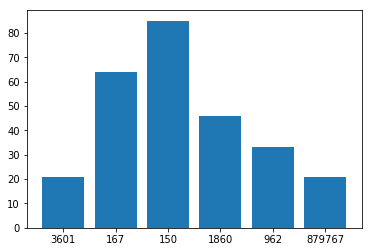

In [28]:
import matplotlib.pyplot as plt
i = id_frequency.items()
i = [(str(s[0]), s[1]) for s in i if s[1] > 20]
plt.bar(*zip(*i))
plt.show()

## Creating the Tensorflow Model!

After looking at the "Entity Resolutions" for Trump (i.e. the closest vectors to Trump's embedding), it is clear that Word2Vec doesn't work too well for entity resolution. Thus, we create a model that takes a token's word embedding as an input and spits out another word embedding for the same token. The idea is that we try to cluster embeddings for different tokens representing the entity as closely as possible to perform Entity Resolution.

### Model Architecture

A relatively vanilla artificial neural network. The Normalization is included because, well, why not! I will run further experimentation to see if it makes a difference. Things to notice:
* The input is of the same size as the word embedding (in theis case 300)
* The output is also the same size as the word embedding (in this case 300)


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import time
import sys

def make_model(size):
    temp = 1.5*size // 1
    model = Sequential()
    model.add(Dense(2*size, activation='relu', input_shape = (size,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(size, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(size, activation='relu'))
    return model

In [30]:
model = make_model(len(w2v_model["oklahoma"]))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


Using Stochastic Gradient Descent as an optimizer. This actually might make a difference in training, so experimentation with the optimizer to decrease the loss may be worthy of investigation

## The Loss function

We define our own loss function. Consider an entity $E$ with a resolution set of resolution word embeddings $R = \{r_k \}$. Our loss function takes one token, $r_i$ and computes $\sum_{m , m \neq i }^{k} 400 - f^2(r_i, r_m)$ where $f(x,y) = COS(x,y)$ is the cosine similarity function between two vectors. This gets each token more closely clustered to all other tokens representing the same entity.

#### Edit: Changed $f(x,y)$ from $COS(x,y)$ to $|x-y|$

### ```grad```

This is just gradient descent done by GradeintTape because I am not implementing gradient descent from scratch :).

In [31]:
loss_object = tf.keras.losses.CosineSimilarity()
def loss(x, y):
    l = []
    counter = tf.Variable(0)
    for i in range(len(x)):
        for j in y[i]:
            cos_sim = loss_object(y_pred = x[i], y_true = j)
            if(counter == 0):
                counter = tf.square(tf.norm(tf.subtract(x[i], j)))#tf.subtract(400, tf.multiply(400.,tf.square(cos_sim)))
            else:
                counter = counter + tf.square(tf.norm(tf.subtract(x[i], j)))#tf.subtract(400, tf.multiply(400.,tf.square(cos_sim)))
        l.append(counter)
        counter = tf.Variable(0)
    return l

def grad(inputs, targets):
    inputs = tf.convert_to_tensor(inputs)
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        inputs = model(inputs)
        loss_value = tf.convert_to_tensor(loss(inputs, targets))
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [32]:
print(id_frequency)
print(id_names)

{2551: 8, 85567: 4, 70833: 1, 98182: 1, 1332: 4, 546338: 1, 546335: 1, 2882: 1, 258700: 1, 258711: 1, 272021: 1, 217: 4, 258703: 1, 709452: 1, 709453: 1, 709454: 1, 709455: 1, 709456: 1, 709457: 1, 546339: 2, 258696: 1, 228062: 2, 258735: 2, 554733: 2, 258702: 1, 696446: 2, 709458: 2, 709459: 2, 258707: 4, 709460: 2, 258695: 2, 611047: 1, 92610: 1, 13418: 1, 3445: 2, 44347: 2, 22913: 1, 6302: 2, 6298: 1, 215218: 1, 546289: 14, 236247: 1, 244734: 1, 46712: 1, 546290: 2, 56097: 1, 546291: 2, 2594: 3, 546292: 3, 39813: 2, 393434: 1, 6533: 1, 1869: 2, 102357: 1, 6532: 2, 389: 2, 1061: 15, 1856: 17, 4112: 4, 6574: 6, 3601: 21, 8033: 3, 15212: 5, 4121: 1, 44065: 1, 18473: 1, 4000: 2, 10709: 1, 390: 5, 27562: 1, 15232: 2, 165: 5, 1063: 5, 167: 64, 3474: 2, 887092: 1, 2632: 6, 26206: 3, 79005: 1, 2040: 3, 1782: 7, 387: 15, 408: 1, 395: 1, 84259: 1, 84260: 1, 72031: 1, 32548: 1, 887093: 1, 3431: 5, 3607: 3, 3985: 1, 642615: 10, 255432: 1, 1328: 9, 1356: 1, 642616: 5, 2991: 1, 642618: 1, 642619:

Redoing Dataset Cleaning

### Getting data

While training, we will be pulling tokens from ```words``` and finding the word embeddings for all words that represent the same entity. Unfortunately, due to the preprocessing we did to help Word2Vec train, the tokens in ```words``` may not be in the Word2Vec model's vocabulary in the exact same fromat. For example, in ```words```, a token such as "Trump" would show up as "trump" in the Word2Vec vocab. Thus, we use a mixture of edit distance and general text processing to find the embedding for each token in ```words```,

```get_target_vecs``` returns the vectors for all tokens that represent the same entity as a given token, and ```fin_word_vec_in_vocab``` retuns the word embedding for a given token, or throws an error if it isnt found.

In [33]:
import nltk
def find_word_vec_in_vocab(word, w2v, solo = False):
    word = word.lower()
    if(word[-1] == 's' and not word[-2] in 'aeiou'):
        word = word[:-1]
    if(w2v.wv.__contains__(word)):
        return w2v[word]
    else:
        ret = 0
        mini = 3*len(word)
        for i in w2v.wv.vocab.keys():
            x = nltk.edit_distance(word.lower(), i.lower())
            if( x < mini):
                ret = w2v[i]
                mini = x
        if(mini/len(word) <= 0.3):
            return ret
        else:
            if(solo):
                print("Trying find word solo. The word doesn't exist: {}".format(word))
                raise ValueError("This word doesn't exist")
                return []
            return []
                
def get_target_vecs(word, word_id, w2v):
    words = id_names[word_id]
    print(words)
    if(len(words) <= 1):
        print("No extra words to train one. len of words is one : {}".format(word))
        raise ValueError("You have no matching entities upon which to train")
        return []
    else:
        ret = []
        for i in words:
            i = i.lower()
            x = find_word_vec_in_vocab(i, w2v)
            if( i != word and len(x) != 0):
                ret.append(x)
        if(len(ret) == 0):
            print("No mathcing entities to train upon: {}".format(word))
            raise ValueError("You have no matching entities upon which to train")
            return []
        return ret 

Here we create a dataset using the previous helper methods. ```x_array_global``` holds a tuple of the embedding for a token, and the list of embeddings for all tokens representing the same entity

In [34]:
x_array_global = []
c = 0
for index, row in words.iterrows():
    w = row["name"].lower()
    i = int(row["entity_id"])
    try:
        v = find_word_vec_in_vocab(w, w2v_model, solo = True), get_target_vecs(w, i, w2v_model )
        print(v)
        x_array_global.append(v)
    except:
        continue

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


['Broadway']
No extra words to train one. len of words is one : broadway
Trying find word solo. The word doesn't exist: daniel fish
Trying find word solo. The word doesn't exist: rodger
['Hammerstein']
No extra words to train one. len of words is one : hammerstein
['Oklahoma']
No extra words to train one. len of words is one : oklahoma
Trying find word solo. The word doesn't exist: square theater
Trying find word solo. The word doesn't exist: damon daunno
Trying find word solo. The word doesn't exist: united states of america
['Broadway']
No extra words to train one. len of words is one : broadway
['Daniel Fish', 'Fish']
No mathcing entities to train upon: fish
['Oklahoma']
No extra words to train one. len of words is one : oklahoma
Trying find word solo. The word doesn't exist: oscar hammerstein ii
['Daniel Fish', 'Fish']
No mathcing entities to train upon: fish
Trying find word solo. The word doesn't exist: trevor nunn
Trying find word solo. The word doesn't exist: susan stroman
['Lo

Trying find word solo. The word doesn't exist: american legion
['Heidi Schreck', 'Schreck', 'Heidi']
(array([ 0.51416504,  0.8718198 , -0.83871293,  1.4017708 , -0.96708995,
        1.2380024 , -0.97905296,  2.4776607 , -1.0445311 , -1.5878322 ,
        2.2614305 ,  0.90092987, -0.33546603, -1.7533325 ,  0.50275594,
        2.289036  ,  1.2126839 , -1.0385859 , -0.9209554 ,  0.23821865,
        0.22530746,  0.21526632,  0.7922856 ,  0.18516289,  1.7932646 ,
        1.1574519 ,  0.5426339 ,  0.8638225 ,  0.64970696, -1.1384513 ,
       -0.35659355,  1.5164487 ,  0.51136196, -0.64086556, -0.768486  ,
       -0.1619482 , -0.17416626, -0.70074284, -0.5934463 ,  1.30546   ,
       -0.00793694, -0.8460201 , -1.6368378 ,  0.36079565,  0.93875444,
       -2.3933978 , -0.24795501, -0.4661051 , -2.0190632 , -0.81728655,
       -1.0211954 , -0.29550958,  0.51512897, -0.68299496, -1.2089702 ,
        0.90096265,  1.6575347 ,  0.12978698,  0.23933786, -0.7097919 ,
       -0.811373  , -0.6902449 ,  

(array([ 0.51416504,  0.8718198 , -0.83871293,  1.4017708 , -0.96708995,
        1.2380024 , -0.97905296,  2.4776607 , -1.0445311 , -1.5878322 ,
        2.2614305 ,  0.90092987, -0.33546603, -1.7533325 ,  0.50275594,
        2.289036  ,  1.2126839 , -1.0385859 , -0.9209554 ,  0.23821865,
        0.22530746,  0.21526632,  0.7922856 ,  0.18516289,  1.7932646 ,
        1.1574519 ,  0.5426339 ,  0.8638225 ,  0.64970696, -1.1384513 ,
       -0.35659355,  1.5164487 ,  0.51136196, -0.64086556, -0.768486  ,
       -0.1619482 , -0.17416626, -0.70074284, -0.5934463 ,  1.30546   ,
       -0.00793694, -0.8460201 , -1.6368378 ,  0.36079565,  0.93875444,
       -2.3933978 , -0.24795501, -0.4661051 , -2.0190632 , -0.81728655,
       -1.0211954 , -0.29550958,  0.51512897, -0.68299496, -1.2089702 ,
        0.90096265,  1.6575347 ,  0.12978698,  0.23933786, -0.7097919 ,
       -0.811373  , -0.6902449 ,  0.6146216 , -2.04771   , -0.37395445,
       -0.16638218,  1.08713   , -0.8985423 , -0.7916873 ,  2.7

['Supreme Court']
No extra words to train one. len of words is one : supreme court
['Heidi Schreck', 'Schreck', 'Heidi']
(array([-9.4328070e-01, -6.8046337e-01,  5.7959324e-01,  3.3874978e-05,
        5.9667999e-01, -2.2719346e-01, -9.7182542e-01,  1.6054790e+00,
       -7.3170614e-01,  1.1610394e+00,  4.7637096e-01,  6.4966184e-01,
       -1.3462479e-01,  3.5015845e-01,  3.3260885e-01, -9.2277950e-01,
       -6.4751500e-01, -2.8648740e-01,  9.8148733e-01,  1.0342748e+00,
        3.9862406e-01, -1.4289448e+00,  1.9519821e-01,  8.0831003e-01,
       -7.9497540e-01, -1.0949760e-01,  7.6400399e-01, -1.1728102e+00,
       -4.0615311e-01, -3.3462358e-01,  3.1458423e-01, -5.1682204e-01,
       -3.6969505e-02, -4.1185957e-01, -1.9661213e-01,  1.8238159e-02,
        2.9607415e-01,  5.2222319e-02, -6.8075722e-01, -5.7213026e-01,
       -9.7507179e-01,  4.4009405e-01,  6.9369715e-01, -1.3916442e+00,
        1.1160225e+00,  1.3493626e+00, -3.5987446e-01,  1.0736276e-01,
        1.1928397e+00,  5.

['Heidi Schreck', 'Schreck', 'Heidi']
(array([-9.4328070e-01, -6.8046337e-01,  5.7959324e-01,  3.3874978e-05,
        5.9667999e-01, -2.2719346e-01, -9.7182542e-01,  1.6054790e+00,
       -7.3170614e-01,  1.1610394e+00,  4.7637096e-01,  6.4966184e-01,
       -1.3462479e-01,  3.5015845e-01,  3.3260885e-01, -9.2277950e-01,
       -6.4751500e-01, -2.8648740e-01,  9.8148733e-01,  1.0342748e+00,
        3.9862406e-01, -1.4289448e+00,  1.9519821e-01,  8.0831003e-01,
       -7.9497540e-01, -1.0949760e-01,  7.6400399e-01, -1.1728102e+00,
       -4.0615311e-01, -3.3462358e-01,  3.1458423e-01, -5.1682204e-01,
       -3.6969505e-02, -4.1185957e-01, -1.9661213e-01,  1.8238159e-02,
        2.9607415e-01,  5.2222319e-02, -6.8075722e-01, -5.7213026e-01,
       -9.7507179e-01,  4.4009405e-01,  6.9369715e-01, -1.3916442e+00,
        1.1160225e+00,  1.3493626e+00, -3.5987446e-01,  1.0736276e-01,
        1.1928397e+00,  5.3781700e-01, -9.2137027e-01,  4.8818254e-01,
       -5.3580338e-01,  4.9642220e-01,

['Heidi Schreck', 'Schreck', 'Heidi']
(array([-9.4328070e-01, -6.8046337e-01,  5.7959324e-01,  3.3874978e-05,
        5.9667999e-01, -2.2719346e-01, -9.7182542e-01,  1.6054790e+00,
       -7.3170614e-01,  1.1610394e+00,  4.7637096e-01,  6.4966184e-01,
       -1.3462479e-01,  3.5015845e-01,  3.3260885e-01, -9.2277950e-01,
       -6.4751500e-01, -2.8648740e-01,  9.8148733e-01,  1.0342748e+00,
        3.9862406e-01, -1.4289448e+00,  1.9519821e-01,  8.0831003e-01,
       -7.9497540e-01, -1.0949760e-01,  7.6400399e-01, -1.1728102e+00,
       -4.0615311e-01, -3.3462358e-01,  3.1458423e-01, -5.1682204e-01,
       -3.6969505e-02, -4.1185957e-01, -1.9661213e-01,  1.8238159e-02,
        2.9607415e-01,  5.2222319e-02, -6.8075722e-01, -5.7213026e-01,
       -9.7507179e-01,  4.4009405e-01,  6.9369715e-01, -1.3916442e+00,
        1.1160225e+00,  1.3493626e+00, -3.5987446e-01,  1.0736276e-01,
        1.1928397e+00,  5.3781700e-01, -9.2137027e-01,  4.8818254e-01,
       -5.3580338e-01,  4.9642220e-01,

(array([-9.4328070e-01, -6.8046337e-01,  5.7959324e-01,  3.3874978e-05,
        5.9667999e-01, -2.2719346e-01, -9.7182542e-01,  1.6054790e+00,
       -7.3170614e-01,  1.1610394e+00,  4.7637096e-01,  6.4966184e-01,
       -1.3462479e-01,  3.5015845e-01,  3.3260885e-01, -9.2277950e-01,
       -6.4751500e-01, -2.8648740e-01,  9.8148733e-01,  1.0342748e+00,
        3.9862406e-01, -1.4289448e+00,  1.9519821e-01,  8.0831003e-01,
       -7.9497540e-01, -1.0949760e-01,  7.6400399e-01, -1.1728102e+00,
       -4.0615311e-01, -3.3462358e-01,  3.1458423e-01, -5.1682204e-01,
       -3.6969505e-02, -4.1185957e-01, -1.9661213e-01,  1.8238159e-02,
        2.9607415e-01,  5.2222319e-02, -6.8075722e-01, -5.7213026e-01,
       -9.7507179e-01,  4.4009405e-01,  6.9369715e-01, -1.3916442e+00,
        1.1160225e+00,  1.3493626e+00, -3.5987446e-01,  1.0736276e-01,
        1.1928397e+00,  5.3781700e-01, -9.2137027e-01,  4.8818254e-01,
       -5.3580338e-01,  4.9642220e-01, -3.9461818e-01,  1.6969296e+00,
     

Trying find word solo. The word doesn't exist: rosdely ciprian
['Williams']
No extra words to train one. len of words is one : williams
['Rosdely Ciprian', 'Ciprian']
No mathcing entities to train upon: ciprian
['Heidi Schreck', 'Schreck', 'Heidi']
(array([-9.4328070e-01, -6.8046337e-01,  5.7959324e-01,  3.3874978e-05,
        5.9667999e-01, -2.2719346e-01, -9.7182542e-01,  1.6054790e+00,
       -7.3170614e-01,  1.1610394e+00,  4.7637096e-01,  6.4966184e-01,
       -1.3462479e-01,  3.5015845e-01,  3.3260885e-01, -9.2277950e-01,
       -6.4751500e-01, -2.8648740e-01,  9.8148733e-01,  1.0342748e+00,
        3.9862406e-01, -1.4289448e+00,  1.9519821e-01,  8.0831003e-01,
       -7.9497540e-01, -1.0949760e-01,  7.6400399e-01, -1.1728102e+00,
       -4.0615311e-01, -3.3462358e-01,  3.1458423e-01, -5.1682204e-01,
       -3.6969505e-02, -4.1185957e-01, -1.9661213e-01,  1.8238159e-02,
        2.9607415e-01,  5.2222319e-02, -6.8075722e-01, -5.7213026e-01,
       -9.7507179e-01,  4.4009405e-01,  

['Heidi Schreck', 'Schreck', 'Heidi']
(array([-9.4328070e-01, -6.8046337e-01,  5.7959324e-01,  3.3874978e-05,
        5.9667999e-01, -2.2719346e-01, -9.7182542e-01,  1.6054790e+00,
       -7.3170614e-01,  1.1610394e+00,  4.7637096e-01,  6.4966184e-01,
       -1.3462479e-01,  3.5015845e-01,  3.3260885e-01, -9.2277950e-01,
       -6.4751500e-01, -2.8648740e-01,  9.8148733e-01,  1.0342748e+00,
        3.9862406e-01, -1.4289448e+00,  1.9519821e-01,  8.0831003e-01,
       -7.9497540e-01, -1.0949760e-01,  7.6400399e-01, -1.1728102e+00,
       -4.0615311e-01, -3.3462358e-01,  3.1458423e-01, -5.1682204e-01,
       -3.6969505e-02, -4.1185957e-01, -1.9661213e-01,  1.8238159e-02,
        2.9607415e-01,  5.2222319e-02, -6.8075722e-01, -5.7213026e-01,
       -9.7507179e-01,  4.4009405e-01,  6.9369715e-01, -1.3916442e+00,
        1.1160225e+00,  1.3493626e+00, -3.5987446e-01,  1.0736276e-01,
        1.1928397e+00,  5.3781700e-01, -9.2137027e-01,  4.8818254e-01,
       -5.3580338e-01,  4.9642220e-01,

Trying find word solo. The word doesn't exist: lisa kron
['Heidi Schreck', 'Schreck', 'Heidi']
(array([-9.4328070e-01, -6.8046337e-01,  5.7959324e-01,  3.3874978e-05,
        5.9667999e-01, -2.2719346e-01, -9.7182542e-01,  1.6054790e+00,
       -7.3170614e-01,  1.1610394e+00,  4.7637096e-01,  6.4966184e-01,
       -1.3462479e-01,  3.5015845e-01,  3.3260885e-01, -9.2277950e-01,
       -6.4751500e-01, -2.8648740e-01,  9.8148733e-01,  1.0342748e+00,
        3.9862406e-01, -1.4289448e+00,  1.9519821e-01,  8.0831003e-01,
       -7.9497540e-01, -1.0949760e-01,  7.6400399e-01, -1.1728102e+00,
       -4.0615311e-01, -3.3462358e-01,  3.1458423e-01, -5.1682204e-01,
       -3.6969505e-02, -4.1185957e-01, -1.9661213e-01,  1.8238159e-02,
        2.9607415e-01,  5.2222319e-02, -6.8075722e-01, -5.7213026e-01,
       -9.7507179e-01,  4.4009405e-01,  6.9369715e-01, -1.3916442e+00,
        1.1160225e+00,  1.3493626e+00, -3.5987446e-01,  1.0736276e-01,
        1.1928397e+00,  5.3781700e-01, -9.2137027e-0

(array([-9.4328070e-01, -6.8046337e-01,  5.7959324e-01,  3.3874978e-05,
        5.9667999e-01, -2.2719346e-01, -9.7182542e-01,  1.6054790e+00,
       -7.3170614e-01,  1.1610394e+00,  4.7637096e-01,  6.4966184e-01,
       -1.3462479e-01,  3.5015845e-01,  3.3260885e-01, -9.2277950e-01,
       -6.4751500e-01, -2.8648740e-01,  9.8148733e-01,  1.0342748e+00,
        3.9862406e-01, -1.4289448e+00,  1.9519821e-01,  8.0831003e-01,
       -7.9497540e-01, -1.0949760e-01,  7.6400399e-01, -1.1728102e+00,
       -4.0615311e-01, -3.3462358e-01,  3.1458423e-01, -5.1682204e-01,
       -3.6969505e-02, -4.1185957e-01, -1.9661213e-01,  1.8238159e-02,
        2.9607415e-01,  5.2222319e-02, -6.8075722e-01, -5.7213026e-01,
       -9.7507179e-01,  4.4009405e-01,  6.9369715e-01, -1.3916442e+00,
        1.1160225e+00,  1.3493626e+00, -3.5987446e-01,  1.0736276e-01,
        1.1928397e+00,  5.3781700e-01, -9.2137027e-01,  4.8818254e-01,
       -5.3580338e-01,  4.9642220e-01, -3.9461818e-01,  1.6969296e+00,
     

Trying find word solo. The word doesn't exist: zion williamson
['NBA']
No extra words to train one. len of words is one : nba
Trying find word solo. The word doesn't exist: capitol hill
['White House', 'House']
(array([ 2.12789327e-01, -2.22054943e-01,  1.08135867e+00,  1.55806720e-01,
        6.76050246e-01, -2.42242590e-01, -2.75828481e-01, -5.05443454e-01,
        3.67691010e-01, -1.51720852e-01, -8.75865638e-01,  1.47061422e-01,
       -3.37817818e-01,  4.95225728e-01, -7.85633862e-01, -3.42777461e-01,
       -7.47485101e-01, -6.56280577e-01, -5.55358589e-01, -1.97251290e-01,
        5.19378960e-01, -1.41394258e+00, -3.01574886e-01,  3.55599314e-01,
       -6.62146509e-01, -6.46321535e-01, -8.59527171e-01,  5.39175451e-01,
        9.43929911e-01, -4.76096898e-01,  3.79027873e-01, -1.70172796e-01,
        1.03191659e-01,  9.32434574e-04, -4.64898497e-01,  1.26947299e-01,
        4.76759553e-01, -5.03929198e-01, -1.21119946e-01, -3.02856535e-01,
       -3.01821917e-01, -6.91583872e-0

Trying find word solo. The word doesn't exist: mick mulvaney
['Treasury']
No extra words to train one. len of words is one : treasury
Trying find word solo. The word doesn't exist: steve mnuchin
['White House', 'House']
(array([ 0.27940524,  0.31519303,  1.2843759 , -0.09914962, -0.6121919 ,
        0.4483851 ,  0.45730022, -0.64983684, -0.07393523, -0.12951618,
        0.26214892, -0.01097321, -0.21268135, -0.29192793,  0.26088098,
        0.65712804, -0.16703823, -0.08667757,  0.20439549, -0.2466218 ,
        0.26130232,  0.04205801, -0.99225235, -0.7207697 , -0.34781313,
       -0.08153843, -0.21022797, -0.2923867 ,  0.57048094, -0.4328534 ,
        0.32066616,  0.07514253, -0.38397136,  0.3810519 , -0.5308769 ,
       -0.21839263,  0.55381334,  0.01939484,  0.19029126,  0.03386541,
        0.58430254,  0.11103334, -0.04738739, -0.47015506, -0.07469957,
       -0.27933246, -0.17755754,  0.2520987 ,  0.04995398,  0.4757599 ,
       -0.24034967, -0.6526207 ,  0.04749589, -1.490137  , 

['Nancy Pelosi', 'Pelosi', 'Nancy']
(array([ 1.47662133e-01, -1.12136900e+00,  3.03297997e+00, -6.18289948e-01,
       -3.02290946e-01,  3.61723192e-02, -1.02988672e+00, -3.40973228e-01,
        4.51238275e-01, -6.58415854e-01, -3.47465664e-01,  2.73276955e-01,
       -1.20429242e+00, -1.02236934e-01, -8.70052725e-02,  3.41846310e-02,
       -1.19566154e+00, -1.32948673e+00,  4.78481442e-01, -1.00055851e-01,
       -1.67401537e-01, -3.54986899e-02,  7.30026126e-01, -5.93973882e-02,
        2.21603677e-01, -9.92265940e-01, -1.66705692e+00,  3.69247824e-01,
       -5.78369200e-02, -2.95200944e-01,  9.99083459e-01,  2.69737720e-01,
        4.67386633e-01,  7.62637258e-01, -1.15578127e+00,  1.66079089e-01,
        2.84365088e-01, -7.35780820e-02, -7.03865528e-01, -6.62917733e-01,
       -3.77380550e-01,  4.16527003e-01, -6.96677387e-01, -1.15650713e+00,
       -2.44889438e-01, -9.69376266e-01, -8.24636698e-01,  1.41151989e+00,
        1.83448839e+00,  2.99171954e-01,  2.91072130e-01, -1.17

['D-Calif.']
No extra words to train one. len of words is one : d-calif.
Trying find word solo. The word doesn't exist: senate appropriations committee
Trying find word solo. The word doesn't exist: richard shelby
Trying find word solo. The word doesn't exist: r-ala.
['White House', 'House']
(array([ 0.27940524,  0.31519303,  1.2843759 , -0.09914962, -0.6121919 ,
        0.4483851 ,  0.45730022, -0.64983684, -0.07393523, -0.12951618,
        0.26214892, -0.01097321, -0.21268135, -0.29192793,  0.26088098,
        0.65712804, -0.16703823, -0.08667757,  0.20439549, -0.2466218 ,
        0.26130232,  0.04205801, -0.99225235, -0.7207697 , -0.34781313,
       -0.08153843, -0.21022797, -0.2923867 ,  0.57048094, -0.4328534 ,
        0.32066616,  0.07514253, -0.38397136,  0.3810519 , -0.5308769 ,
       -0.21839263,  0.55381334,  0.01939484,  0.19029126,  0.03386541,
        0.58430254,  0.11103334, -0.04738739, -0.47015506, -0.07469957,
       -0.27933246, -0.17755754,  0.2520987 ,  0.04995398,

Trying find word solo. The word doesn't exist: kevin mccarthy
Trying find word solo. The word doesn't exist: r-calif.
Trying find word solo. The word doesn't exist: lindsey graham
['Mick Mulvaney', 'Mulvaney']
No mathcing entities to train upon: mulvaney
['Steve Mnuchin', 'Mnuchin']
No mathcing entities to train upon: mnuchin
['Senate Appropriations Committee', 'Senate']
No mathcing entities to train upon: senate
Trying find word solo. The word doesn't exist: mitch mcconnell
Trying find word solo. The word doesn't exist: r-ky.
['Mitch McConnell', 'McConnell']
No mathcing entities to train upon: mcconnell
['Capitol']
No extra words to train one. len of words is one : capitol
['Washington']
No extra words to train one. len of words is one : washington
['Mitch McConnell', 'McConnell']
No mathcing entities to train upon: mcconnell
['White House']
No extra words to train one. len of words is one : white house
['Trump']
No extra words to train one. len of words is one : trump
['Trump']
No ex

(array([ 0.27940524,  0.31519303,  1.2843759 , -0.09914962, -0.6121919 ,
        0.4483851 ,  0.45730022, -0.64983684, -0.07393523, -0.12951618,
        0.26214892, -0.01097321, -0.21268135, -0.29192793,  0.26088098,
        0.65712804, -0.16703823, -0.08667757,  0.20439549, -0.2466218 ,
        0.26130232,  0.04205801, -0.99225235, -0.7207697 , -0.34781313,
       -0.08153843, -0.21022797, -0.2923867 ,  0.57048094, -0.4328534 ,
        0.32066616,  0.07514253, -0.38397136,  0.3810519 , -0.5308769 ,
       -0.21839263,  0.55381334,  0.01939484,  0.19029126,  0.03386541,
        0.58430254,  0.11103334, -0.04738739, -0.47015506, -0.07469957,
       -0.27933246, -0.17755754,  0.2520987 ,  0.04995398,  0.4757599 ,
       -0.24034967, -0.6526207 ,  0.04749589, -1.490137  ,  0.42586526,
       -1.1022371 ,  0.05954753,  1.2070293 , -0.5296079 ,  0.52163935,
       -0.3427625 , -0.5164464 , -0.33557102,  0.12083548, -0.3459775 ,
        0.8284014 , -0.3287491 ,  0.29162344, -0.52809787,  0.0

['Trump Administration']
No extra words to train one. len of words is one : trump administration
['Steve Mnuchin', 'Mnuchin']
No mathcing entities to train upon: mnuchin
Trying find word solo. The word doesn't exist: speaker 's office
['Steve Mnuchin', 'Mnuchin']
No mathcing entities to train upon: mnuchin
['Mick Mulvaney', 'Mulvaney']
No mathcing entities to train upon: mulvaney
['Nancy Pelosi', 'Pelosi', 'Nancy']
(array([-0.2940673 ,  0.02244466,  1.2432065 ,  0.48294428, -0.03677355,
        0.82215595, -0.11097884,  0.4514168 , -0.322735  , -1.4061826 ,
        0.13575086,  0.82955587, -0.46733665, -0.37492162, -0.7861161 ,
        0.05023443, -2.1564214 ,  0.09207118,  1.3927155 ,  0.7870799 ,
        0.4019534 , -1.1969445 , -1.2821171 ,  0.09954532, -0.01788393,
       -0.8305761 , -0.37863195,  0.04199637, -0.02616932, -1.1780958 ,
        1.81063   ,  0.27910116,  0.92453665,  0.285882  , -1.4279557 ,
        0.18032627,  1.374423  ,  0.40685996, -0.5333787 , -1.3135716 ,
    

(array([-0.2940673 ,  0.02244466,  1.2432065 ,  0.48294428, -0.03677355,
        0.82215595, -0.11097884,  0.4514168 , -0.322735  , -1.4061826 ,
        0.13575086,  0.82955587, -0.46733665, -0.37492162, -0.7861161 ,
        0.05023443, -2.1564214 ,  0.09207118,  1.3927155 ,  0.7870799 ,
        0.4019534 , -1.1969445 , -1.2821171 ,  0.09954532, -0.01788393,
       -0.8305761 , -0.37863195,  0.04199637, -0.02616932, -1.1780958 ,
        1.81063   ,  0.27910116,  0.92453665,  0.285882  , -1.4279557 ,
        0.18032627,  1.374423  ,  0.40685996, -0.5333787 , -1.3135716 ,
        0.6610947 ,  0.08410453, -0.7377379 , -1.3460269 , -0.44144124,
       -2.3101342 , -1.6357476 ,  1.8674071 ,  1.3240772 ,  1.5601542 ,
       -0.04006297, -0.47688147,  1.2300518 , -1.1559532 ,  0.8134849 ,
        0.18046224, -0.04994197,  0.06383017, -0.76661456,  0.75889707,
       -1.1886231 ,  0.42888287, -0.47082525, -0.06590103, -0.18108939,
        1.2659005 , -0.69570625,  2.3078852 ,  0.032504  , -0.9

(array([-0.2940673 ,  0.02244466,  1.2432065 ,  0.48294428, -0.03677355,
        0.82215595, -0.11097884,  0.4514168 , -0.322735  , -1.4061826 ,
        0.13575086,  0.82955587, -0.46733665, -0.37492162, -0.7861161 ,
        0.05023443, -2.1564214 ,  0.09207118,  1.3927155 ,  0.7870799 ,
        0.4019534 , -1.1969445 , -1.2821171 ,  0.09954532, -0.01788393,
       -0.8305761 , -0.37863195,  0.04199637, -0.02616932, -1.1780958 ,
        1.81063   ,  0.27910116,  0.92453665,  0.285882  , -1.4279557 ,
        0.18032627,  1.374423  ,  0.40685996, -0.5333787 , -1.3135716 ,
        0.6610947 ,  0.08410453, -0.7377379 , -1.3460269 , -0.44144124,
       -2.3101342 , -1.6357476 ,  1.8674071 ,  1.3240772 ,  1.5601542 ,
       -0.04006297, -0.47688147,  1.2300518 , -1.1559532 ,  0.8134849 ,
        0.18046224, -0.04994197,  0.06383017, -0.76661456,  0.75889707,
       -1.1886231 ,  0.42888287, -0.47082525, -0.06590103, -0.18108939,
        1.2659005 , -0.69570625,  2.3078852 ,  0.032504  , -0.9

No mathcing entities to train upon: mulvaney
Trying find word solo. The word doesn't exist: mick mulvaney
['Nancy Pelosi', 'Pelosi', 'Nancy']
(array([-0.2940673 ,  0.02244466,  1.2432065 ,  0.48294428, -0.03677355,
        0.82215595, -0.11097884,  0.4514168 , -0.322735  , -1.4061826 ,
        0.13575086,  0.82955587, -0.46733665, -0.37492162, -0.7861161 ,
        0.05023443, -2.1564214 ,  0.09207118,  1.3927155 ,  0.7870799 ,
        0.4019534 , -1.1969445 , -1.2821171 ,  0.09954532, -0.01788393,
       -0.8305761 , -0.37863195,  0.04199637, -0.02616932, -1.1780958 ,
        1.81063   ,  0.27910116,  0.92453665,  0.285882  , -1.4279557 ,
        0.18032627,  1.374423  ,  0.40685996, -0.5333787 , -1.3135716 ,
        0.6610947 ,  0.08410453, -0.7377379 , -1.3460269 , -0.44144124,
       -2.3101342 , -1.6357476 ,  1.8674071 ,  1.3240772 ,  1.5601542 ,
       -0.04006297, -0.47688147,  1.2300518 , -1.1559532 ,  0.8134849 ,
        0.18046224, -0.04994197,  0.06383017, -0.76661456,  0.758

No mathcing entities to train upon: mulvaney
['South Carolina', 'S.C.']
No mathcing entities to train upon: south carolina
['Mick Mulvaney', 'Mulvaney']
No mathcing entities to train upon: mulvaney
['Mick Mulvaney', 'Mulvaney']
No mathcing entities to train upon: mulvaney
['Nancy Pelosi', 'Pelosi', 'Nancy']
(array([-0.2940673 ,  0.02244466,  1.2432065 ,  0.48294428, -0.03677355,
        0.82215595, -0.11097884,  0.4514168 , -0.322735  , -1.4061826 ,
        0.13575086,  0.82955587, -0.46733665, -0.37492162, -0.7861161 ,
        0.05023443, -2.1564214 ,  0.09207118,  1.3927155 ,  0.7870799 ,
        0.4019534 , -1.1969445 , -1.2821171 ,  0.09954532, -0.01788393,
       -0.8305761 , -0.37863195,  0.04199637, -0.02616932, -1.1780958 ,
        1.81063   ,  0.27910116,  0.92453665,  0.285882  , -1.4279557 ,
        0.18032627,  1.374423  ,  0.40685996, -0.5333787 , -1.3135716 ,
        0.6610947 ,  0.08410453, -0.7377379 , -1.3460269 , -0.44144124,
       -2.3101342 , -1.6357476 ,  1.867407

No mathcing entities to train upon: mulvaney
['White House', 'House']
(array([ 0.27940524,  0.31519303,  1.2843759 , -0.09914962, -0.6121919 ,
        0.4483851 ,  0.45730022, -0.64983684, -0.07393523, -0.12951618,
        0.26214892, -0.01097321, -0.21268135, -0.29192793,  0.26088098,
        0.65712804, -0.16703823, -0.08667757,  0.20439549, -0.2466218 ,
        0.26130232,  0.04205801, -0.99225235, -0.7207697 , -0.34781313,
       -0.08153843, -0.21022797, -0.2923867 ,  0.57048094, -0.4328534 ,
        0.32066616,  0.07514253, -0.38397136,  0.3810519 , -0.5308769 ,
       -0.21839263,  0.55381334,  0.01939484,  0.19029126,  0.03386541,
        0.58430254,  0.11103334, -0.04738739, -0.47015506, -0.07469957,
       -0.27933246, -0.17755754,  0.2520987 ,  0.04995398,  0.4757599 ,
       -0.24034967, -0.6526207 ,  0.04749589, -1.490137  ,  0.42586526,
       -1.1022371 ,  0.05954753,  1.2070293 , -0.5296079 ,  0.52163935,
       -0.3427625 , -0.5164464 , -0.33557102,  0.12083548, -0.345

Trying find word solo. The word doesn't exist: steny hoyer
Trying find word solo. The word doesn't exist: d-md
['Fox']
No extra words to train one. len of words is one : fox
['Mick Mulvaney', 'Mulvaney']
No mathcing entities to train upon: mulvaney
['Steve Mnuchin', 'Mnuchin']
No mathcing entities to train upon: mnuchin
['Mick Mulvaney', 'Mulvaney']
No mathcing entities to train upon: mulvaney
['White House']
No extra words to train one. len of words is one : white house
['Mick Mulvaney', 'Mulvaney']
No mathcing entities to train upon: mulvaney
['Pentagon']
No extra words to train one. len of words is one : pentagon
['Congress']
No extra words to train one. len of words is one : congress
['Trump']
No extra words to train one. len of words is one : trump
['Mick Mulvaney', 'Mulvaney']
No mathcing entities to train upon: mulvaney
Trying find word solo. The word doesn't exist: capitol hill
['Mick Mulvaney', 'Mulvaney']
No mathcing entities to train upon: mulvaney
['Mick Mulvaney', 'Mulvane

Trying find word solo. The word doesn't exist: house budget committee
Trying find word solo. The word doesn't exist: john yarmuth
Trying find word solo. The word doesn't exist: d-ky.
['Nancy Pelosi', 'Pelosi', 'Nancy']
(array([-0.2940673 ,  0.02244466,  1.2432065 ,  0.48294428, -0.03677355,
        0.82215595, -0.11097884,  0.4514168 , -0.322735  , -1.4061826 ,
        0.13575086,  0.82955587, -0.46733665, -0.37492162, -0.7861161 ,
        0.05023443, -2.1564214 ,  0.09207118,  1.3927155 ,  0.7870799 ,
        0.4019534 , -1.1969445 , -1.2821171 ,  0.09954532, -0.01788393,
       -0.8305761 , -0.37863195,  0.04199637, -0.02616932, -1.1780958 ,
        1.81063   ,  0.27910116,  0.92453665,  0.285882  , -1.4279557 ,
        0.18032627,  1.374423  ,  0.40685996, -0.5333787 , -1.3135716 ,
        0.6610947 ,  0.08410453, -0.7377379 , -1.3460269 , -0.44144124,
       -2.3101342 , -1.6357476 ,  1.8674071 ,  1.3240772 ,  1.5601542 ,
       -0.04006297, -0.47688147,  1.2300518 , -1.1559532 ,  

No mathcing entities to train upon: hoyer
['Mick Mulvaney', 'Mulvaney']
No mathcing entities to train upon: mulvaney
['Pentagon']
No extra words to train one. len of words is one : pentagon
['Steny Hoyer', 'Hoyer']
No mathcing entities to train upon: hoyer
['Mick Mulvaney', 'Mulvaney']
No mathcing entities to train upon: mulvaney
['Congress']
No extra words to train one. len of words is one : congress
['Obama Administration']
No extra words to train one. len of words is one : obama administration
['White House', 'House']
(array([ 2.12789327e-01, -2.22054943e-01,  1.08135867e+00,  1.55806720e-01,
        6.76050246e-01, -2.42242590e-01, -2.75828481e-01, -5.05443454e-01,
        3.67691010e-01, -1.51720852e-01, -8.75865638e-01,  1.47061422e-01,
       -3.37817818e-01,  4.95225728e-01, -7.85633862e-01, -3.42777461e-01,
       -7.47485101e-01, -6.56280577e-01, -5.55358589e-01, -1.97251290e-01,
        5.19378960e-01, -1.41394258e+00, -3.01574886e-01,  3.55599314e-01,
       -6.62146509e-01

Trying find word solo. The word doesn't exist: eric ueland
['Senate Appropriations Committee', 'Senate']
No mathcing entities to train upon: senate
['Senate Appropriations Committee', 'Senate']
No mathcing entities to train upon: senate
['White House', 'House']
(array([ 0.27940524,  0.31519303,  1.2843759 , -0.09914962, -0.6121919 ,
        0.4483851 ,  0.45730022, -0.64983684, -0.07393523, -0.12951618,
        0.26214892, -0.01097321, -0.21268135, -0.29192793,  0.26088098,
        0.65712804, -0.16703823, -0.08667757,  0.20439549, -0.2466218 ,
        0.26130232,  0.04205801, -0.99225235, -0.7207697 , -0.34781313,
       -0.08153843, -0.21022797, -0.2923867 ,  0.57048094, -0.4328534 ,
        0.32066616,  0.07514253, -0.38397136,  0.3810519 , -0.5308769 ,
       -0.21839263,  0.55381334,  0.01939484,  0.19029126,  0.03386541,
        0.58430254,  0.11103334, -0.04738739, -0.47015506, -0.07469957,
       -0.27933246, -0.17755754,  0.2520987 ,  0.04995398,  0.4757599 ,
       -0.2403496

['White House']
No extra words to train one. len of words is one : white house
['Pentagon']
No extra words to train one. len of words is one : pentagon
['Mitch McConnell', 'McConnell']
No mathcing entities to train upon: mcconnell
['Washington']
No extra words to train one. len of words is one : washington
Trying find word solo. The word doesn't exist: maddie corman
Trying find word solo. The word doesn't exist: corman
['Brooklyn']
No extra words to train one. len of words is one : brooklyn
Trying find word solo. The word doesn't exist: dobbs ferry
Trying find word solo. The word doesn't exist: n.y.
['Dad']
No extra words to train one. len of words is one : dad
Trying find word solo. The word doesn't exist: jace alexander
['Jace Alexander', 'Alexander']
No mathcing entities to train upon: alexander
Trying find word solo. The word doesn't exist: npr
Trying find word solo. The word doesn't exist: corman
['Jace Alexander', 'Alexander']
No mathcing entities to train upon: alexander
Trying 

Trying find word solo. The word doesn't exist: jayne houdyshell
Trying find word solo. The word doesn't exist: john douglas thompson
['Glenda Jackson', 'Jackson']
No mathcing entities to train upon: jackson
['Lear']
No extra words to train one. len of words is one : lear
['Glenda Jackson', 'Jackson']
No mathcing entities to train upon: jackson
['Glenda Jackson', 'Jackson']
No mathcing entities to train upon: jackson
['London']
No extra words to train one. len of words is one : london
Trying find word solo. The word doesn't exist: vic
Trying find word solo. The word doesn't exist: british parliament
['Glenda Jackson', 'Jackson']
No mathcing entities to train upon: jackson
['Broadway']
No extra words to train one. len of words is one : broadway
['Lear']
No extra words to train one. len of words is one : lear
Trying find word solo. The word doesn't exist: edward albee
['N.Y.', 'New York']
No mathcing entities to train upon: new york
['Lears', 'Lear']
(array([-0.652832  ,  1.3450341 ,  0.0

No mathcing entities to train upon: jackson
Trying find word solo. The word doesn't exist: cordelia
['Ruth Wilson', 'Wilson']
No mathcing entities to train upon: wilson
['Goneril']
No extra words to train one. len of words is one : goneril
['Regan']
No extra words to train one. len of words is one : regan
['Elizabeth Marvel', 'Marvel']
(array([ 0.15020336, -0.13211828,  0.5124758 ,  1.6162355 ,  1.4102588 ,
        1.3450569 ,  1.1922644 ,  0.7030003 ,  0.08446632,  0.63105303,
        1.0194741 ,  0.04830324,  1.9244655 ,  0.8210008 , -0.5376315 ,
        0.43558583,  0.6957379 , -0.15301354, -1.1806976 ,  0.32600805,
        0.70873153, -1.0326393 ,  1.1905967 , -0.3780225 ,  0.6372356 ,
        0.96660936, -0.6555546 , -0.30229163, -1.4865668 ,  0.07931295,
        0.2641515 ,  0.9550859 ,  1.7246634 , -0.5225389 , -0.9776347 ,
        0.29377657,  1.2089312 , -0.85710526,  0.785765  ,  1.0215855 ,
       -0.03616133,  0.04885154,  0.05825021, -1.3110849 , -1.049594  ,
       -0.178

Trying find word solo. The word doesn't exist: aisling o'sullivan
['Lears', 'Lear']
(array([-0.652832  ,  1.3450341 ,  0.05194101,  0.08515842, -0.46759537,
        0.6847068 , -0.38138673, -0.3123476 , -0.659128  , -1.3925644 ,
       -0.9400806 ,  0.40558207, -1.3295403 , -2.3864849 ,  1.0934525 ,
        1.4437209 ,  1.5516267 ,  1.1013778 , -1.2213655 ,  0.53553164,
       -0.16084565,  0.34476474, -0.06636779,  1.103321  ,  0.91119695,
        0.01564507, -0.08543748, -0.19804153,  2.3529875 , -1.3741438 ,
       -0.3222893 , -0.6697251 , -0.9367377 ,  1.2239085 , -1.601992  ,
       -2.0799131 ,  0.6859662 , -1.5039498 , -0.39722317, -0.38843986,
       -0.4292857 ,  1.3834454 , -0.7235767 , -1.7803597 ,  0.70795953,
       -1.9074233 , -0.9589819 , -1.195733  , -0.68679243, -0.50758064,
       -0.09889456,  0.9420952 ,  0.6943834 ,  0.23240206, -0.83195734,
        0.3374961 ,  1.7091355 ,  0.3949242 ,  0.49055797,  0.2041401 ,
       -1.5758238 , -1.0049307 , -0.4122504 , -0.14

No mathcing entities to train upon: jackson
['Lears', 'Lear']
(array([-0.652832  ,  1.3450341 ,  0.05194101,  0.08515842, -0.46759537,
        0.6847068 , -0.38138673, -0.3123476 , -0.659128  , -1.3925644 ,
       -0.9400806 ,  0.40558207, -1.3295403 , -2.3864849 ,  1.0934525 ,
        1.4437209 ,  1.5516267 ,  1.1013778 , -1.2213655 ,  0.53553164,
       -0.16084565,  0.34476474, -0.06636779,  1.103321  ,  0.91119695,
        0.01564507, -0.08543748, -0.19804153,  2.3529875 , -1.3741438 ,
       -0.3222893 , -0.6697251 , -0.9367377 ,  1.2239085 , -1.601992  ,
       -2.0799131 ,  0.6859662 , -1.5039498 , -0.39722317, -0.38843986,
       -0.4292857 ,  1.3834454 , -0.7235767 , -1.7803597 ,  0.70795953,
       -1.9074233 , -0.9589819 , -1.195733  , -0.68679243, -0.50758064,
       -0.09889456,  0.9420952 ,  0.6943834 ,  0.23240206, -0.83195734,
        0.3374961 ,  1.7091355 ,  0.3949242 ,  0.49055797,  0.2041401 ,
       -1.5758238 , -1.0049307 , -0.4122504 , -0.14560743, -1.1302185 ,
 

Trying find word solo. The word doesn't exist: sean carvajal
Trying find word solo. The word doesn't exist: edgar
['Glenda Jackson', 'Jackson']
No mathcing entities to train upon: jackson
['Sam Gold', 'Gold']
No mathcing entities to train upon: gold
['Shakespeare']
No extra words to train one. len of words is one : shakespeare
['N.Y.', 'New York']
No mathcing entities to train upon: new york
Trying find word solo. The word doesn't exist: daniel craig
Trying find word solo. The word doesn't exist: david oyelowo
Trying find word solo. The word doesn't exist: oscar isaac
['Broadway']
No extra words to train one. len of words is one : broadway
['Sam Gold', 'Gold']
No mathcing entities to train upon: gold
['Sam Gold', 'Gold']
No mathcing entities to train upon: gold
['Regan']
No extra words to train one. len of words is one : regan
Trying find word solo. The word doesn't exist: duke of cornwall
Trying find word solo. The word doesn't exist: russell harvard
['Cornwall']
No extra words to tra

Trying find word solo. The word doesn't exist: ann roth
['Ruth Wilson', 'Wilson']
No mathcing entities to train upon: wilson
['Ruth Wilson', 'Wilson']
No mathcing entities to train upon: wilson
['John Douglas Thompson', 'Thompson']
No mathcing entities to train upon: thompson
['Jayne Houdyshell', 'Houdyshell']
No mathcing entities to train upon: houdyshell
Trying find word solo. The word doesn't exist: gloucester
Trying find word solo. The word doesn't exist: pedro pascal
Trying find word solo. The word doesn't exist: edmund
['Elizabeth Marvel', 'Marvel']
(array([-3.61072160e-02,  3.71474773e-02, -7.38700926e-01,  5.88292122e-01,
        5.15739441e-01, -4.25771296e-01,  4.13984954e-01,  4.25287127e-01,
       -1.02564240e+00, -8.03205669e-01, -1.39582014e+00,  5.37856221e-01,
        2.69800812e-01,  4.88159806e-01,  1.68439038e-02,  1.97452709e-01,
        3.44806999e-01,  5.80513358e-01, -6.26766086e-01,  5.06802142e-01,
        3.11054677e-01,  2.07659364e-01,  7.26392210e-01,  8.6

No mathcing entities to train upon: o'sullivan
['Regan']
No extra words to train one. len of words is one : regan
['Lears', 'Lear']
(array([-0.652832  ,  1.3450341 ,  0.05194101,  0.08515842, -0.46759537,
        0.6847068 , -0.38138673, -0.3123476 , -0.659128  , -1.3925644 ,
       -0.9400806 ,  0.40558207, -1.3295403 , -2.3864849 ,  1.0934525 ,
        1.4437209 ,  1.5516267 ,  1.1013778 , -1.2213655 ,  0.53553164,
       -0.16084565,  0.34476474, -0.06636779,  1.103321  ,  0.91119695,
        0.01564507, -0.08543748, -0.19804153,  2.3529875 , -1.3741438 ,
       -0.3222893 , -0.6697251 , -0.9367377 ,  1.2239085 , -1.601992  ,
       -2.0799131 ,  0.6859662 , -1.5039498 , -0.39722317, -0.38843986,
       -0.4292857 ,  1.3834454 , -0.7235767 , -1.7803597 ,  0.70795953,
       -1.9074233 , -0.9589819 , -1.195733  , -0.68679243, -0.50758064,
       -0.09889456,  0.9420952 ,  0.6943834 ,  0.23240206, -0.83195734,
        0.3374961 ,  1.7091355 ,  0.3949242 ,  0.49055797,  0.2041401 ,
   

['McCombe']
No extra words to train one. len of words is one : mccombe
['Jackson']
No extra words to train one. len of words is one : jackson
['Britain']
No extra words to train one. len of words is one : britain
Trying find word solo. The word doesn't exist: u.s.
Trying find word solo. The word doesn't exist: john keenan
['Paisley']
No extra words to train one. len of words is one : paisley
Trying find word solo. The word doesn't exist: catholic news agency
Trying find word solo. The word doesn't exist: john sherrington
['Westminster']
No extra words to train one. len of words is one : westminster
Trying find word solo. The word doesn't exist: nathalie lieven
Trying find word solo. The word doesn't exist: san diego
['Navy']
No extra words to train one. len of words is one : navy
Trying find word solo. The word doesn't exist: eddie gallagher
['ISIS']
No extra words to train one. len of words is one : isis
Trying find word solo. The word doesn't exist: frank sheridan
['Navy']
No extra w

No mathcing entities to train upon: ingraham
['Nancy Pelosi', 'Pelosi', 'Nancy']
(array([-0.2940673 ,  0.02244466,  1.2432065 ,  0.48294428, -0.03677355,
        0.82215595, -0.11097884,  0.4514168 , -0.322735  , -1.4061826 ,
        0.13575086,  0.82955587, -0.46733665, -0.37492162, -0.7861161 ,
        0.05023443, -2.1564214 ,  0.09207118,  1.3927155 ,  0.7870799 ,
        0.4019534 , -1.1969445 , -1.2821171 ,  0.09954532, -0.01788393,
       -0.8305761 , -0.37863195,  0.04199637, -0.02616932, -1.1780958 ,
        1.81063   ,  0.27910116,  0.92453665,  0.285882  , -1.4279557 ,
        0.18032627,  1.374423  ,  0.40685996, -0.5333787 , -1.3135716 ,
        0.6610947 ,  0.08410453, -0.7377379 , -1.3460269 , -0.44144124,
       -2.3101342 , -1.6357476 ,  1.8674071 ,  1.3240772 ,  1.5601542 ,
       -0.04006297, -0.47688147,  1.2300518 , -1.1559532 ,  0.8134849 ,
        0.18046224, -0.04994197,  0.06383017, -0.76661456,  0.75889707,
       -1.1886231 ,  0.42888287, -0.47082525, -0.06590

(array([-0.2940673 ,  0.02244466,  1.2432065 ,  0.48294428, -0.03677355,
        0.82215595, -0.11097884,  0.4514168 , -0.322735  , -1.4061826 ,
        0.13575086,  0.82955587, -0.46733665, -0.37492162, -0.7861161 ,
        0.05023443, -2.1564214 ,  0.09207118,  1.3927155 ,  0.7870799 ,
        0.4019534 , -1.1969445 , -1.2821171 ,  0.09954532, -0.01788393,
       -0.8305761 , -0.37863195,  0.04199637, -0.02616932, -1.1780958 ,
        1.81063   ,  0.27910116,  0.92453665,  0.285882  , -1.4279557 ,
        0.18032627,  1.374423  ,  0.40685996, -0.5333787 , -1.3135716 ,
        0.6610947 ,  0.08410453, -0.7377379 , -1.3460269 , -0.44144124,
       -2.3101342 , -1.6357476 ,  1.8674071 ,  1.3240772 ,  1.5601542 ,
       -0.04006297, -0.47688147,  1.2300518 , -1.1559532 ,  0.8134849 ,
        0.18046224, -0.04994197,  0.06383017, -0.76661456,  0.75889707,
       -1.1886231 ,  0.42888287, -0.47082525, -0.06590103, -0.18108939,
        1.2659005 , -0.69570625,  2.3078852 ,  0.032504  , -0.9

['N.Y.', 'New York']
No mathcing entities to train upon: new york
['Laura Ingraham', 'Ingraham']
No mathcing entities to train upon: ingraham
['Nancy Pelosi', 'Pelosi', 'Nancy']
(array([-0.2940673 ,  0.02244466,  1.2432065 ,  0.48294428, -0.03677355,
        0.82215595, -0.11097884,  0.4514168 , -0.322735  , -1.4061826 ,
        0.13575086,  0.82955587, -0.46733665, -0.37492162, -0.7861161 ,
        0.05023443, -2.1564214 ,  0.09207118,  1.3927155 ,  0.7870799 ,
        0.4019534 , -1.1969445 , -1.2821171 ,  0.09954532, -0.01788393,
       -0.8305761 , -0.37863195,  0.04199637, -0.02616932, -1.1780958 ,
        1.81063   ,  0.27910116,  0.92453665,  0.285882  , -1.4279557 ,
        0.18032627,  1.374423  ,  0.40685996, -0.5333787 , -1.3135716 ,
        0.6610947 ,  0.08410453, -0.7377379 , -1.3460269 , -0.44144124,
       -2.3101342 , -1.6357476 ,  1.8674071 ,  1.3240772 ,  1.5601542 ,
       -0.04006297, -0.47688147,  1.2300518 , -1.1559532 ,  0.8134849 ,
        0.18046224, -0.049941

Trying find word solo. The word doesn't exist: san francisco
['Nancy Pelosi', 'Pelosi', 'Nancy']
(array([-7.25260913e-01, -5.91438234e-01, -7.01815426e-01,  8.25100780e-01,
       -1.80441096e-01,  1.03235769e+00, -2.59839535e-01, -1.01105869e-01,
       -9.00666118e-01,  6.31613016e-01, -1.05168171e-01, -5.47355376e-02,
       -9.27998126e-03, -4.64094758e-01,  7.91548133e-01,  6.51825666e-01,
       -1.02636576e+00, -2.14634800e+00,  2.00500056e-01, -6.76267982e-01,
       -6.07683301e-01, -2.22114593e-01, -2.08051816e-01, -6.92157686e-01,
       -6.95540488e-01, -1.58402339e-01, -7.95890093e-01, -5.72541118e-01,
        5.22471607e-01, -8.27103734e-01, -8.63601565e-01,  2.52083749e-01,
        1.27600133e-01, -5.79266250e-01, -2.39731357e-01, -2.89799720e-01,
        8.83407772e-01, -1.46580338e-01, -2.61712998e-01,  8.79899114e-02,
       -7.24589169e-01,  4.31181788e-01, -3.99261624e-01,  6.94853008e-01,
        3.86194617e-01, -4.28795397e-01, -5.85447192e-01, -2.31140349e-02,
  

Trying find word solo. The word doesn't exist: san francisco
['Laura Ingraham', 'Ingraham']
No mathcing entities to train upon: ingraham
['Laura Ingraham', 'Ingraham']
No mathcing entities to train upon: ingraham
['Obama']
No extra words to train one. len of words is one : obama
['Trump']
No extra words to train one. len of words is one : trump
Trying find word solo. The word doesn't exist: ingram
['Obama']
No extra words to train one. len of words is one : obama
['Obama']
No extra words to train one. len of words is one : obama
Trying find word solo. The word doesn't exist: abc new
['Laura Ingraham', 'Ingraham']
No mathcing entities to train upon: ingraham
['Nancy Pelosi', 'Pelosi', 'Nancy']
(array([-0.2940673 ,  0.02244466,  1.2432065 ,  0.48294428, -0.03677355,
        0.82215595, -0.11097884,  0.4514168 , -0.322735  , -1.4061826 ,
        0.13575086,  0.82955587, -0.46733665, -0.37492162, -0.7861161 ,
        0.05023443, -2.1564214 ,  0.09207118,  1.3927155 ,  0.7870799 ,
        0

['Nancy Pelosi', 'Pelosi', 'Nancy']
(array([ 1.47662133e-01, -1.12136900e+00,  3.03297997e+00, -6.18289948e-01,
       -3.02290946e-01,  3.61723192e-02, -1.02988672e+00, -3.40973228e-01,
        4.51238275e-01, -6.58415854e-01, -3.47465664e-01,  2.73276955e-01,
       -1.20429242e+00, -1.02236934e-01, -8.70052725e-02,  3.41846310e-02,
       -1.19566154e+00, -1.32948673e+00,  4.78481442e-01, -1.00055851e-01,
       -1.67401537e-01, -3.54986899e-02,  7.30026126e-01, -5.93973882e-02,
        2.21603677e-01, -9.92265940e-01, -1.66705692e+00,  3.69247824e-01,
       -5.78369200e-02, -2.95200944e-01,  9.99083459e-01,  2.69737720e-01,
        4.67386633e-01,  7.62637258e-01, -1.15578127e+00,  1.66079089e-01,
        2.84365088e-01, -7.35780820e-02, -7.03865528e-01, -6.62917733e-01,
       -3.77380550e-01,  4.16527003e-01, -6.96677387e-01, -1.15650713e+00,
       -2.44889438e-01, -9.69376266e-01, -8.24636698e-01,  1.41151989e+00,
        1.83448839e+00,  2.99171954e-01,  2.91072130e-01, -1.17

No mathcing entities to train upon: ingraham
['Fresno']
No extra words to train one. len of words is one : fresno
Trying find word solo. The word doesn't exist: fayth percy
Trying find word solo. The word doesn't exist: fresno police
Trying find word solo. The word doesn't exist: jerry dyer
['Fresno']
No extra words to train one. len of words is one : fresno
Trying find word solo. The word doesn't exist: marco antonio echartea
['Jerry Dyer', 'Dyer']
No mathcing entities to train upon: dyer
['Fresno']
No extra words to train one. len of words is one : fresno
['CNN']
No extra words to train one. len of words is one : cnn
Trying find word solo. The word doesn't exist: fareed zakaria
['Trump']
No extra words to train one. len of words is one : trump
['Iran']
No extra words to train one. len of words is one : iran
['White House', 'House']
(array([ 2.12789327e-01, -2.22054943e-01,  1.08135867e+00,  1.55806720e-01,
        6.76050246e-01, -2.42242590e-01, -2.75828481e-01, -5.05443454e-01,
   

Trying find word solo. The word doesn't exist: ayatollah ali khamenei
['Fareed Zakaria', 'Zakaria']
No mathcing entities to train upon: zakaria
['Trump']
No extra words to train one. len of words is one : trump
['Iran']
No extra words to train one. len of words is one : iran
['Fareed Zakaria', 'Zakaria']
No mathcing entities to train upon: zakaria
['Iran']
No extra words to train one. len of words is one : iran
['Iran']
No extra words to train one. len of words is one : iran
['CNN']
No extra words to train one. len of words is one : cnn
['Iran']
No extra words to train one. len of words is one : iran
['White House', 'House']
(array([ 2.12789327e-01, -2.22054943e-01,  1.08135867e+00,  1.55806720e-01,
        6.76050246e-01, -2.42242590e-01, -2.75828481e-01, -5.05443454e-01,
        3.67691010e-01, -1.51720852e-01, -8.75865638e-01,  1.47061422e-01,
       -3.37817818e-01,  4.95225728e-01, -7.85633862e-01, -3.42777461e-01,
       -7.47485101e-01, -6.56280577e-01, -5.55358589e-01, -1.97251

Trying find word solo. The word doesn't exist: trivea jones
Trying find word solo. The word doesn't exist: aurora
['Illinois', 'Ill.']
(array([-9.96576667e-01, -3.34787607e-01,  1.96035072e-01, -5.26599586e-01,
       -6.41844988e-01, -9.33727801e-01, -1.25640243e-01, -1.48149025e+00,
        6.85285568e-01, -2.88187563e-01, -8.26060236e-01, -3.77658516e-01,
       -1.07156539e+00, -1.22430694e+00,  9.22845125e-01, -3.53562802e-01,
        1.22542155e+00,  4.51234192e-01, -1.02488257e-01, -4.16344792e-01,
        1.78698346e-01,  2.01372087e-01,  8.68644044e-02,  2.57494360e-01,
        5.76017201e-01,  2.45331869e-01, -6.49138927e-01,  8.72176528e-01,
        1.11185396e+00, -4.99426007e-01, -4.31545049e-01, -1.52974531e-01,
        2.94011474e-01, -2.93799788e-01, -6.71785116e-01, -1.22107244e+00,
        8.98617208e-01,  2.49744914e-02, -5.53248227e-01, -2.55758882e-01,
       -2.72090763e-01,  3.47714335e-01,  2.29890540e-01, -1.10686684e+00,
       -8.08207214e-01, -1.73443997e+00

Trying find word solo. The word doesn't exist: chicago sun times
['Trivea Jones', 'Jones']
No mathcing entities to train upon: jones
['Chicago']
No extra words to train one. len of words is one : chicago
['Trivea Jones', 'Jones']
No mathcing entities to train upon: jones
Trying find word solo. The word doesn't exist: kane county jail
['Iran']
No extra words to train one. len of words is one : iran
Trying find word solo. The word doesn't exist: foreign ministry
Trying find word solo. The word doesn't exist: u.s.
Trying find word solo. The word doesn't exist: ayatollah ali khamenei
Trying find word solo. The word doesn't exist: u.s.
['Iran']
No extra words to train one. len of words is one : iran
Trying find word solo. The word doesn't exist: u.s.
['Washington']
No extra words to train one. len of words is one : washington
Trying find word solo. The word doesn't exist: strait of hormuz
['Tehran']
No extra words to train one. len of words is one : tehran
Trying find word solo. The word do

Trying find word solo. The word doesn't exist: chicago police
['Jussie Smollett', 'Smollett', 'Jussie']
(array([ 0.48031455, -0.3989819 ,  0.43862292,  1.2148049 ,  1.9884483 ,
        0.7657206 ,  0.16375276, -1.3602486 , -0.30035147,  0.7799834 ,
        1.5574204 ,  0.9055804 , -1.4956156 , -0.04733377,  2.0994608 ,
        0.5847056 , -1.1554277 ,  1.2199528 ,  0.5084749 , -0.12224484,
       -0.07714047,  0.15676898, -2.0492806 ,  0.43916127, -0.04272746,
        0.18737972, -0.70644885, -0.9095494 , -0.54249406, -0.56917495,
       -1.0632176 ,  1.6310505 , -0.57357854, -0.9208937 ,  0.3561767 ,
       -0.8256787 ,  2.2223895 ,  2.726071  ,  0.7096633 ,  1.8427973 ,
        2.286096  ,  0.45645863,  0.8720615 , -1.1620804 ,  0.60317296,
        1.2213188 ,  2.0145369 ,  0.574843  ,  0.01752864,  0.86509824,
       -0.47370133,  1.0130762 , -1.4287752 ,  0.36884156, -0.26692453,
       -0.9279492 , -1.7912291 ,  0.98301494, -0.10410301, -0.72967106,
        1.341689  , -0.2569909 

Trying find word solo. The word doesn't exist: frank gatson
['Jussie Smollett', 'Smollett', 'Jussie']
(array([ 0.10318407, -0.78588474,  0.9422112 ,  1.0114679 ,  1.366958  ,
        0.3678715 , -0.35949928, -1.0406145 , -0.35430905,  0.7436617 ,
        0.77566546,  0.5393213 , -1.2042329 ,  0.3504719 ,  1.8898008 ,
        0.8356387 , -0.43056846,  0.5173842 ,  0.28865626, -0.36047718,
        0.28917712, -0.14960693, -1.2564012 ,  0.77738446,  0.06654683,
        0.9223668 , -1.0308547 , -1.3463434 , -0.4241652 , -0.835058  ,
       -0.40157175,  2.087867  , -0.18470617, -0.76210064,  0.5977118 ,
       -0.96340203,  1.7944641 ,  2.3920314 ,  0.15633644,  1.3144882 ,
        1.0110408 ,  0.5029879 ,  0.7151802 , -0.71159124,  0.34711   ,
        1.1230522 ,  1.6156355 ,  0.9573286 , -0.0949176 ,  0.32084453,
       -0.7491055 , -0.17935291, -1.0434479 ,  0.04369981, -0.27134994,
       -0.5439457 , -1.4154922 ,  1.2761642 , -0.37598848, -0.6040533 ,
        1.2042842 , -0.1945782 , 

(array([ 0.48031455, -0.3989819 ,  0.43862292,  1.2148049 ,  1.9884483 ,
        0.7657206 ,  0.16375276, -1.3602486 , -0.30035147,  0.7799834 ,
        1.5574204 ,  0.9055804 , -1.4956156 , -0.04733377,  2.0994608 ,
        0.5847056 , -1.1554277 ,  1.2199528 ,  0.5084749 , -0.12224484,
       -0.07714047,  0.15676898, -2.0492806 ,  0.43916127, -0.04272746,
        0.18737972, -0.70644885, -0.9095494 , -0.54249406, -0.56917495,
       -1.0632176 ,  1.6310505 , -0.57357854, -0.9208937 ,  0.3561767 ,
       -0.8256787 ,  2.2223895 ,  2.726071  ,  0.7096633 ,  1.8427973 ,
        2.286096  ,  0.45645863,  0.8720615 , -1.1620804 ,  0.60317296,
        1.2213188 ,  2.0145369 ,  0.574843  ,  0.01752864,  0.86509824,
       -0.47370133,  1.0130762 , -1.4287752 ,  0.36884156, -0.26692453,
       -0.9279492 , -1.7912291 ,  0.98301494, -0.10410301, -0.72967106,
        1.341689  , -0.2569909 , -0.37725076, -0.3010667 ,  0.73526573,
        0.8889024 , -0.5510745 , -0.31437388,  0.7500478 , -1.2

Trying find word solo. The word doesn't exist: chicago police
['Abel']
No extra words to train one. len of words is one : abel
Trying find word solo. The word doesn't exist: ola osundairo
['Jussie Smollett', 'Smollett', 'Jussie']
(array([ 0.10318407, -0.78588474,  0.9422112 ,  1.0114679 ,  1.366958  ,
        0.3678715 , -0.35949928, -1.0406145 , -0.35430905,  0.7436617 ,
        0.77566546,  0.5393213 , -1.2042329 ,  0.3504719 ,  1.8898008 ,
        0.8356387 , -0.43056846,  0.5173842 ,  0.28865626, -0.36047718,
        0.28917712, -0.14960693, -1.2564012 ,  0.77738446,  0.06654683,
        0.9223668 , -1.0308547 , -1.3463434 , -0.4241652 , -0.835058  ,
       -0.40157175,  2.087867  , -0.18470617, -0.76210064,  0.5977118 ,
       -0.96340203,  1.7944641 ,  2.3920314 ,  0.15633644,  1.3144882 ,
        1.0110408 ,  0.5029879 ,  0.7151802 , -0.71159124,  0.34711   ,
        1.1230522 ,  1.6156355 ,  0.9573286 , -0.0949176 ,  0.32084453,
       -0.7491055 , -0.17935291, -1.0434479 ,  0.

Trying find word solo. The word doesn't exist: eddie johnson
['Jussie Smollett', 'Smollett', 'Jussie']
(array([ 0.48031455, -0.3989819 ,  0.43862292,  1.2148049 ,  1.9884483 ,
        0.7657206 ,  0.16375276, -1.3602486 , -0.30035147,  0.7799834 ,
        1.5574204 ,  0.9055804 , -1.4956156 , -0.04733377,  2.0994608 ,
        0.5847056 , -1.1554277 ,  1.2199528 ,  0.5084749 , -0.12224484,
       -0.07714047,  0.15676898, -2.0492806 ,  0.43916127, -0.04272746,
        0.18737972, -0.70644885, -0.9095494 , -0.54249406, -0.56917495,
       -1.0632176 ,  1.6310505 , -0.57357854, -0.9208937 ,  0.3561767 ,
       -0.8256787 ,  2.2223895 ,  2.726071  ,  0.7096633 ,  1.8427973 ,
        2.286096  ,  0.45645863,  0.8720615 , -1.1620804 ,  0.60317296,
        1.2213188 ,  2.0145369 ,  0.574843  ,  0.01752864,  0.86509824,
       -0.47370133,  1.0130762 , -1.4287752 ,  0.36884156, -0.26692453,
       -0.9279492 , -1.7912291 ,  0.98301494, -0.10410301, -0.72967106,
        1.341689  , -0.2569909 ,

['Jussie Smollett', 'Smollett', 'Jussie']
(array([ 0.10318407, -0.78588474,  0.9422112 ,  1.0114679 ,  1.366958  ,
        0.3678715 , -0.35949928, -1.0406145 , -0.35430905,  0.7436617 ,
        0.77566546,  0.5393213 , -1.2042329 ,  0.3504719 ,  1.8898008 ,
        0.8356387 , -0.43056846,  0.5173842 ,  0.28865626, -0.36047718,
        0.28917712, -0.14960693, -1.2564012 ,  0.77738446,  0.06654683,
        0.9223668 , -1.0308547 , -1.3463434 , -0.4241652 , -0.835058  ,
       -0.40157175,  2.087867  , -0.18470617, -0.76210064,  0.5977118 ,
       -0.96340203,  1.7944641 ,  2.3920314 ,  0.15633644,  1.3144882 ,
        1.0110408 ,  0.5029879 ,  0.7151802 , -0.71159124,  0.34711   ,
        1.1230522 ,  1.6156355 ,  0.9573286 , -0.0949176 ,  0.32084453,
       -0.7491055 , -0.17935291, -1.0434479 ,  0.04369981, -0.27134994,
       -0.5439457 , -1.4154922 ,  1.2761642 , -0.37598848, -0.6040533 ,
        1.2042842 , -0.1945782 , -0.68055034, -0.7558141 ,  0.14895558,
        1.0885718 ,  

Trying find word solo. The word doesn't exist: joe magat
Trying find word solo. The word doesn't exist: cb
['Jussie Smollett', 'Smollett', 'Jussie']
(array([ 0.48031455, -0.3989819 ,  0.43862292,  1.2148049 ,  1.9884483 ,
        0.7657206 ,  0.16375276, -1.3602486 , -0.30035147,  0.7799834 ,
        1.5574204 ,  0.9055804 , -1.4956156 , -0.04733377,  2.0994608 ,
        0.5847056 , -1.1554277 ,  1.2199528 ,  0.5084749 , -0.12224484,
       -0.07714047,  0.15676898, -2.0492806 ,  0.43916127, -0.04272746,
        0.18737972, -0.70644885, -0.9095494 , -0.54249406, -0.56917495,
       -1.0632176 ,  1.6310505 , -0.57357854, -0.9208937 ,  0.3561767 ,
       -0.8256787 ,  2.2223895 ,  2.726071  ,  0.7096633 ,  1.8427973 ,
        2.286096  ,  0.45645863,  0.8720615 , -1.1620804 ,  0.60317296,
        1.2213188 ,  2.0145369 ,  0.574843  ,  0.01752864,  0.86509824,
       -0.47370133,  1.0130762 , -1.4287752 ,  0.36884156, -0.26692453,
       -0.9279492 , -1.7912291 ,  0.98301494, -0.10410301,

(array([ 0.48031455, -0.3989819 ,  0.43862292,  1.2148049 ,  1.9884483 ,
        0.7657206 ,  0.16375276, -1.3602486 , -0.30035147,  0.7799834 ,
        1.5574204 ,  0.9055804 , -1.4956156 , -0.04733377,  2.0994608 ,
        0.5847056 , -1.1554277 ,  1.2199528 ,  0.5084749 , -0.12224484,
       -0.07714047,  0.15676898, -2.0492806 ,  0.43916127, -0.04272746,
        0.18737972, -0.70644885, -0.9095494 , -0.54249406, -0.56917495,
       -1.0632176 ,  1.6310505 , -0.57357854, -0.9208937 ,  0.3561767 ,
       -0.8256787 ,  2.2223895 ,  2.726071  ,  0.7096633 ,  1.8427973 ,
        2.286096  ,  0.45645863,  0.8720615 , -1.1620804 ,  0.60317296,
        1.2213188 ,  2.0145369 ,  0.574843  ,  0.01752864,  0.86509824,
       -0.47370133,  1.0130762 , -1.4287752 ,  0.36884156, -0.26692453,
       -0.9279492 , -1.7912291 ,  0.98301494, -0.10410301, -0.72967106,
        1.341689  , -0.2569909 , -0.37725076, -0.3010667 ,  0.73526573,
        0.8889024 , -0.5510745 , -0.31437388,  0.7500478 , -1.2

No mathcing entities to train upon: osundairo
['Jussie Smollett', 'Smollett', 'Jussie']
(array([ 0.48031455, -0.3989819 ,  0.43862292,  1.2148049 ,  1.9884483 ,
        0.7657206 ,  0.16375276, -1.3602486 , -0.30035147,  0.7799834 ,
        1.5574204 ,  0.9055804 , -1.4956156 , -0.04733377,  2.0994608 ,
        0.5847056 , -1.1554277 ,  1.2199528 ,  0.5084749 , -0.12224484,
       -0.07714047,  0.15676898, -2.0492806 ,  0.43916127, -0.04272746,
        0.18737972, -0.70644885, -0.9095494 , -0.54249406, -0.56917495,
       -1.0632176 ,  1.6310505 , -0.57357854, -0.9208937 ,  0.3561767 ,
       -0.8256787 ,  2.2223895 ,  2.726071  ,  0.7096633 ,  1.8427973 ,
        2.286096  ,  0.45645863,  0.8720615 , -1.1620804 ,  0.60317296,
        1.2213188 ,  2.0145369 ,  0.574843  ,  0.01752864,  0.86509824,
       -0.47370133,  1.0130762 , -1.4287752 ,  0.36884156, -0.26692453,
       -0.9279492 , -1.7912291 ,  0.98301494, -0.10410301, -0.72967106,
        1.341689  , -0.2569909 , -0.37725076, -

Trying find word solo. The word doesn't exist: jeremy hunt
['UK', 'U.K.', 'United Kingdom']
No mathcing entities to train upon: uk
['Defence']
No extra words to train one. len of words is one : defence
Trying find word solo. The word doesn't exist: penny mordaunt
['Jeremy Hunt', 'Hunt', 'Jeremy']
(array([ 3.46732199e-01,  3.51949662e-01,  2.63948917e-01,  3.22144568e-01,
        8.15569699e-01, -1.26098201e-01, -1.13963068e+00,  1.10444081e+00,
       -1.52862966e-01, -1.92944221e-02, -2.16754004e-01, -1.20314527e+00,
       -1.89266354e-01,  4.92696136e-01,  5.71340501e-01, -7.43246913e-01,
       -1.51164925e+00,  2.08167033e-03,  4.72518384e-01,  5.89939177e-01,
       -4.00823914e-02, -3.38726938e-01,  1.15924883e+00, -1.30620193e+00,
        8.06091309e-01, -3.91165257e-01, -3.56056541e-02, -9.87393737e-01,
        1.21419418e+00,  1.38515830e-01, -3.70558202e-01, -6.43217742e-01,
        7.80556083e-01,  1.42868951e-01,  1.22333801e+00,  6.32148981e-01,
        2.34684721e-01,  1

(array([ 8.93325657e-02,  4.34076071e-01, -1.81336164e-01,  1.68094948e-01,
        7.37465471e-02,  1.93746552e-01, -4.55741525e-01,  9.07229960e-01,
       -1.51102424e-01,  3.87686267e-02, -3.53004038e-01, -1.35294795e+00,
       -3.78150761e-01,  7.89504051e-01,  3.64166707e-01, -7.64055490e-01,
       -1.33235633e+00, -2.06735373e-01,  1.43349804e-02,  1.65962234e-01,
       -2.04361588e-01, -9.94641900e-01,  1.55797780e+00, -1.42109799e+00,
        8.07928443e-01,  1.65967673e-01, -7.87190795e-02, -4.86235499e-01,
        1.43078899e+00,  3.48577201e-01, -4.76000428e-01, -2.65302837e-01,
        9.55935001e-01,  2.48951122e-01,  6.20813489e-01,  4.00837064e-01,
        8.50884989e-02,  1.68336952e+00,  9.80748355e-01, -4.17241901e-01,
       -1.45750010e+00,  1.15902317e+00, -7.73316100e-02, -1.44114363e+00,
        5.84743083e-01, -5.87904811e-01, -2.64644921e-01,  1.71658671e+00,
        6.68449283e-01, -1.81680590e-01,  9.20852244e-01,  2.03475729e-01,
       -1.01178370e-01, 

(array([ 3.46732199e-01,  3.51949662e-01,  2.63948917e-01,  3.22144568e-01,
        8.15569699e-01, -1.26098201e-01, -1.13963068e+00,  1.10444081e+00,
       -1.52862966e-01, -1.92944221e-02, -2.16754004e-01, -1.20314527e+00,
       -1.89266354e-01,  4.92696136e-01,  5.71340501e-01, -7.43246913e-01,
       -1.51164925e+00,  2.08167033e-03,  4.72518384e-01,  5.89939177e-01,
       -4.00823914e-02, -3.38726938e-01,  1.15924883e+00, -1.30620193e+00,
        8.06091309e-01, -3.91165257e-01, -3.56056541e-02, -9.87393737e-01,
        1.21419418e+00,  1.38515830e-01, -3.70558202e-01, -6.43217742e-01,
        7.80556083e-01,  1.42868951e-01,  1.22333801e+00,  6.32148981e-01,
        2.34684721e-01,  1.40894592e+00,  1.36112750e+00, -5.91932476e-01,
       -1.22175694e+00,  8.69091213e-01, -2.34548271e-01, -8.23703706e-01,
        6.08533442e-01,  5.85963055e-02, -4.19749022e-01,  1.57017267e+00,
        6.89829230e-01, -8.43134522e-02,  7.51088321e-01,  5.82476795e-01,
        3.17441106e-01, 

Trying find word solo. The word doesn't exist: phillip hammond
Trying find word solo. The word doesn't exist: nh
['Britain']
No extra words to train one. len of words is one : britain
['Britain']
No extra words to train one. len of words is one : britain
['Jeremy Hunt', 'Hunt', 'Jeremy']
(array([ 3.46732199e-01,  3.51949662e-01,  2.63948917e-01,  3.22144568e-01,
        8.15569699e-01, -1.26098201e-01, -1.13963068e+00,  1.10444081e+00,
       -1.52862966e-01, -1.92944221e-02, -2.16754004e-01, -1.20314527e+00,
       -1.89266354e-01,  4.92696136e-01,  5.71340501e-01, -7.43246913e-01,
       -1.51164925e+00,  2.08167033e-03,  4.72518384e-01,  5.89939177e-01,
       -4.00823914e-02, -3.38726938e-01,  1.15924883e+00, -1.30620193e+00,
        8.06091309e-01, -3.91165257e-01, -3.56056541e-02, -9.87393737e-01,
        1.21419418e+00,  1.38515830e-01, -3.70558202e-01, -6.43217742e-01,
        7.80556083e-01,  1.42868951e-01,  1.22333801e+00,  6.32148981e-01,
        2.34684721e-01,  1.40894592

['Donald Trump', 'Trump']
(array([-0.58512515, -0.10124423, -0.63837963,  1.0517511 ,  2.5288486 ,
       -0.18979956, -0.6482613 , -0.9043661 ,  0.10523824,  0.6770793 ,
       -0.28397834, -0.2586295 , -1.2782073 ,  0.5757413 ,  0.41199484,
       -0.5695289 ,  0.6242326 , -0.9287756 ,  0.3745199 ,  0.64820147,
        0.48053584, -1.7791989 ,  0.4613932 ,  0.24884851,  0.30332646,
       -0.26137713, -0.1551552 , -0.52397984,  0.96916455, -0.1653697 ,
       -0.4611692 , -1.036879  ,  0.55960906, -0.9718321 , -0.4813858 ,
       -0.52308714,  0.6985341 , -1.08717   ,  0.13611224, -0.48565722,
       -0.9465206 , -0.6456193 , -0.89115864, -1.13701   ,  0.86791736,
        0.5063296 , -0.97396886,  0.7057677 , -0.10876687,  0.6839969 ,
       -1.3376933 ,  0.7086847 ,  0.6211738 , -0.72421813,  0.22250724,
        1.1118095 ,  0.20166367,  0.62878674,  0.42558157, -0.77988905,
       -0.773046  , -1.6057371 , -0.63906646,  0.05727755, -0.8907135 ,
        1.1973778 ,  0.49312755, -0.8

Trying find word solo. The word doesn't exist: sasha rakoff
['Sasha Rakoff', 'Rakoff']
No mathcing entities to train upon: rakoff
['Daisy']
No extra words to train one. len of words is one : daisy
Trying find word solo. The word doesn't exist: united voices of the world union
['Manchester']
No extra words to train one. len of words is one : manchester
Trying find word solo. The word doesn't exist: manchester city council
Trying find word solo. The word doesn't exist: boris johnson
['London']
No extra words to train one. len of words is one : london
['BBC']
No extra words to train one. len of words is one : bbc
Trying find word solo. The word doesn't exist: laura kuenssberg
['Brexit']
No extra words to train one. len of words is one : brexit
Trying find word solo. The word doesn't exist: carrie symond
['UK', 'U.K.', 'United Kingdom']
No mathcing entities to train upon: uk
['EU']
No extra words to train one. len of words is one : eu
['Boris Johnson', 'Johnson']
No mathcing entities to tr

Trying find word solo. The word doesn't exist: faith taylor
Trying find word solo. The word doesn't exist: kcra
['Yosemite National Park', 'Yosemite']
No mathcing entities to train upon: yosemite
['Congress']
No extra words to train one. len of words is one : congress
Trying find word solo. The word doesn't exist: department of health and human services
Trying find word solo. The word doesn't exist: alex azar
['Alex Azar', 'Azar']
No mathcing entities to train upon: azar
['Alex Azar', 'Azar']
No mathcing entities to train upon: azar
Trying find word solo. The word doesn't exist: hh
['Congress']
No extra words to train one. len of words is one : congress
['Congress']
No extra words to train one. len of words is one : congress
Trying find word solo. The word doesn't exist: laura ingraham
['Alex Azar', 'Azar']
No mathcing entities to train upon: azar
Trying find word solo. The word doesn't exist: julian castro
['Julian Castro', 'Castro']
No mathcing entities to train upon: castro
['CNN']


(array([-3.35815281e-01,  1.34516865e-01,  5.10042533e-04, -2.44904235e-01,
        1.88097811e+00,  6.32326186e-01, -1.67991873e-02, -2.52390169e-02,
        1.14386857e+00, -2.46340796e-01,  9.78131175e-01,  2.43297011e-01,
       -1.50193477e+00,  2.37418920e-01,  1.23223519e+00,  1.58715233e-01,
       -8.48791450e-02, -1.18172765e-02, -2.47568965e-01, -1.14943552e+00,
       -5.34198701e-01,  1.68933958e-01,  5.80092147e-03, -6.56667259e-03,
        2.10815501e+00, -1.08437967e+00, -1.26294506e+00,  1.70167387e+00,
       -1.69644535e+00, -1.03050911e+00,  2.39692219e-02, -1.31597030e+00,
        1.16235781e+00, -2.27526963e-01, -1.15923353e-01, -4.24480140e-01,
        1.80517972e+00,  7.10317552e-01,  3.03048730e-01,  6.63720489e-01,
        1.49486995e+00, -1.40555716e+00,  1.40547380e-01,  3.32734846e-02,
        1.81531280e-01, -2.07792187e+00,  1.58302531e-01,  9.33104217e-01,
        2.75494933e-01, -4.67180908e-01, -1.01114547e+00,  9.28716123e-01,
       -4.14876878e-01, 

No mathcing entities to train upon: hannity
['Sean Hannity', 'Hannity']
No mathcing entities to train upon: hannity
['Democrats']
No extra words to train one. len of words is one : democrats
['Obama']
No extra words to train one. len of words is one : obama
Trying find word solo. The word doesn't exist: biden-obama
['Democratic Party']
No extra words to train one. len of words is one : democratic party
['Sean Hannity', 'Hannity']
No mathcing entities to train upon: hannity
['Elizabeth Warren', 'Warren']
(array([ 0.15020336, -0.13211828,  0.5124758 ,  1.6162355 ,  1.4102588 ,
        1.3450569 ,  1.1922644 ,  0.7030003 ,  0.08446632,  0.63105303,
        1.0194741 ,  0.04830324,  1.9244655 ,  0.8210008 , -0.5376315 ,
        0.43558583,  0.6957379 , -0.15301354, -1.1806976 ,  0.32600805,
        0.70873153, -1.0326393 ,  1.1905967 , -0.3780225 ,  0.6372356 ,
        0.96660936, -0.6555546 , -0.30229163, -1.4865668 ,  0.07931295,
        0.2641515 ,  0.9550859 ,  1.7246634 , -0.5225389 ,

Trying find word solo. The word doesn't exist: tisha sanchez
['Tisha Sanchez', 'Sanchez']
No mathcing entities to train upon: sanchez
Trying find word solo. The word doesn't exist: dallas morning new
Trying find word solo. The word doesn't exist: dallas county
['Tisha Sanchez', 'Sanchez']
No mathcing entities to train upon: sanchez
['Irving']
No extra words to train one. len of words is one : irving
Trying find word solo. The word doesn't exist: dallas county
Trying find word solo. The word doesn't exist: kxas-tv
['Tisha Sanchez', 'Sanchez']
No mathcing entities to train upon: sanchez
['Irving']
No extra words to train one. len of words is one : irving
Trying find word solo. The word doesn't exist: william barr
['Russia']
No extra words to train one. len of words is one : russia
Trying find word solo. The word doesn't exist: mark meadow
['Connecticut']
No extra words to train one. len of words is one : connecticut
['John Durham', 'Durham']
(array([ 1.85020477e-01, -9.10826802e-01,  2.5

Trying find word solo. The word doesn't exist: house freedom caucus
['John Durham', 'Durham']
(array([ 1.85020477e-01, -9.10826802e-01,  2.58685768e-01, -3.62212181e-01,
       -6.06374443e-01,  1.46052933e+00,  1.81899643e+00,  1.78450152e-01,
       -9.53154981e-01,  1.84155062e-01,  4.04604852e-01, -6.39446676e-01,
       -1.89806116e+00, -2.26174384e-01,  2.69102526e+00,  5.76492250e-01,
        8.40265393e-01,  2.11336002e-01, -1.83722436e-01, -3.87269646e-01,
        1.22785318e+00, -3.61039102e-01, -6.42326772e-01, -1.63126409e-01,
       -1.90089986e-01,  6.23283209e-04,  1.14762199e+00, -2.20289789e-02,
        1.46772683e+00,  1.91199994e+00, -1.40600789e+00,  8.68531525e-01,
        2.61608750e-01, -2.51980543e-01,  2.84109563e-01, -7.25358009e-01,
       -1.35368288e+00, -3.20273697e-01,  9.13230121e-01,  6.38489842e-01,
       -1.42205194e-01, -1.08546138e+00,  1.15217753e-01, -2.80057311e+00,
        6.90977335e-01,  2.61255831e-01,  7.04637766e-02,  2.64369190e-01,
     

No mathcing entities to train upon: barr
Trying find word solo. The word doesn't exist: jim jordan
Trying find word solo. The word doesn't exist: r-ohio
['Mark Meadows', 'Meadows']
No mathcing entities to train upon: meadows
['North Carolina']
No extra words to train one. len of words is one : north carolina
['Justice Department']
No extra words to train one. len of words is one : justice department
['U.S.', 'US', 'United States']
No mathcing entities to train upon: united states
Trying find word solo. The word doesn't exist: u.s.
['John Durham', 'Durham']
(array([ 1.85020477e-01, -9.10826802e-01,  2.58685768e-01, -3.62212181e-01,
       -6.06374443e-01,  1.46052933e+00,  1.81899643e+00,  1.78450152e-01,
       -9.53154981e-01,  1.84155062e-01,  4.04604852e-01, -6.39446676e-01,
       -1.89806116e+00, -2.26174384e-01,  2.69102526e+00,  5.76492250e-01,
        8.40265393e-01,  2.11336002e-01, -1.83722436e-01, -3.87269646e-01,
        1.22785318e+00, -3.61039102e-01, -6.42326772e-01, -1.

No mathcing entities to train upon: jordan
Trying find word solo. The word doesn't exist: michael e. horowitz
['John Durham', 'Durham']
(array([ 0.16368064, -0.3346148 ,  0.9122432 , -0.7074308 ,  0.56374466,
        0.6813067 ,  0.95403737, -0.07882519, -1.5179279 ,  1.2501906 ,
        2.159168  , -0.91321415, -1.4478779 , -0.18974206,  1.1239836 ,
       -0.72123635, -0.9372879 , -0.24138187, -0.20139523, -0.0105677 ,
        1.452254  ,  0.52483445,  0.16744693, -0.68929964, -1.5008456 ,
       -0.66703707,  0.83710617, -0.02592574,  0.7163831 ,  1.4149076 ,
       -2.9051652 ,  1.277436  , -0.70645434,  0.74747807, -0.12883043,
       -1.6642702 , -1.4409719 ,  0.14183967,  0.9849254 , -1.0890383 ,
       -1.1399258 ,  0.35710725,  1.0487473 , -0.66198146,  1.7461953 ,
        0.77039117,  1.0292093 , -0.0510266 ,  0.13324493, -0.88520604,
       -1.6395612 , -0.00914916,  0.47818482, -2.2172568 ,  0.31800517,
       -1.4882753 , -0.32054436,  1.322183  , -0.8359546 , -0.8198424 ,

No mathcing entities to train upon: barr
Trying find word solo. The word doesn't exist: u.s.
['Justice Department']
No extra words to train one. len of words is one : justice department
['DOJ', 'Department of Justice']
No mathcing entities to train upon: doj
['Durham']
No extra words to train one. len of words is one : durham
['Trump']
No extra words to train one. len of words is one : trump
Trying find word solo. The word doesn't exist: george papadopoulos
['Fox News']
No extra words to train one. len of words is one : fox news
Trying find word solo. The word doesn't exist: cia
Trying find word solo. The word doesn't exist: cambridge university
['Trump']
No extra words to train one. len of words is one : trump
['Russia']
No extra words to train one. len of words is one : russia
Trying find word solo. The word doesn't exist: house judiciary committee
Trying find word solo. The word doesn't exist: jerry nadler
Trying find word solo. The word doesn't exist: d-n.y.
['Durham']
No extra wor

['Devin Nunes', 'Nunes']
No mathcing entities to train upon: nunes
Trying find word solo. The word doesn't exist: r-calif.
Trying find word solo. The word doesn't exist: tucker carlson
['Christopher Steele', 'Steele']
(array([ 0.71439916, -1.1410373 , -0.3140697 ,  0.23177665, -0.02578119,
       -0.98620176,  2.1928127 ,  1.0903733 ,  0.0087098 ,  1.1093775 ,
        1.6644284 ,  0.48360157, -1.9075989 ,  0.8532658 ,  1.7663771 ,
       -2.1775486 , -1.1588627 , -1.4286789 , -0.9122443 , -0.0558038 ,
        0.69112206, -0.16810142, -2.0755842 ,  0.679741  , -0.07909822,
       -0.4462273 ,  1.4064256 , -0.5786352 , -0.24319619,  0.8908997 ,
       -0.10584452, -0.40405434, -0.7752684 ,  0.38586038, -0.7969837 ,
       -0.35118547, -0.9259288 , -0.3016418 , -0.6666849 , -0.87147987,
        0.95408493, -0.9834411 , -0.41703856, -1.7596211 ,  1.0979979 ,
        1.753749  ,  0.4349818 , -0.7351143 , -0.22410062,  1.2618972 ,
       -0.38064077,  0.55386233, -0.08073434, -1.2415012 ,  0

Trying find word solo. The word doesn't exist: connecticut john durham
Trying find word solo. The word doesn't exist: william barr
['Russia']
No extra words to train one. len of words is one : russia
['Clinton']
No extra words to train one. len of words is one : clinton
['Christopher Steele', 'Steele']
(array([-4.61808681e-01, -3.14978361e-01,  1.24840558e-01,  2.05571845e-01,
        5.51903307e-01,  6.41998112e-01,  3.07884288e+00,  3.70195985e-01,
       -3.71450812e-01,  3.94694716e-01,  1.58474162e-01,  6.30343378e-01,
       -1.14137852e+00,  7.22636282e-02,  1.82192600e+00, -7.46776640e-01,
        3.21125239e-01, -1.18627822e+00, -5.77264845e-01,  1.27136874e+00,
        3.20404291e-01, -5.74416876e-01, -9.00434673e-01, -5.92781126e-01,
        6.30411133e-02, -4.28357422e-01,  2.53559083e-01,  8.05720031e-01,
        1.67615128e+00,  6.49479389e-01, -1.05620968e+00,  9.07935426e-02,
       -6.00657225e-01, -2.41551828e-03, -2.88646936e-01, -1.32428265e+00,
        5.62951565e-

Trying find word solo. The word doesn't exist: fusion gp
['Christopher Steele', 'Steele']
(array([-4.61808681e-01, -3.14978361e-01,  1.24840558e-01,  2.05571845e-01,
        5.51903307e-01,  6.41998112e-01,  3.07884288e+00,  3.70195985e-01,
       -3.71450812e-01,  3.94694716e-01,  1.58474162e-01,  6.30343378e-01,
       -1.14137852e+00,  7.22636282e-02,  1.82192600e+00, -7.46776640e-01,
        3.21125239e-01, -1.18627822e+00, -5.77264845e-01,  1.27136874e+00,
        3.20404291e-01, -5.74416876e-01, -9.00434673e-01, -5.92781126e-01,
        6.30411133e-02, -4.28357422e-01,  2.53559083e-01,  8.05720031e-01,
        1.67615128e+00,  6.49479389e-01, -1.05620968e+00,  9.07935426e-02,
       -6.00657225e-01, -2.41551828e-03, -2.88646936e-01, -1.32428265e+00,
        5.62951565e-01, -6.63486302e-01, -5.35229743e-01, -2.98273027e-01,
        9.78988349e-01, -5.55009186e-01,  2.26661876e-01, -2.69261408e+00,
       -2.76847836e-02,  7.07176805e-01, -2.15471372e-01,  2.05765650e-01,
        2

Trying find word solo. The word doesn't exist: department of justice
Trying find word solo. The word doesn't exist: u.s.
['Connecticut']
No extra words to train one. len of words is one : connecticut
['Christopher Steele', 'Steele']
(array([ 0.71439916, -1.1410373 , -0.3140697 ,  0.23177665, -0.02578119,
       -0.98620176,  2.1928127 ,  1.0903733 ,  0.0087098 ,  1.1093775 ,
        1.6644284 ,  0.48360157, -1.9075989 ,  0.8532658 ,  1.7663771 ,
       -2.1775486 , -1.1588627 , -1.4286789 , -0.9122443 , -0.0558038 ,
        0.69112206, -0.16810142, -2.0755842 ,  0.679741  , -0.07909822,
       -0.4462273 ,  1.4064256 , -0.5786352 , -0.24319619,  0.8908997 ,
       -0.10584452, -0.40405434, -0.7752684 ,  0.38586038, -0.7969837 ,
       -0.35118547, -0.9259288 , -0.3016418 , -0.6666849 , -0.87147987,
        0.95408493, -0.9834411 , -0.41703856, -1.7596211 ,  1.0979979 ,
        1.753749  ,  0.4349818 , -0.7351143 , -0.22410062,  1.2618972 ,
       -0.38064077,  0.55386233, -0.08073434, 

Trying find word solo. The word doesn't exist: tucker carlson
['Devin Nunes', 'Nunes']
No mathcing entities to train upon: nunes
['FBI']
No extra words to train one. len of words is one : fbi
Trying find word solo. The word doesn't exist: state department
Trying find word solo. The word doesn't exist: kathleen kavalec
['Kathleen Kavalec', 'Kavalec']
No mathcing entities to train upon: kavalec
['Christopher Steele', 'Steele']
(array([ 0.71439916, -1.1410373 , -0.3140697 ,  0.23177665, -0.02578119,
       -0.98620176,  2.1928127 ,  1.0903733 ,  0.0087098 ,  1.1093775 ,
        1.6644284 ,  0.48360157, -1.9075989 ,  0.8532658 ,  1.7663771 ,
       -2.1775486 , -1.1588627 , -1.4286789 , -0.9122443 , -0.0558038 ,
        0.69112206, -0.16810142, -2.0755842 ,  0.679741  , -0.07909822,
       -0.4462273 ,  1.4064256 , -0.5786352 , -0.24319619,  0.8908997 ,
       -0.10584452, -0.40405434, -0.7752684 ,  0.38586038, -0.7969837 ,
       -0.35118547, -0.9259288 , -0.3016418 , -0.6666849 , -0.8714

(array([ 0.71439916, -1.1410373 , -0.3140697 ,  0.23177665, -0.02578119,
       -0.98620176,  2.1928127 ,  1.0903733 ,  0.0087098 ,  1.1093775 ,
        1.6644284 ,  0.48360157, -1.9075989 ,  0.8532658 ,  1.7663771 ,
       -2.1775486 , -1.1588627 , -1.4286789 , -0.9122443 , -0.0558038 ,
        0.69112206, -0.16810142, -2.0755842 ,  0.679741  , -0.07909822,
       -0.4462273 ,  1.4064256 , -0.5786352 , -0.24319619,  0.8908997 ,
       -0.10584452, -0.40405434, -0.7752684 ,  0.38586038, -0.7969837 ,
       -0.35118547, -0.9259288 , -0.3016418 , -0.6666849 , -0.87147987,
        0.95408493, -0.9834411 , -0.41703856, -1.7596211 ,  1.0979979 ,
        1.753749  ,  0.4349818 , -0.7351143 , -0.22410062,  1.2618972 ,
       -0.38064077,  0.55386233, -0.08073434, -1.2415012 ,  0.6071368 ,
        0.24478672,  0.66103363,  0.7132807 ,  0.5096576 , -0.53036577,
        0.83454436, -0.5332524 ,  0.5381518 , -0.53973174,  1.3739849 ,
        0.18113925, -1.5545608 ,  0.5886493 , -0.12637556, -0.4

No mathcing entities to train upon: kavalec
['Christopher Steele', 'Steele']
(array([ 0.71439916, -1.1410373 , -0.3140697 ,  0.23177665, -0.02578119,
       -0.98620176,  2.1928127 ,  1.0903733 ,  0.0087098 ,  1.1093775 ,
        1.6644284 ,  0.48360157, -1.9075989 ,  0.8532658 ,  1.7663771 ,
       -2.1775486 , -1.1588627 , -1.4286789 , -0.9122443 , -0.0558038 ,
        0.69112206, -0.16810142, -2.0755842 ,  0.679741  , -0.07909822,
       -0.4462273 ,  1.4064256 , -0.5786352 , -0.24319619,  0.8908997 ,
       -0.10584452, -0.40405434, -0.7752684 ,  0.38586038, -0.7969837 ,
       -0.35118547, -0.9259288 , -0.3016418 , -0.6666849 , -0.87147987,
        0.95408493, -0.9834411 , -0.41703856, -1.7596211 ,  1.0979979 ,
        1.753749  ,  0.4349818 , -0.7351143 , -0.22410062,  1.2618972 ,
       -0.38064077,  0.55386233, -0.08073434, -1.2415012 ,  0.6071368 ,
        0.24478672,  0.66103363,  0.7132807 ,  0.5096576 , -0.53036577,
        0.83454436, -0.5332524 ,  0.5381518 , -0.53973174,

['Devin Nunes', 'Nunes']
No mathcing entities to train upon: nunes
['FBI']
No extra words to train one. len of words is one : fbi
['Justice Department']
No extra words to train one. len of words is one : justice department
['Devin Nunes', 'Nunes']
No mathcing entities to train upon: nunes
Trying find word solo. The word doesn't exist: u.s.
['U.S.', 'US', 'United States']
No mathcing entities to train upon: united states
['Donald Trump', 'Trump']
(array([-0.58512515, -0.10124423, -0.63837963,  1.0517511 ,  2.5288486 ,
       -0.18979956, -0.6482613 , -0.9043661 ,  0.10523824,  0.6770793 ,
       -0.28397834, -0.2586295 , -1.2782073 ,  0.5757413 ,  0.41199484,
       -0.5695289 ,  0.6242326 , -0.9287756 ,  0.3745199 ,  0.64820147,
        0.48053584, -1.7791989 ,  0.4613932 ,  0.24884851,  0.30332646,
       -0.26137713, -0.1551552 , -0.52397984,  0.96916455, -0.1653697 ,
       -0.4611692 , -1.036879  ,  0.55960906, -0.9718321 , -0.4813858 ,
       -0.52308714,  0.6985341 , -1.08717   ,

['Jennifer Dulos', 'Jennifer']
(array([ 1.7653599 , -1.5954236 , -2.017623  ,  2.1707869 ,  0.34635565,
       -0.40635413,  0.5087463 ,  0.6949872 , -0.15645362, -0.08626942,
       -0.44549185, -1.4709016 ,  0.36869392, -0.23605782,  0.49516156,
        0.35399005, -0.8662947 , -0.5314768 ,  0.7392585 , -1.7955514 ,
       -0.97661155,  0.5558056 , -0.26840732,  2.3688512 ,  2.0317574 ,
       -0.29922196,  1.0353122 ,  0.35262135, -1.2911139 ,  0.72182244,
       -1.321816  ,  1.0552939 , -0.42719996, -1.3751618 , -0.7874556 ,
       -0.9218884 ,  0.5512484 ,  0.18258525, -2.0106275 , -0.13334529,
       -0.1401534 ,  1.2190511 ,  0.47062576,  0.2558586 ,  0.68500805,
       -0.9141629 , -0.6641206 ,  0.1684581 ,  0.07473845, -1.3391293 ,
        0.86974084, -0.31286287, -0.29763708, -1.7098323 , -0.3985513 ,
       -0.292914  ,  0.5954396 , -0.3005436 ,  1.7553995 ,  0.13079232,
        1.223056  ,  0.50462395,  1.3236427 , -0.46063486,  0.42013952,
        0.04025425, -0.54254115,

['Jennifer Dulos', 'Jennifer']
(array([ 1.7653599 , -1.5954236 , -2.017623  ,  2.1707869 ,  0.34635565,
       -0.40635413,  0.5087463 ,  0.6949872 , -0.15645362, -0.08626942,
       -0.44549185, -1.4709016 ,  0.36869392, -0.23605782,  0.49516156,
        0.35399005, -0.8662947 , -0.5314768 ,  0.7392585 , -1.7955514 ,
       -0.97661155,  0.5558056 , -0.26840732,  2.3688512 ,  2.0317574 ,
       -0.29922196,  1.0353122 ,  0.35262135, -1.2911139 ,  0.72182244,
       -1.321816  ,  1.0552939 , -0.42719996, -1.3751618 , -0.7874556 ,
       -0.9218884 ,  0.5512484 ,  0.18258525, -2.0106275 , -0.13334529,
       -0.1401534 ,  1.2190511 ,  0.47062576,  0.2558586 ,  0.68500805,
       -0.9141629 , -0.6641206 ,  0.1684581 ,  0.07473845, -1.3391293 ,
        0.86974084, -0.31286287, -0.29763708, -1.7098323 , -0.3985513 ,
       -0.292914  ,  0.5954396 , -0.3005436 ,  1.7553995 ,  0.13079232,
        1.223056  ,  0.50462395,  1.3236427 , -0.46063486,  0.42013952,
        0.04025425, -0.54254115,

(array([ 1.7579412 , -0.4480876 , -1.730078  ,  2.7102535 ,  1.2086856 ,
       -0.48602438, -1.8820723 ,  1.2007834 , -1.9262874 , -0.8282381 ,
       -1.632921  , -0.07564508,  0.26885727, -0.3990535 ,  0.23157233,
        0.40541756, -1.5052286 , -0.525324  ,  1.2538338 , -2.2819285 ,
       -1.949009  , -0.07609997,  1.1212953 ,  2.5114043 ,  1.4427012 ,
        0.7045033 ,  0.6193066 ,  0.01226165,  0.1399405 , -0.3375441 ,
       -1.2365278 ,  0.90425706,  0.613373  , -0.7583459 , -0.17086424,
       -1.3052545 ,  0.70915693, -0.3782302 , -0.43604425, -0.02724416,
       -0.30459112,  0.958395  ,  0.01122024,  1.064177  ,  0.22807594,
       -1.0568988 , -2.452244  , -0.36868256, -0.5019358 , -1.4463799 ,
       -0.81516224, -0.06824177,  0.589909  , -1.6033111 , -0.03119354,
        0.60312676,  1.199228  , -0.9082276 , -0.07114355, -0.13612537,
        0.26904768,  0.38868874,  0.6626135 , -0.43425593, -0.21373656,
        1.2106353 ,  0.70741796, -2.16285   ,  1.3471296 , -0.2

Trying find word solo. The word doesn't exist: new canaan
['Jennifer Dulos', 'Jennifer']
(array([ 1.7653599 , -1.5954236 , -2.017623  ,  2.1707869 ,  0.34635565,
       -0.40635413,  0.5087463 ,  0.6949872 , -0.15645362, -0.08626942,
       -0.44549185, -1.4709016 ,  0.36869392, -0.23605782,  0.49516156,
        0.35399005, -0.8662947 , -0.5314768 ,  0.7392585 , -1.7955514 ,
       -0.97661155,  0.5558056 , -0.26840732,  2.3688512 ,  2.0317574 ,
       -0.29922196,  1.0353122 ,  0.35262135, -1.2911139 ,  0.72182244,
       -1.321816  ,  1.0552939 , -0.42719996, -1.3751618 , -0.7874556 ,
       -0.9218884 ,  0.5512484 ,  0.18258525, -2.0106275 , -0.13334529,
       -0.1401534 ,  1.2190511 ,  0.47062576,  0.2558586 ,  0.68500805,
       -0.9141629 , -0.6641206 ,  0.1684581 ,  0.07473845, -1.3391293 ,
        0.86974084, -0.31286287, -0.29763708, -1.7098323 , -0.3985513 ,
       -0.292914  ,  0.5954396 , -0.3005436 ,  1.7553995 ,  0.13079232,
        1.223056  ,  0.50462395,  1.3236427 , 

['N.Y.', 'New York']
No mathcing entities to train upon: new york
Trying find word solo. The word doesn't exist: new cannan
['Norm Pattis', 'Pattis']
No mathcing entities to train upon: pattis
['Jennifer Dulos', 'Jennifer']
(array([ 1.7653599 , -1.5954236 , -2.017623  ,  2.1707869 ,  0.34635565,
       -0.40635413,  0.5087463 ,  0.6949872 , -0.15645362, -0.08626942,
       -0.44549185, -1.4709016 ,  0.36869392, -0.23605782,  0.49516156,
        0.35399005, -0.8662947 , -0.5314768 ,  0.7392585 , -1.7955514 ,
       -0.97661155,  0.5558056 , -0.26840732,  2.3688512 ,  2.0317574 ,
       -0.29922196,  1.0353122 ,  0.35262135, -1.2911139 ,  0.72182244,
       -1.321816  ,  1.0552939 , -0.42719996, -1.3751618 , -0.7874556 ,
       -0.9218884 ,  0.5512484 ,  0.18258525, -2.0106275 , -0.13334529,
       -0.1401534 ,  1.2190511 ,  0.47062576,  0.2558586 ,  0.68500805,
       -0.9141629 , -0.6641206 ,  0.1684581 ,  0.07473845, -1.3391293 ,
        0.86974084, -0.31286287, -0.29763708, -1.709832

(array([ 1.7579412 , -0.4480876 , -1.730078  ,  2.7102535 ,  1.2086856 ,
       -0.48602438, -1.8820723 ,  1.2007834 , -1.9262874 , -0.8282381 ,
       -1.632921  , -0.07564508,  0.26885727, -0.3990535 ,  0.23157233,
        0.40541756, -1.5052286 , -0.525324  ,  1.2538338 , -2.2819285 ,
       -1.949009  , -0.07609997,  1.1212953 ,  2.5114043 ,  1.4427012 ,
        0.7045033 ,  0.6193066 ,  0.01226165,  0.1399405 , -0.3375441 ,
       -1.2365278 ,  0.90425706,  0.613373  , -0.7583459 , -0.17086424,
       -1.3052545 ,  0.70915693, -0.3782302 , -0.43604425, -0.02724416,
       -0.30459112,  0.958395  ,  0.01122024,  1.064177  ,  0.22807594,
       -1.0568988 , -2.452244  , -0.36868256, -0.5019358 , -1.4463799 ,
       -0.81516224, -0.06824177,  0.589909  , -1.6033111 , -0.03119354,
        0.60312676,  1.199228  , -0.9082276 , -0.07114355, -0.13612537,
        0.26904768,  0.38868874,  0.6626135 , -0.43425593, -0.21373656,
        1.2106353 ,  0.70741796, -2.16285   ,  1.3471296 , -0.2

(array([ 1.7579412 , -0.4480876 , -1.730078  ,  2.7102535 ,  1.2086856 ,
       -0.48602438, -1.8820723 ,  1.2007834 , -1.9262874 , -0.8282381 ,
       -1.632921  , -0.07564508,  0.26885727, -0.3990535 ,  0.23157233,
        0.40541756, -1.5052286 , -0.525324  ,  1.2538338 , -2.2819285 ,
       -1.949009  , -0.07609997,  1.1212953 ,  2.5114043 ,  1.4427012 ,
        0.7045033 ,  0.6193066 ,  0.01226165,  0.1399405 , -0.3375441 ,
       -1.2365278 ,  0.90425706,  0.613373  , -0.7583459 , -0.17086424,
       -1.3052545 ,  0.70915693, -0.3782302 , -0.43604425, -0.02724416,
       -0.30459112,  0.958395  ,  0.01122024,  1.064177  ,  0.22807594,
       -1.0568988 , -2.452244  , -0.36868256, -0.5019358 , -1.4463799 ,
       -0.81516224, -0.06824177,  0.589909  , -1.6033111 , -0.03119354,
        0.60312676,  1.199228  , -0.9082276 , -0.07114355, -0.13612537,
        0.26904768,  0.38868874,  0.6626135 , -0.43425593, -0.21373656,
        1.2106353 ,  0.70741796, -2.16285   ,  1.3471296 , -0.2

['Fotis Dulos', 'Dulos']
(array([ 1.55356145e+00, -1.78561997e+00, -1.18682945e+00,  9.23493683e-01,
       -3.59469980e-01, -2.97699034e-01, -1.39429688e+00,  9.51107681e-01,
       -1.46481216e+00,  1.12570155e+00, -1.00473189e+00, -8.35044980e-01,
        6.43600047e-01, -6.96128666e-01,  1.73731774e-01, -1.15906060e-01,
       -5.42699397e-01, -8.65145862e-01,  1.52274382e+00, -2.24426270e+00,
       -1.84202802e+00,  8.76324892e-01,  7.41525590e-01,  2.69752002e+00,
        6.70932829e-01,  1.50057578e+00,  3.86022106e-02, -2.49960929e-01,
       -5.05132496e-01,  3.49562407e-01, -8.70331347e-01,  2.08752602e-01,
        1.98102430e-01, -6.23737395e-01, -2.95857072e-01, -3.16622287e-01,
        3.35668832e-01, -7.24393368e-01,  2.27298617e-01, -9.05441046e-01,
       -7.06807077e-02,  4.94951099e-01,  1.10260630e+00,  1.70544529e+00,
        1.17108476e+00, -1.52585351e+00, -1.22658324e+00, -6.87571287e-01,
       -6.72438219e-02,  8.49011242e-01,  1.44260764e-01, -1.17752864e-03,

Trying find word solo. The word doesn't exist: michelle troconis
['Fotis Dulos', 'Dulos']
(array([ 1.55356145e+00, -1.78561997e+00, -1.18682945e+00,  9.23493683e-01,
       -3.59469980e-01, -2.97699034e-01, -1.39429688e+00,  9.51107681e-01,
       -1.46481216e+00,  1.12570155e+00, -1.00473189e+00, -8.35044980e-01,
        6.43600047e-01, -6.96128666e-01,  1.73731774e-01, -1.15906060e-01,
       -5.42699397e-01, -8.65145862e-01,  1.52274382e+00, -2.24426270e+00,
       -1.84202802e+00,  8.76324892e-01,  7.41525590e-01,  2.69752002e+00,
        6.70932829e-01,  1.50057578e+00,  3.86022106e-02, -2.49960929e-01,
       -5.05132496e-01,  3.49562407e-01, -8.70331347e-01,  2.08752602e-01,
        1.98102430e-01, -6.23737395e-01, -2.95857072e-01, -3.16622287e-01,
        3.35668832e-01, -7.24393368e-01,  2.27298617e-01, -9.05441046e-01,
       -7.06807077e-02,  4.94951099e-01,  1.10260630e+00,  1.70544529e+00,
        1.17108476e+00, -1.52585351e+00, -1.22658324e+00, -6.87571287e-01,
       -6

Trying find word solo. The word doesn't exist: new canaan
Trying find word solo. The word doesn't exist: richard colangelo
['Norm Pattis', 'Pattis']
No mathcing entities to train upon: pattis
['Fotis Dulos', 'Dulos']
(array([ 1.55356145e+00, -1.78561997e+00, -1.18682945e+00,  9.23493683e-01,
       -3.59469980e-01, -2.97699034e-01, -1.39429688e+00,  9.51107681e-01,
       -1.46481216e+00,  1.12570155e+00, -1.00473189e+00, -8.35044980e-01,
        6.43600047e-01, -6.96128666e-01,  1.73731774e-01, -1.15906060e-01,
       -5.42699397e-01, -8.65145862e-01,  1.52274382e+00, -2.24426270e+00,
       -1.84202802e+00,  8.76324892e-01,  7.41525590e-01,  2.69752002e+00,
        6.70932829e-01,  1.50057578e+00,  3.86022106e-02, -2.49960929e-01,
       -5.05132496e-01,  3.49562407e-01, -8.70331347e-01,  2.08752602e-01,
        1.98102430e-01, -6.23737395e-01, -2.95857072e-01, -3.16622287e-01,
        3.35668832e-01, -7.24393368e-01,  2.27298617e-01, -9.05441046e-01,
       -7.06807077e-02,  4.94951

No mathcing entities to train upon: pattis
['Fotis Dulos', 'Dulos']
(array([ 1.4444218 , -1.1371396 ,  0.61080045, -0.5653909 , -0.85813236,
       -0.00465587, -1.9187553 , -0.5430022 , -1.650079  , -0.6602566 ,
        0.083407  , -1.5647118 ,  0.09554274,  1.1332424 , -0.52425325,
        1.1054654 ,  1.5222412 ,  0.8984907 , -0.6711644 , -1.872233  ,
       -0.61976445, -1.1436499 ,  0.23362534,  0.2215122 ,  0.33382496,
        0.8564211 ,  0.7872971 ,  0.8829561 , -0.99646413,  1.062925  ,
       -2.334758  ,  1.7297212 ,  0.8670736 , -0.09328718, -0.2666391 ,
       -1.6468719 , -2.5146694 ,  0.22669572, -1.2521569 ,  1.1392826 ,
       -1.0837713 ,  0.3184623 , -0.68765825, -0.940959  ,  1.832279  ,
        0.05995162, -2.1472697 , -1.1285808 , -0.43009713,  1.5812358 ,
       -0.8822466 , -0.6906458 ,  0.12708704, -0.25506628, -0.57800186,
       -0.15305828,  3.3284516 , -1.9536544 , -1.2299855 ,  0.40509716,
        2.7449508 ,  1.2898154 ,  0.85571176, -0.10973982,  0.76050

(array([ 1.4444218 , -1.1371396 ,  0.61080045, -0.5653909 , -0.85813236,
       -0.00465587, -1.9187553 , -0.5430022 , -1.650079  , -0.6602566 ,
        0.083407  , -1.5647118 ,  0.09554274,  1.1332424 , -0.52425325,
        1.1054654 ,  1.5222412 ,  0.8984907 , -0.6711644 , -1.872233  ,
       -0.61976445, -1.1436499 ,  0.23362534,  0.2215122 ,  0.33382496,
        0.8564211 ,  0.7872971 ,  0.8829561 , -0.99646413,  1.062925  ,
       -2.334758  ,  1.7297212 ,  0.8670736 , -0.09328718, -0.2666391 ,
       -1.6468719 , -2.5146694 ,  0.22669572, -1.2521569 ,  1.1392826 ,
       -1.0837713 ,  0.3184623 , -0.68765825, -0.940959  ,  1.832279  ,
        0.05995162, -2.1472697 , -1.1285808 , -0.43009713,  1.5812358 ,
       -0.8822466 , -0.6906458 ,  0.12708704, -0.25506628, -0.57800186,
       -0.15305828,  3.3284516 , -1.9536544 , -1.2299855 ,  0.40509716,
        2.7449508 ,  1.2898154 ,  0.85571176, -0.10973982,  0.7605055 ,
       -0.03004305,  1.1103681 , -0.6722998 ,  0.62283003, -0.5

(array([ 1.4444218 , -1.1371396 ,  0.61080045, -0.5653909 , -0.85813236,
       -0.00465587, -1.9187553 , -0.5430022 , -1.650079  , -0.6602566 ,
        0.083407  , -1.5647118 ,  0.09554274,  1.1332424 , -0.52425325,
        1.1054654 ,  1.5222412 ,  0.8984907 , -0.6711644 , -1.872233  ,
       -0.61976445, -1.1436499 ,  0.23362534,  0.2215122 ,  0.33382496,
        0.8564211 ,  0.7872971 ,  0.8829561 , -0.99646413,  1.062925  ,
       -2.334758  ,  1.7297212 ,  0.8670736 , -0.09328718, -0.2666391 ,
       -1.6468719 , -2.5146694 ,  0.22669572, -1.2521569 ,  1.1392826 ,
       -1.0837713 ,  0.3184623 , -0.68765825, -0.940959  ,  1.832279  ,
        0.05995162, -2.1472697 , -1.1285808 , -0.43009713,  1.5812358 ,
       -0.8822466 , -0.6906458 ,  0.12708704, -0.25506628, -0.57800186,
       -0.15305828,  3.3284516 , -1.9536544 , -1.2299855 ,  0.40509716,
        2.7449508 ,  1.2898154 ,  0.85571176, -0.10973982,  0.7605055 ,
       -0.03004305,  1.1103681 , -0.6722998 ,  0.62283003, -0.5

['Fox News']
No extra words to train one. len of words is one : fox news
Trying find word solo. The word doesn't exist: maria paronich
Trying find word solo. The word doesn't exist: vandana rambaran
Trying find word solo. The word doesn't exist: perry chiaramonte
['CarMax']
No extra words to train one. len of words is one : carmax
['Bakersfield']
No extra words to train one. len of words is one : bakersfield
['Calif.', 'California']
(array([-2.65984714e-01, -7.81996697e-02,  1.08484113e+00, -3.43987912e-01,
       -2.19467729e-01,  7.26934433e-01,  1.59289575e+00,  2.17940956e-01,
       -2.77403146e-01, -5.67296386e-01, -2.25248873e-01,  2.65962273e-01,
       -4.87997353e-01, -9.18994308e-01,  1.52707672e+00,  1.93799093e-01,
        1.51145852e+00,  2.55602896e-02, -5.86986244e-01,  7.52764940e-01,
        1.17400360e+00, -9.26108003e-01,  1.51136786e-01,  2.26200193e-01,
       -2.27874354e-01,  2.96285510e-01, -1.12048948e+00, -4.70490128e-01,
        1.45518446e+00,  7.18734860e-

Trying find word solo. The word doesn't exist: bakersfield fire department
Trying find word solo. The word doesn't exist: south bakersfield
Trying find word solo. The word doesn't exist: bakersfield californian
['CarMax']
No extra words to train one. len of words is one : carmax
Trying find word solo. The word doesn't exist: bakersfield fire department
Trying find word solo. The word doesn't exist: john cronin
['John Cronin', 'John']
No mathcing entities to train upon: john
Trying find word solo. The word doesn't exist: crazy sock
Trying find word solo. The word doesn't exist: martha maccallum
['N.Y.', 'New York']
No mathcing entities to train upon: new york
['Mark']
No extra words to train one. len of words is one : mark
['John Cronin', 'John']
No mathcing entities to train upon: john
['John Cronin', 'John']
No mathcing entities to train upon: john
['MSNBC', 'NBC']
(array([-0.8074439 , -0.47779015,  0.41833502,  0.89335746,  1.0343649 ,
        0.3854926 , -0.34401068,  1.2527533 ,  0

No mathcing entities to train upon: matthews
['Iraq']
No extra words to train one. len of words is one : iraq
['Chris Matthews', 'Matthews']
No mathcing entities to train upon: matthews
Trying find word solo. The word doesn't exist: nsc
['Trump']
No extra words to train one. len of words is one : trump
['Iran']
No extra words to train one. len of words is one : iran
Trying find word solo. The word doesn't exist: ayatollah ali khamenei
['Trump']
No extra words to train one. len of words is one : trump
['FBI']
No extra words to train one. len of words is one : fbi
Trying find word solo. The word doesn't exist: christopher wray
['Trump']
No extra words to train one. len of words is one : trump
['FBI']
No extra words to train one. len of words is one : fbi
['Hill']
No extra words to train one. len of words is one : hill
['Christopher Wray', 'Wray']
No mathcing entities to train upon: wray
['Trump']
No extra words to train one. len of words is one : trump
['Christopher Wray', 'Wray']
No mat

['Fox News']
No extra words to train one. len of words is one : fox news
Trying find word solo. The word doesn't exist: geraldo rivera
Trying find word solo. The word doesn't exist: juan william
['Pete Buttigieg', 'Buttigieg', 'Pete']
(array([-3.35815281e-01,  1.34516865e-01,  5.10042533e-04, -2.44904235e-01,
        1.88097811e+00,  6.32326186e-01, -1.67991873e-02, -2.52390169e-02,
        1.14386857e+00, -2.46340796e-01,  9.78131175e-01,  2.43297011e-01,
       -1.50193477e+00,  2.37418920e-01,  1.23223519e+00,  1.58715233e-01,
       -8.48791450e-02, -1.18172765e-02, -2.47568965e-01, -1.14943552e+00,
       -5.34198701e-01,  1.68933958e-01,  5.80092147e-03, -6.56667259e-03,
        2.10815501e+00, -1.08437967e+00, -1.26294506e+00,  1.70167387e+00,
       -1.69644535e+00, -1.03050911e+00,  2.39692219e-02, -1.31597030e+00,
        1.16235781e+00, -2.27526963e-01, -1.15923353e-01, -4.24480140e-01,
        1.80517972e+00,  7.10317552e-01,  3.03048730e-01,  6.63720489e-01,
        1.4948

['South Bend']
No extra words to train one. len of words is one : south bend
Trying find word solo. The word doesn't exist: pete
['Geraldo Rivera', 'Rivera']
No mathcing entities to train upon: rivera
Trying find word solo. The word doesn't exist: martha maccallum
['Pete Buttigieg', 'Buttigieg', 'Pete']
(array([-3.35815281e-01,  1.34516865e-01,  5.10042533e-04, -2.44904235e-01,
        1.88097811e+00,  6.32326186e-01, -1.67991873e-02, -2.52390169e-02,
        1.14386857e+00, -2.46340796e-01,  9.78131175e-01,  2.43297011e-01,
       -1.50193477e+00,  2.37418920e-01,  1.23223519e+00,  1.58715233e-01,
       -8.48791450e-02, -1.18172765e-02, -2.47568965e-01, -1.14943552e+00,
       -5.34198701e-01,  1.68933958e-01,  5.80092147e-03, -6.56667259e-03,
        2.10815501e+00, -1.08437967e+00, -1.26294506e+00,  1.70167387e+00,
       -1.69644535e+00, -1.03050911e+00,  2.39692219e-02, -1.31597030e+00,
        1.16235781e+00, -2.27526963e-01, -1.15923353e-01, -4.24480140e-01,
        1.80517972e

No mathcing entities to train upon: rivera
['Pete Buttigieg', 'Buttigieg', 'Pete']
(array([-3.35815281e-01,  1.34516865e-01,  5.10042533e-04, -2.44904235e-01,
        1.88097811e+00,  6.32326186e-01, -1.67991873e-02, -2.52390169e-02,
        1.14386857e+00, -2.46340796e-01,  9.78131175e-01,  2.43297011e-01,
       -1.50193477e+00,  2.37418920e-01,  1.23223519e+00,  1.58715233e-01,
       -8.48791450e-02, -1.18172765e-02, -2.47568965e-01, -1.14943552e+00,
       -5.34198701e-01,  1.68933958e-01,  5.80092147e-03, -6.56667259e-03,
        2.10815501e+00, -1.08437967e+00, -1.26294506e+00,  1.70167387e+00,
       -1.69644535e+00, -1.03050911e+00,  2.39692219e-02, -1.31597030e+00,
        1.16235781e+00, -2.27526963e-01, -1.15923353e-01, -4.24480140e-01,
        1.80517972e+00,  7.10317552e-01,  3.03048730e-01,  6.63720489e-01,
        1.49486995e+00, -1.40555716e+00,  1.40547380e-01,  3.32734846e-02,
        1.81531280e-01, -2.07792187e+00,  1.58302531e-01,  9.33104217e-01,
        2.754949

['South Carolina', 'S.C.']
No mathcing entities to train upon: south carolina
['South Carolina', 'S.C.']
No mathcing entities to train upon: south carolina
['Geraldo Rivera', 'Rivera']
No mathcing entities to train upon: rivera
['Juan Williams', 'Williams']
No mathcing entities to train upon: williams
['Geraldo Rivera', 'Rivera']
No mathcing entities to train upon: rivera
['Pete Buttigieg', 'Buttigieg', 'Pete']
(array([-3.35815281e-01,  1.34516865e-01,  5.10042533e-04, -2.44904235e-01,
        1.88097811e+00,  6.32326186e-01, -1.67991873e-02, -2.52390169e-02,
        1.14386857e+00, -2.46340796e-01,  9.78131175e-01,  2.43297011e-01,
       -1.50193477e+00,  2.37418920e-01,  1.23223519e+00,  1.58715233e-01,
       -8.48791450e-02, -1.18172765e-02, -2.47568965e-01, -1.14943552e+00,
       -5.34198701e-01,  1.68933958e-01,  5.80092147e-03, -6.56667259e-03,
        2.10815501e+00, -1.08437967e+00, -1.26294506e+00,  1.70167387e+00,
       -1.69644535e+00, -1.03050911e+00,  2.39692219e-02, -

['Pete Buttigieg', 'Buttigieg', 'Pete']
(array([-0.27492493,  0.94325185, -0.6092343 , -0.67270553,  0.8381344 ,
       -0.29149216,  0.47030354, -0.86700296,  0.2341046 ,  0.30198827,
        1.5390416 ,  0.05242887, -0.9580795 , -0.5202723 ,  0.61303216,
       -0.24152409, -0.6903598 ,  0.06040992,  0.62910646, -0.7662182 ,
       -0.11213811, -0.104897  , -0.2435682 ,  0.0732336 ,  1.1303527 ,
       -0.9521319 , -0.3543374 ,  0.85074085, -0.9312512 , -0.95707476,
        0.3991094 , -1.1910802 ,  0.47227207, -0.44105735, -0.03991414,
       -0.06056169,  1.0278609 ,  0.8951278 ,  0.946756  , -0.2559425 ,
        0.8988498 , -1.457339  ,  0.5341587 ,  0.36684787,  0.36146566,
       -0.73484576, -0.08591682,  0.6842634 ,  0.08099668,  0.08215199,
       -0.29140657,  0.4906611 , -0.25191098, -0.732722  , -0.22349846,
       -0.5871403 , -0.8711567 ,  0.6103087 , -0.27239522, -0.34659523,
       -0.5454089 ,  0.0520914 ,  0.4983938 ,  0.08611506,  0.6047648 ,
       -0.5451219 ,  0.

No mathcing entities to train upon: williams
['Juan Williams', 'Williams']
No mathcing entities to train upon: williams
['Pete Buttigieg', 'Buttigieg', 'Pete']
(array([-3.35815281e-01,  1.34516865e-01,  5.10042533e-04, -2.44904235e-01,
        1.88097811e+00,  6.32326186e-01, -1.67991873e-02, -2.52390169e-02,
        1.14386857e+00, -2.46340796e-01,  9.78131175e-01,  2.43297011e-01,
       -1.50193477e+00,  2.37418920e-01,  1.23223519e+00,  1.58715233e-01,
       -8.48791450e-02, -1.18172765e-02, -2.47568965e-01, -1.14943552e+00,
       -5.34198701e-01,  1.68933958e-01,  5.80092147e-03, -6.56667259e-03,
        2.10815501e+00, -1.08437967e+00, -1.26294506e+00,  1.70167387e+00,
       -1.69644535e+00, -1.03050911e+00,  2.39692219e-02, -1.31597030e+00,
        1.16235781e+00, -2.27526963e-01, -1.15923353e-01, -4.24480140e-01,
        1.80517972e+00,  7.10317552e-01,  3.03048730e-01,  6.63720489e-01,
        1.49486995e+00, -1.40555716e+00,  1.40547380e-01,  3.32734846e-02,
        1.8153

['Joe Biden', 'Biden']
(array([-7.66153991e-01,  8.54676366e-01,  6.36705309e-02,  4.25989836e-01,
        1.27531314e+00,  1.98073506e+00,  8.03654432e-01, -1.94771421e+00,
       -8.12201202e-03,  9.67125416e-01,  8.56891632e-01, -6.13700032e-01,
       -1.09004807e+00,  3.57737243e-01,  4.42976326e-01,  7.19570756e-01,
       -3.08660954e-01, -1.07703745e+00,  9.72312465e-02, -1.70746005e+00,
       -6.66987717e-01, -2.45492443e-01,  2.04280153e-01, -7.27008998e-01,
        1.26967645e+00, -6.07737515e-04, -2.03817987e+00,  1.77722478e+00,
       -1.27978325e+00, -2.03605103e+00,  1.64709240e-01, -7.55308211e-01,
        1.64093935e+00, -1.78388751e+00, -5.05629033e-02,  1.35077694e-02,
        1.77101278e+00,  4.97851580e-01,  1.98037803e-01,  7.40857422e-01,
        9.56641853e-01, -9.20102656e-01,  3.99748534e-01, -2.73228809e-02,
        1.38987041e+00, -3.64634752e+00, -2.73179859e-01,  1.07911837e+00,
       -6.22872949e-01, -2.29241684e-01, -6.37760937e-01,  1.65414900e-01,
 

['Pete Buttigieg', 'Buttigieg', 'Pete']
(array([-0.27492493,  0.94325185, -0.6092343 , -0.67270553,  0.8381344 ,
       -0.29149216,  0.47030354, -0.86700296,  0.2341046 ,  0.30198827,
        1.5390416 ,  0.05242887, -0.9580795 , -0.5202723 ,  0.61303216,
       -0.24152409, -0.6903598 ,  0.06040992,  0.62910646, -0.7662182 ,
       -0.11213811, -0.104897  , -0.2435682 ,  0.0732336 ,  1.1303527 ,
       -0.9521319 , -0.3543374 ,  0.85074085, -0.9312512 , -0.95707476,
        0.3991094 , -1.1910802 ,  0.47227207, -0.44105735, -0.03991414,
       -0.06056169,  1.0278609 ,  0.8951278 ,  0.946756  , -0.2559425 ,
        0.8988498 , -1.457339  ,  0.5341587 ,  0.36684787,  0.36146566,
       -0.73484576, -0.08591682,  0.6842634 ,  0.08099668,  0.08215199,
       -0.29140657,  0.4906611 , -0.25191098, -0.732722  , -0.22349846,
       -0.5871403 , -0.8711567 ,  0.6103087 , -0.27239522, -0.34659523,
       -0.5454089 ,  0.0520914 ,  0.4983938 ,  0.08611506,  0.6047648 ,
       -0.5451219 ,  0.

['National Guard']
No extra words to train one. len of words is one : national guard
Trying find word solo. The word doesn't exist: u.s.
Trying find word solo. The word doesn't exist: central america
['Mexico']
No extra words to train one. len of words is one : mexico
['National Guard']
No extra words to train one. len of words is one : national guard
Trying find word solo. The word doesn't exist: u.s.
['Caribbean']
No extra words to train one. len of words is one : caribbean
Trying find word solo. The word doesn't exist: cancun
['Defense', 'defense']
No mathcing entities to train upon: defense
Trying find word solo. The word doesn't exist: luis cresencio sandoval
Trying find word solo. The word doesn't exist: u.s.
['Mexico']
No extra words to train one. len of words is one : mexico
['U.S.', 'US', 'United States']
No mathcing entities to train upon: united states
['Luis Cresencio Sandoval', 'Sandoval']
No mathcing entities to train upon: sandoval
Trying find word solo. The word doesn't

Trying find word solo. The word doesn't exist: hatch park
Trying find word solo. The word doesn't exist: north salt lake
['Mackenzie Lueck', 'Lueck', 'Mackenzie']
(array([-0.6467738 , -0.32230145, -0.04922955,  0.19272879, -0.02960378,
       -1.4570491 , -0.14312415, -1.8083276 , -0.54645383,  0.3769792 ,
        1.2137389 , -1.1296211 ,  0.4113738 ,  0.82532096,  0.16743313,
        1.4256753 , -0.38429973,  1.4944814 , -0.92358273, -1.5769677 ,
       -0.4216246 ,  0.21349669, -0.4018634 , -0.06275255,  0.16605482,
        1.6485448 ,  0.52231234, -1.7249353 , -0.34424797,  0.19241321,
       -0.10056313, -1.9277116 ,  0.29072332, -0.4980303 ,  0.07943218,
       -1.3167646 , -0.18194558,  0.6365158 ,  0.55778116, -0.4159219 ,
        0.27061862,  0.35189876,  1.3168358 , -0.03294171,  1.4815546 ,
       -0.21175905,  0.38966668, -1.5022414 , -0.02042206,  1.9207816 ,
       -0.27054143,  1.2367302 , -1.115766  ,  0.8667844 , -0.5034877 ,
        0.6714634 ,  1.6167134 , -0.6880717 

(array([-0.6467738 , -0.32230145, -0.04922955,  0.19272879, -0.02960378,
       -1.4570491 , -0.14312415, -1.8083276 , -0.54645383,  0.3769792 ,
        1.2137389 , -1.1296211 ,  0.4113738 ,  0.82532096,  0.16743313,
        1.4256753 , -0.38429973,  1.4944814 , -0.92358273, -1.5769677 ,
       -0.4216246 ,  0.21349669, -0.4018634 , -0.06275255,  0.16605482,
        1.6485448 ,  0.52231234, -1.7249353 , -0.34424797,  0.19241321,
       -0.10056313, -1.9277116 ,  0.29072332, -0.4980303 ,  0.07943218,
       -1.3167646 , -0.18194558,  0.6365158 ,  0.55778116, -0.4159219 ,
        0.27061862,  0.35189876,  1.3168358 , -0.03294171,  1.4815546 ,
       -0.21175905,  0.38966668, -1.5022414 , -0.02042206,  1.9207816 ,
       -0.27054143,  1.2367302 , -1.115766  ,  0.8667844 , -0.5034877 ,
        0.6714634 ,  1.6167134 , -0.6880717 , -1.6954224 , -0.01401829,
        2.7204804 , -0.6369607 ,  0.06011993,  0.97588277,  0.01749595,
        2.13152   , -2.1590655 ,  0.96377885, -1.8287675 , -0.6

(array([-1.1289788 , -0.40983498,  0.30220506, -0.66362596,  0.29564112,
       -0.7620352 ,  0.07958661, -0.6894888 , -1.5201128 ,  0.32578984,
        1.5209396 , -0.7856793 ,  0.83631253,  0.57591265,  0.19922991,
        1.1885792 ,  0.92579997,  2.0671673 , -0.36356243, -1.244104  ,
       -0.8735612 , -0.2465176 ,  0.995468  ,  0.38589442, -0.42377737,
        1.7400696 ,  0.1971262 , -1.9960347 , -1.1094263 ,  0.4904619 ,
       -0.2773105 , -1.1306428 , -0.08518837, -1.0624613 , -0.5772571 ,
       -0.9359826 , -1.1291053 ,  0.6134744 , -0.66405183, -0.5536756 ,
        0.40283266,  0.66724366,  1.9038404 , -0.59284604,  1.7410189 ,
       -0.6468087 , -0.84777135, -0.90057623,  0.281907  ,  1.3257195 ,
       -0.0804334 ,  1.6456232 , -0.9918435 ,  1.2860221 , -0.11088392,
        0.16244955,  0.6689433 ,  0.89975065, -1.6218284 ,  0.32386678,
        2.5437863 ,  0.41915503,  0.0831596 ,  0.871836  ,  0.46550635,
        3.0248039 , -1.0785569 ,  0.76371574, -2.4564621 , -1.2

Trying find word solo. The word doesn't exist: university of utah
Trying find word solo. The word doesn't exist: the university of utah
['Mackenzie Lueck', 'Lueck', 'Mackenzie']
(array([-1.1289788 , -0.40983498,  0.30220506, -0.66362596,  0.29564112,
       -0.7620352 ,  0.07958661, -0.6894888 , -1.5201128 ,  0.32578984,
        1.5209396 , -0.7856793 ,  0.83631253,  0.57591265,  0.19922991,
        1.1885792 ,  0.92579997,  2.0671673 , -0.36356243, -1.244104  ,
       -0.8735612 , -0.2465176 ,  0.995468  ,  0.38589442, -0.42377737,
        1.7400696 ,  0.1971262 , -1.9960347 , -1.1094263 ,  0.4904619 ,
       -0.2773105 , -1.1306428 , -0.08518837, -1.0624613 , -0.5772571 ,
       -0.9359826 , -1.1291053 ,  0.6134744 , -0.66405183, -0.5536756 ,
        0.40283266,  0.66724366,  1.9038404 , -0.59284604,  1.7410189 ,
       -0.6468087 , -0.84777135, -0.90057623,  0.281907  ,  1.3257195 ,
       -0.0804334 ,  1.6456232 , -0.9918435 ,  1.2860221 , -0.11088392,
        0.16244955,  0.668943

(array([-1.1289788 , -0.40983498,  0.30220506, -0.66362596,  0.29564112,
       -0.7620352 ,  0.07958661, -0.6894888 , -1.5201128 ,  0.32578984,
        1.5209396 , -0.7856793 ,  0.83631253,  0.57591265,  0.19922991,
        1.1885792 ,  0.92579997,  2.0671673 , -0.36356243, -1.244104  ,
       -0.8735612 , -0.2465176 ,  0.995468  ,  0.38589442, -0.42377737,
        1.7400696 ,  0.1971262 , -1.9960347 , -1.1094263 ,  0.4904619 ,
       -0.2773105 , -1.1306428 , -0.08518837, -1.0624613 , -0.5772571 ,
       -0.9359826 , -1.1291053 ,  0.6134744 , -0.66405183, -0.5536756 ,
        0.40283266,  0.66724366,  1.9038404 , -0.59284604,  1.7410189 ,
       -0.6468087 , -0.84777135, -0.90057623,  0.281907  ,  1.3257195 ,
       -0.0804334 ,  1.6456232 , -0.9918435 ,  1.2860221 , -0.11088392,
        0.16244955,  0.6689433 ,  0.89975065, -1.6218284 ,  0.32386678,
        2.5437863 ,  0.41915503,  0.0831596 ,  0.871836  ,  0.46550635,
        3.0248039 , -1.0785569 ,  0.76371574, -2.4564621 , -1.2

(array([-1.1289788 , -0.40983498,  0.30220506, -0.66362596,  0.29564112,
       -0.7620352 ,  0.07958661, -0.6894888 , -1.5201128 ,  0.32578984,
        1.5209396 , -0.7856793 ,  0.83631253,  0.57591265,  0.19922991,
        1.1885792 ,  0.92579997,  2.0671673 , -0.36356243, -1.244104  ,
       -0.8735612 , -0.2465176 ,  0.995468  ,  0.38589442, -0.42377737,
        1.7400696 ,  0.1971262 , -1.9960347 , -1.1094263 ,  0.4904619 ,
       -0.2773105 , -1.1306428 , -0.08518837, -1.0624613 , -0.5772571 ,
       -0.9359826 , -1.1291053 ,  0.6134744 , -0.66405183, -0.5536756 ,
        0.40283266,  0.66724366,  1.9038404 , -0.59284604,  1.7410189 ,
       -0.6468087 , -0.84777135, -0.90057623,  0.281907  ,  1.3257195 ,
       -0.0804334 ,  1.6456232 , -0.9918435 ,  1.2860221 , -0.11088392,
        0.16244955,  0.6689433 ,  0.89975065, -1.6218284 ,  0.32386678,
        2.5437863 ,  0.41915503,  0.0831596 ,  0.871836  ,  0.46550635,
        3.0248039 , -1.0785569 ,  0.76371574, -2.4564621 , -1.2

Trying find word solo. The word doesn't exist: salt lake city police department
['Fox News']
No extra words to train one. len of words is one : fox news
Trying find word solo. The word doesn't exist: nicole darrah
['Associated Press']
No extra words to train one. len of words is one : associated press
Trying find word solo. The word doesn't exist: gavin newsom
['GOP']
No extra words to train one. len of words is one : gop
['Calif.', 'California']
(array([-8.28720748e-01, -4.03405070e-01, -9.29115236e-01,  6.26983345e-01,
        5.22139132e-01,  4.51054484e-01,  5.30622602e-01, -1.85563707e+00,
        9.48267698e-01,  8.34477246e-01,  5.41900843e-02, -1.20732121e-01,
       -9.60789084e-01,  9.69783127e-01,  3.49521041e-01,  1.01561807e-01,
        2.59491563e-01, -3.00558299e-01,  5.44824079e-02, -1.32515848e+00,
        8.79923627e-02, -1.10871947e+00,  3.49983424e-01, -2.91207403e-01,
        5.74010871e-02,  2.02708676e-01,  4.25981641e-01, -1.18515360e+00,
        1.21008813e-01,

Trying find word solo. The word doesn't exist: republican party
['Gavin Newsom', 'Newsom']
No mathcing entities to train upon: newsom
['Donald Trump', 'Trump']
(array([-0.58512515, -0.10124423, -0.63837963,  1.0517511 ,  2.5288486 ,
       -0.18979956, -0.6482613 , -0.9043661 ,  0.10523824,  0.6770793 ,
       -0.28397834, -0.2586295 , -1.2782073 ,  0.5757413 ,  0.41199484,
       -0.5695289 ,  0.6242326 , -0.9287756 ,  0.3745199 ,  0.64820147,
        0.48053584, -1.7791989 ,  0.4613932 ,  0.24884851,  0.30332646,
       -0.26137713, -0.1551552 , -0.52397984,  0.96916455, -0.1653697 ,
       -0.4611692 , -1.036879  ,  0.55960906, -0.9718321 , -0.4813858 ,
       -0.52308714,  0.6985341 , -1.08717   ,  0.13611224, -0.48565722,
       -0.9465206 , -0.6456193 , -0.89115864, -1.13701   ,  0.86791736,
        0.5063296 , -0.97396886,  0.7057677 , -0.10876687,  0.6839969 ,
       -1.3376933 ,  0.7086847 ,  0.6211738 , -0.72421813,  0.22250724,
        1.1118095 ,  0.20166367,  0.62878674,  

(array([-8.28720748e-01, -4.03405070e-01, -9.29115236e-01,  6.26983345e-01,
        5.22139132e-01,  4.51054484e-01,  5.30622602e-01, -1.85563707e+00,
        9.48267698e-01,  8.34477246e-01,  5.41900843e-02, -1.20732121e-01,
       -9.60789084e-01,  9.69783127e-01,  3.49521041e-01,  1.01561807e-01,
        2.59491563e-01, -3.00558299e-01,  5.44824079e-02, -1.32515848e+00,
        8.79923627e-02, -1.10871947e+00,  3.49983424e-01, -2.91207403e-01,
        5.74010871e-02,  2.02708676e-01,  4.25981641e-01, -1.18515360e+00,
        1.21008813e-01,  3.43084544e-01,  1.03315413e+00, -1.22838533e+00,
       -7.53876507e-01, -1.59464240e+00, -1.25183511e+00,  1.85311735e-01,
        1.03766799e+00, -5.54409325e-01,  5.12451112e-01, -3.82071853e-01,
       -8.86885285e-01,  2.80712061e-02, -3.79022956e-02, -5.62697887e-01,
        5.13697505e-01, -6.80379331e-01, -1.12114203e+00, -1.31019294e+00,
        4.72813070e-01,  1.40256763e+00, -4.20945585e-01, -3.24744165e-01,
       -5.25245667e-01, 

Trying find word solo. The word doesn't exist: placer county
['Donald Trump', 'Trump']
(array([ 0.1833642 , -0.12371442,  0.9275798 ,  0.50007373,  1.0712602 ,
        0.1287047 , -0.6398266 , -0.5996975 , -0.0224344 , -0.08306679,
        0.4344267 , -0.64031565, -1.2879165 ,  0.17545569, -0.47776005,
        0.43974924, -0.22017252, -0.3594218 , -0.1218411 , -0.42055395,
        1.0131161 , -1.1695812 ,  0.05030508,  0.28367317,  0.13603593,
       -0.30271024, -0.322152  , -0.13126737,  0.1620915 , -0.79517883,
       -0.74711275,  0.72296673,  0.1478936 , -0.6803955 , -0.24417311,
        0.1679905 , -0.4927115 , -0.5540088 , -0.2565946 , -0.5628034 ,
        0.01486127, -0.8480397 , -0.5007735 , -0.33415094,  0.89611834,
       -0.5700327 , -0.5467823 ,  0.6404069 , -0.01398925, -0.1813088 ,
       -1.09895   ,  0.3564153 ,  0.46942762, -0.5901471 ,  0.76165587,
       -0.25253046,  0.26034966, -1.0990499 , -0.26632562, -0.6896291 ,
       -1.0522451 , -0.19184265,  0.28175917, -0

Trying find word solo. The word doesn't exist: bill maher
['Trump']
No extra words to train one. len of words is one : trump
['Trump']
No extra words to train one. len of words is one : trump
['Trump']
No extra words to train one. len of words is one : trump
['Chuck']
No extra words to train one. len of words is one : chuck
['Chuck Todd']
No extra words to train one. len of words is one : chuck todd
['Trump']
No extra words to train one. len of words is one : trump
['Chuck Todd']
No extra words to train one. len of words is one : chuck todd
['Chuck Todd']
No extra words to train one. len of words is one : chuck todd
['Trump']
No extra words to train one. len of words is one : trump
['Chuck Todd']
No extra words to train one. len of words is one : chuck todd
['Trump']
No extra words to train one. len of words is one : trump
Trying find word solo. The word doesn't exist: greg gutfeld
Trying find word solo. The word doesn't exist: ted cruz
['R-Texas']
No extra words to train one. len of w

['Wall Street']
No extra words to train one. len of words is one : wall street
['America']
No extra words to train one. len of words is one : america
['Bernie Sanders', 'Sanders', 'Bernie']
(array([ 0.21994105,  0.12327498,  0.35894722,  1.2479606 ,  1.4157441 ,
        2.1323166 ,  1.4494119 ,  0.18420063,  0.13143969,  0.6102861 ,
        0.8036651 ,  0.89399695,  0.9367938 ,  0.5790637 ,  0.52494085,
        0.07805616,  0.3781576 , -0.68787616, -1.2281152 ,  0.38165358,
        0.05111087, -0.8694648 ,  0.23307878, -1.0231321 ,  0.4168603 ,
       -0.10076599, -0.6344917 ,  0.23446944, -0.79064953,  0.7653461 ,
        0.11085145,  1.8896781 ,  0.5696985 ,  0.17668797, -0.73492604,
        0.45390788,  0.8079513 , -0.5373545 ,  1.0474925 , -0.03947357,
        0.4565219 , -1.2376384 , -0.20835404, -0.144992  , -0.36061484,
       -0.43306616, -0.8014976 ,  1.2399467 ,  0.1263973 , -1.3194783 ,
       -0.43286395,  0.69367415,  1.1938912 , -1.6259359 , -0.04799283,
       -0.7062748

['Congress']
No extra words to train one. len of words is one : congress
Trying find word solo. The word doesn't exist: treasury department
['Trump']
No extra words to train one. len of words is one : trump
Trying find word solo. The word doesn't exist: andrew jackson
Trying find word solo. The word doesn't exist: harriet tubman
['Senate']
No extra words to train one. len of words is one : senate
Trying find word solo. The word doesn't exist: chuck schumer
Trying find word solo. The word doesn't exist: d-n.y.
Trying find word solo. The word doesn't exist: rich delmar
['Chuck Schumer', 'Schumer']
No mathcing entities to train upon: schumer
['White House', 'House']
(array([ 2.12789327e-01, -2.22054943e-01,  1.08135867e+00,  1.55806720e-01,
        6.76050246e-01, -2.42242590e-01, -2.75828481e-01, -5.05443454e-01,
        3.67691010e-01, -1.51720852e-01, -8.75865638e-01,  1.47061422e-01,
       -3.37817818e-01,  4.95225728e-01, -7.85633862e-01, -3.42777461e-01,
       -7.47485101e-01, -6.

No mathcing entities to train upon: jackson
['Senate']
No extra words to train one. len of words is one : senate
['Rich Delmar', 'Delmar']
No mathcing entities to train upon: delmar
['Chuck Schumer', 'Schumer']
No mathcing entities to train upon: schumer
['Trump']
No extra words to train one. len of words is one : trump
['Treasury Department', 'Treasury']
No mathcing entities to train upon: treasury
Trying find word solo. The word doesn't exist: steven mnuchin
['Steven Mnuchin', 'Mnuchin']
No mathcing entities to train upon: mnuchin
['Steven Mnuchin', 'Mnuchin']
No mathcing entities to train upon: mnuchin
['Harriet Tubman', 'Tubman']
No mathcing entities to train upon: tubman
Trying find word solo. The word doesn't exist: union army
['Fox News']
No extra words to train one. len of words is one : fox news
Trying find word solo. The word doesn't exist: chad pergram
Trying find word solo. The word doesn't exist: louis casiano
['Associated Press']
No extra words to train one. len of words 

No mathcing entities to train upon: mets
Trying find word solo. The word doesn't exist: wrigley field
['Jason Vargas', 'Vargas']
No mathcing entities to train upon: vargas
['Tim Healey', 'Healey', 'Tim']
(array([-0.6565569 ,  0.7638768 , -0.804228  ,  1.257125  ,  0.5840328 ,
        2.5013647 ,  0.8688054 ,  0.8765476 ,  0.35954976, -0.62505424,
        0.7566007 ,  0.05167989, -0.7772778 ,  0.36051837,  2.4417176 ,
        1.0339259 ,  1.083698  , -1.1392816 ,  1.0668973 , -0.67417413,
        0.7151776 ,  0.27649972, -0.19939987, -0.4975568 ,  1.5776256 ,
        1.8612529 , -1.075651  ,  0.20181298, -1.1143734 , -0.93590784,
       -0.6134975 ,  1.6751698 ,  0.32195973, -1.5235056 ,  0.03901855,
        1.0116682 ,  1.5496023 ,  1.5523168 , -0.5527538 , -0.39244056,
        0.3383134 ,  1.848968  ,  0.18447502,  0.31654876,  1.8914963 ,
       -3.1559536 ,  1.0182054 , -0.09817567,  0.01194656, -0.11501743,
        2.0614552 ,  1.9942548 , -1.9757628 , -1.6425786 , -1.7948054 ,
   

No mathcing entities to train upon: mets
Trying find word solo. The word doesn't exist: jeff wilpon
['Tim Healey', 'Healey', 'Tim']
(array([-0.6565569 ,  0.7638768 , -0.804228  ,  1.257125  ,  0.5840328 ,
        2.5013647 ,  0.8688054 ,  0.8765476 ,  0.35954976, -0.62505424,
        0.7566007 ,  0.05167989, -0.7772778 ,  0.36051837,  2.4417176 ,
        1.0339259 ,  1.083698  , -1.1392816 ,  1.0668973 , -0.67417413,
        0.7151776 ,  0.27649972, -0.19939987, -0.4975568 ,  1.5776256 ,
        1.8612529 , -1.075651  ,  0.20181298, -1.1143734 , -0.93590784,
       -0.6134975 ,  1.6751698 ,  0.32195973, -1.5235056 ,  0.03901855,
        1.0116682 ,  1.5496023 ,  1.5523168 , -0.5527538 , -0.39244056,
        0.3383134 ,  1.848968  ,  0.18447502,  0.31654876,  1.8914963 ,
       -3.1559536 ,  1.0182054 , -0.09817567,  0.01194656, -0.11501743,
        2.0614552 ,  1.9942548 , -1.9757628 , -1.6425786 , -1.7948054 ,
        1.5936726 ,  0.37265328, -0.99305683,  1.1822815 , -2.3280017 ,
   

No mathcing entities to train upon: callaway
['Tim Healey', 'Healey', 'Tim']
(array([-1.1359036 , -0.14696753, -0.02250522,  0.5684525 ,  0.5008722 ,
        1.4811376 ,  0.9062356 , -0.8618689 , -1.0968422 , -0.7298131 ,
        1.06102   ,  0.09903707, -0.37647843,  0.69741106,  0.9468065 ,
        1.1681128 ,  0.33787486, -0.63154393, -0.5336661 ,  0.15050632,
        0.46407813, -1.163837  , -0.5136315 , -1.1271882 ,  0.25772804,
        0.84947646, -0.44099376, -0.03705022, -0.02918994, -1.683577  ,
        0.25934282,  0.9404596 , -0.2548489 ,  0.14010361, -0.12832393,
       -0.81736857,  0.9012073 ,  0.8333844 ,  0.00657793, -0.5380795 ,
        0.54523635,  0.5603578 ,  0.65784484, -1.1930114 ,  0.36945644,
       -1.0870852 , -0.81009233, -0.6057676 ,  0.47240818,  0.21912767,
        0.31905422,  1.4240371 , -1.4390408 , -0.604939  , -1.1808891 ,
        1.4772463 ,  0.7796561 , -0.24745162,  0.0748499 , -0.27933666,
        1.8154128 , -0.7993749 , -0.38195407, -1.1612355 ,

Trying find word solo. The word doesn't exist: estee lauder
['Damian Hurley', 'Hurley']
No mathcing entities to train upon: hurley
Trying find word solo. The word doesn't exist: hulu
['Morgan']
No extra words to train one. len of words is one : morgan
['Fox News']
No extra words to train one. len of words is one : fox news
Trying find word solo. The word doesn't exist: stephanie nolasco
['NBC']
No extra words to train one. len of words is one : nbc
['Sanders']
No extra words to train one. len of words is one : sanders
['Warren']
No extra words to train one. len of words is one : warren
Trying find word solo. The word doesn't exist: hillary clinton
['Warren']
No extra words to train one. len of words is one : warren
['Sanders']
No extra words to train one. len of words is one : sanders
['NBC']
No extra words to train one. len of words is one : nbc
['Sanders']
No extra words to train one. len of words is one : sanders
['Warren']
No extra words to train one. len of words is one : warren
[

Trying find word solo. The word doesn't exist: lara trump
['Joe Biden', 'Biden']
(array([ 0.3746744 , -0.05275007, -0.17468159,  0.42462087,  1.6127694 ,
        2.6356192 ,  0.8777856 , -0.34451184,  0.40459782,  0.07599251,
        0.25617537,  1.2704875 , -0.7247364 , -0.60012925,  1.9333305 ,
        0.5840192 ,  0.01478037, -1.6743997 ,  0.04956409, -0.47716948,
       -0.9767451 ,  0.08848006, -0.40361404, -0.61670375,  1.4361811 ,
       -0.6423425 , -2.4274397 ,  1.2094164 , -1.7176859 , -0.7699651 ,
       -0.43902776,  1.0005575 ,  0.86587197,  0.12825331,  0.41631043,
       -0.16299063,  0.18627414, -0.19168837,  0.4521611 ,  0.3046989 ,
        0.73449004, -1.3585211 , -0.70870936,  0.69423205, -0.39100456,
       -1.5342213 ,  0.28178847,  1.1971432 ,  0.06578222, -1.3811032 ,
       -0.8181591 ,  0.571258  , -0.7962435 , -1.8883954 , -0.07749915,
       -0.7722992 , -1.723832  , -1.0727619 ,  0.11615292,  0.97950476,
        0.61272705,  0.5111338 ,  0.7410757 ,  0.77113

No mathcing entities to train upon: trump
['Joe Biden', 'Biden']
(array([-7.66153991e-01,  8.54676366e-01,  6.36705309e-02,  4.25989836e-01,
        1.27531314e+00,  1.98073506e+00,  8.03654432e-01, -1.94771421e+00,
       -8.12201202e-03,  9.67125416e-01,  8.56891632e-01, -6.13700032e-01,
       -1.09004807e+00,  3.57737243e-01,  4.42976326e-01,  7.19570756e-01,
       -3.08660954e-01, -1.07703745e+00,  9.72312465e-02, -1.70746005e+00,
       -6.66987717e-01, -2.45492443e-01,  2.04280153e-01, -7.27008998e-01,
        1.26967645e+00, -6.07737515e-04, -2.03817987e+00,  1.77722478e+00,
       -1.27978325e+00, -2.03605103e+00,  1.64709240e-01, -7.55308211e-01,
        1.64093935e+00, -1.78388751e+00, -5.05629033e-02,  1.35077694e-02,
        1.77101278e+00,  4.97851580e-01,  1.98037803e-01,  7.40857422e-01,
        9.56641853e-01, -9.20102656e-01,  3.99748534e-01, -2.73228809e-02,
        1.38987041e+00, -3.64634752e+00, -2.73179859e-01,  1.07911837e+00,
       -6.22872949e-01, -2.2924168

['Joe Biden', 'Biden']
(array([-7.66153991e-01,  8.54676366e-01,  6.36705309e-02,  4.25989836e-01,
        1.27531314e+00,  1.98073506e+00,  8.03654432e-01, -1.94771421e+00,
       -8.12201202e-03,  9.67125416e-01,  8.56891632e-01, -6.13700032e-01,
       -1.09004807e+00,  3.57737243e-01,  4.42976326e-01,  7.19570756e-01,
       -3.08660954e-01, -1.07703745e+00,  9.72312465e-02, -1.70746005e+00,
       -6.66987717e-01, -2.45492443e-01,  2.04280153e-01, -7.27008998e-01,
        1.26967645e+00, -6.07737515e-04, -2.03817987e+00,  1.77722478e+00,
       -1.27978325e+00, -2.03605103e+00,  1.64709240e-01, -7.55308211e-01,
        1.64093935e+00, -1.78388751e+00, -5.05629033e-02,  1.35077694e-02,
        1.77101278e+00,  4.97851580e-01,  1.98037803e-01,  7.40857422e-01,
        9.56641853e-01, -9.20102656e-01,  3.99748534e-01, -2.73228809e-02,
        1.38987041e+00, -3.64634752e+00, -2.73179859e-01,  1.07911837e+00,
       -6.22872949e-01, -2.29241684e-01, -6.37760937e-01,  1.65414900e-01,
 

Trying find word solo. The word doesn't exist: todd starnes
['Lara Trump', 'Trump']
No mathcing entities to train upon: trump
['Lara Trump', 'Trump']
No mathcing entities to train upon: trump
['South']
No extra words to train one. len of words is one : south
Trying find word solo. The word doesn't exist: samuel l. jackson
['Samuel L. Jackson', 'Jackson']
No mathcing entities to train upon: jackson
Trying find word solo. The word doesn't exist: nick fury
['Reddit']
No extra words to train one. len of words is one : reddit
['Reddit']
No extra words to train one. len of words is one : reddit
Trying find word solo. The word doesn't exist: nick fury
['Samuel L. Jackson', 'Jackson']
No mathcing entities to train upon: jackson
Trying find word solo. The word doesn't exist: nick fury
['Samuel L. Jackson', 'Jackson']
No mathcing entities to train upon: jackson
Trying find word solo. The word doesn't exist: tom holland
Trying find word solo. The word doesn't exist: zendaya
Trying find word solo.

No mathcing entities to train upon: meeks
['Ron Martin', 'Martin']
No mathcing entities to train upon: martin
Trying find word solo. The word doesn't exist: north county police cooperative
Trying find word solo. The word doesn't exist: john buchanan
['Michael Langsdorf', 'Langsdorf', 'Michael']
(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.237965

Trying find word solo. The word doesn't exist: clay wellston food market restaurant
['North St. Louis County', 'St. Louis']
No mathcing entities to train upon: st. louis
['Michael Langsdorf', 'Langsdorf', 'Michael']
(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.23796545,  1.148098  ,
       -0.06662365,  0.937773  , -0.8230267 ,  1.1786638 , -0.9

['North St. Louis County', 'St. Louis']
No mathcing entities to train upon: st. louis
['Ron Martin', 'Martin']
No mathcing entities to train upon: martin
['Michael Langsdorf', 'Langsdorf', 'Michael']
(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.23796545,  1.148098  ,
       -0.06662365,  0.937773  , -0.8230267 ,  1.1786638 , -0.9536438 ,
       

No mathcing entities to train upon: meeks
['Ron Martin', 'Martin']
No mathcing entities to train upon: martin
['Michael Langsdorf', 'Langsdorf', 'Michael']
(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.23796545,  1.148098  ,
       -0.06662365,  0.937773  , -0.8230267 ,  1.1786638 , -0.9536438 ,
        3.0823    ,  0.55649793, -0.49172774,  0.90

No mathcing entities to train upon: meeks
['Bonette Kymbrelle Meeks', 'Meeks']
No mathcing entities to train upon: meeks
['Michael Langsdorf', 'Langsdorf', 'Michael']
(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.23796545,  1.148098  ,
       -0.06662365,  0.937773  , -0.8230267 ,  1.1786638 , -0.9536438 ,
        3.0823    ,  0.55649793, -0.4917

(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.23796545,  1.148098  ,
       -0.06662365,  0.937773  , -0.8230267 ,  1.1786638 , -0.9536438 ,
        3.0823    ,  0.55649793, -0.49172774,  0.9011545 , -0.7233796 ,
        2.0401113 ,  0.04689851,  0.22265732, -0.8612931 , -1.300908  ,
        0.6777443 ,  1.7414217 ,  0.41087797,  0.27298582,  0.2

No mathcing entities to train upon: meeks
['Ron Martin', 'Martin']
No mathcing entities to train upon: martin
['Bonette Kymbrelle Meeks', 'Meeks']
No mathcing entities to train upon: meeks
['Michael Langsdorf', 'Langsdorf', 'Michael']
(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.23796545,  1.148098  ,
       -0.06662365,  0.937773  , -0.8230267 

(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.23796545,  1.148098  ,
       -0.06662365,  0.937773  , -0.8230267 ,  1.1786638 , -0.9536438 ,
        3.0823    ,  0.55649793, -0.49172774,  0.9011545 , -0.7233796 ,
        2.0401113 ,  0.04689851,  0.22265732, -0.8612931 , -1.300908  ,
        0.6777443 ,  1.7414217 ,  0.41087797,  0.27298582,  0.2

No mathcing entities to train upon: martin
['Bonette Kymbrelle Meeks', 'Meeks']
No mathcing entities to train upon: meeks
['Michael Langsdorf', 'Langsdorf', 'Michael']
(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.23796545,  1.148098  ,
       -0.06662365,  0.937773  , -0.8230267 ,  1.1786638 , -0.9536438 ,
        3.0823    ,  0.55649793, -0.491

No mathcing entities to train upon: martin
['Ron Martin', 'Martin']
No mathcing entities to train upon: martin
['Bonette Kymbrelle Meeks', 'Meeks']
No mathcing entities to train upon: meeks
['Michael Langsdorf', 'Langsdorf', 'Michael']
(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.23796545,  1.148098  ,
       -0.06662365,  0.937773  , -0.8230267

No mathcing entities to train upon: meeks
['Ron Martin', 'Martin']
No mathcing entities to train upon: martin
['Bonette Kymbrelle Meeks', 'Meeks']
No mathcing entities to train upon: meeks
['Michael Langsdorf', 'Langsdorf', 'Michael']
(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.23796545,  1.148098  ,
       -0.06662365,  0.937773  , -0.8230267 

(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.23796545,  1.148098  ,
       -0.06662365,  0.937773  , -0.8230267 ,  1.1786638 , -0.9536438 ,
        3.0823    ,  0.55649793, -0.49172774,  0.9011545 , -0.7233796 ,
        2.0401113 ,  0.04689851,  0.22265732, -0.8612931 , -1.300908  ,
        0.6777443 ,  1.7414217 ,  0.41087797,  0.27298582,  0.2

Trying find word solo. The word doesn't exist: north county police cooperative
['Michael Langsdorf', 'Langsdorf', 'Michael']
(array([-1.02106929e+00,  9.44866985e-03, -3.58976603e-01,  3.23149145e-01,
       -9.10877585e-01, -8.81969035e-02,  2.14982897e-01,  1.59948543e-01,
        1.83584392e-01, -5.41406088e-02,  6.97179437e-01, -2.69113272e-01,
       -5.75480103e-01, -4.04089093e-01,  3.50606501e-01, -9.46219265e-02,
       -3.42092127e-01,  5.40935934e-01,  8.86453390e-01,  1.82466984e-01,
        1.81004927e-01,  7.05747455e-02, -5.03584683e-01,  2.08908424e-01,
       -1.95470914e-01, -8.28659892e-01,  1.16473019e+00, -5.06704330e-01,
        7.89127827e-01, -4.37152147e-01, -2.66745299e-01,  1.15625536e+00,
       -1.16112113e+00,  8.60464573e-01,  3.79909962e-01, -5.25977492e-01,
        3.18133295e-01, -6.23127520e-01, -1.81794375e-01, -3.55297029e-01,
       -3.90427047e-03,  9.61474061e-01, -4.91034746e-01, -8.05236280e-01,
        2.05696270e-01,  6.52772903e-01,  1.42260

No mathcing entities to train upon: buchanan
['Michael Langsdorf', 'Langsdorf', 'Michael']
(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.23796545,  1.148098  ,
       -0.06662365,  0.937773  , -0.8230267 ,  1.1786638 , -0.9536438 ,
        3.0823    ,  0.55649793, -0.49172774,  0.9011545 , -0.7233796 ,
        2.0401113 ,  0.04689851,  0.22265732

No mathcing entities to train upon: martin
['Mike']
No extra words to train one. len of words is one : mike
['Ron Martin', 'Martin']
No mathcing entities to train upon: martin
['Bonette Kymbrelle Meeks', 'Meeks']
No mathcing entities to train upon: meeks
['Michael Langsdorf', 'Langsdorf', 'Michael']
(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.2

No mathcing entities to train upon: meeks
Trying find word solo. The word doesn't exist: north county police cooperative
['Bonette Kymbrelle Meeks', 'Meeks']
No mathcing entities to train upon: meeks
['North Carolina']
No extra words to train one. len of words is one : north carolina
['Fox News']
No extra words to train one. len of words is one : fox news
['Meek']
No extra words to train one. len of words is one : meek
['Ron Martin', 'Martin']
No mathcing entities to train upon: martin
['Michael Langsdorf', 'Langsdorf', 'Michael']
(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344

Trying find word solo. The word doesn't exist: north county police cooperative
['Michael Langsdorf', 'Langsdorf', 'Michael']
(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.23796545,  1.148098  ,
       -0.06662365,  0.937773  , -0.8230267 ,  1.1786638 , -0.9536438 ,
        3.0823    ,  0.55649793, -0.49172774,  0.9011545 , -0.7233796 ,
        2.

Trying find word solo. The word doesn't exist: north county police cooperative 's facebook
['John Buchanan', 'Buchanan']
No mathcing entities to train upon: buchanan
Trying find word solo. The word doesn't exist: north county police cooperative
['Michael Langsdorf', 'Langsdorf', 'Michael']
(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.23796545,  

No mathcing entities to train upon: buchanan
['Michael Langsdorf', 'Langsdorf', 'Michael']
(array([ 0.1046957 , -1.3604467 ,  0.28719047,  0.7319042 , -0.07922655,
       -0.14186949, -0.44448853,  0.73204815, -0.4018747 , -0.45159584,
        1.4024827 ,  0.8968834 , -0.77369297,  0.6405455 ,  1.1673646 ,
       -0.04575234, -0.35969165, -0.2064461 ,  1.3421876 , -0.68529403,
        0.22398531,  0.14174551, -0.30799875,  0.54247814, -1.1804969 ,
       -1.1661323 , -0.9448594 ,  0.01938758, -0.736587  , -1.6901858 ,
        0.49758253,  1.4916344 , -0.9674302 ,  0.21662025, -0.54471004,
       -0.35308543,  0.51049024,  0.05898285, -1.497688  ,  0.47739324,
       -0.48108414,  0.60932654,  0.35334823, -1.7338479 , -0.2588149 ,
       -0.6598829 ,  0.9240607 ,  1.0486671 , -0.23796545,  1.148098  ,
       -0.06662365,  0.937773  , -0.8230267 ,  1.1786638 , -0.9536438 ,
        3.0823    ,  0.55649793, -0.49172774,  0.9011545 , -0.7233796 ,
        2.0401113 ,  0.04689851,  0.22265732

Trying find word solo. The word doesn't exist: donna brazile
['America']
No extra words to train one. len of words is one : america
['Donna Brazile', 'Brazile']
No mathcing entities to train upon: brazile
Trying find word solo. The word doesn't exist: sandra smith
['Donna Brazile', 'Brazile']
No mathcing entities to train upon: brazile
Trying find word solo. The word doesn't exist: julian castro
['Elizabeth Warren', 'Warren']
(array([ 0.15020336, -0.13211828,  0.5124758 ,  1.6162355 ,  1.4102588 ,
        1.3450569 ,  1.1922644 ,  0.7030003 ,  0.08446632,  0.63105303,
        1.0194741 ,  0.04830324,  1.9244655 ,  0.8210008 , -0.5376315 ,
        0.43558583,  0.6957379 , -0.15301354, -1.1806976 ,  0.32600805,
        0.70873153, -1.0326393 ,  1.1905967 , -0.3780225 ,  0.6372356 ,
        0.96660936, -0.6555546 , -0.30229163, -1.4865668 ,  0.07931295,
        0.2641515 ,  0.9550859 ,  1.7246634 , -0.5225389 , -0.9776347 ,
        0.29377657,  1.2089312 , -0.85710526,  0.785765  ,  1.021

Trying find word solo. The word doesn't exist: i-vt.
['Bernie Sanders', 'Sanders', 'Bernie']
(array([ 0.21994105,  0.12327498,  0.35894722,  1.2479606 ,  1.4157441 ,
        2.1323166 ,  1.4494119 ,  0.18420063,  0.13143969,  0.6102861 ,
        0.8036651 ,  0.89399695,  0.9367938 ,  0.5790637 ,  0.52494085,
        0.07805616,  0.3781576 , -0.68787616, -1.2281152 ,  0.38165358,
        0.05111087, -0.8694648 ,  0.23307878, -1.0231321 ,  0.4168603 ,
       -0.10076599, -0.6344917 ,  0.23446944, -0.79064953,  0.7653461 ,
        0.11085145,  1.8896781 ,  0.5696985 ,  0.17668797, -0.73492604,
        0.45390788,  0.8079513 , -0.5373545 ,  1.0474925 , -0.03947357,
        0.4565219 , -1.2376384 , -0.20835404, -0.144992  , -0.36061484,
       -0.43306616, -0.8014976 ,  1.2399467 ,  0.1263973 , -1.3194783 ,
       -0.43286395,  0.69367415,  1.1938912 , -1.6259359 , -0.04799283,
       -0.7062748 , -1.2267644 , -0.7510614 , -0.79499036, -0.13267438,
        1.4437836 ,  0.27742425,  0.257454

Trying find word solo. The word doesn't exist: ilhan omar
Trying find word solo. The word doesn't exist: d-minn
Trying find word solo. The word doesn't exist: alexandria ocasio cortez
Trying find word solo. The word doesn't exist: d-n.y.
['Ocasio-Cortez']
No extra words to train one. len of words is one : ocasio-cortez
['Congress']
No extra words to train one. len of words is one : congress
['America']
No extra words to train one. len of words is one : america
['Donna Brazile', 'Brazile']
No mathcing entities to train upon: brazile
['Bernie Sanders', 'Sanders', 'Bernie']
(array([ 0.13972114,  0.42902094, -0.14543   ,  1.5662931 ,  0.9603802 ,
        0.75299674,  0.8668534 ,  0.880175  , -0.35494456, -0.24810202,
        0.9138738 ,  0.41324237,  1.7887043 ,  0.47801134, -0.44061342,
        0.335659  ,  0.52302563,  0.5372782 , -0.83495694,  0.23690002,
        0.7827722 , -0.80254006,  0.48261097, -0.07331772,  0.6298185 ,
        0.9418012 , -0.23635486, -0.42530084, -1.0674487 , -0

['Elizabeth Warren', 'Warren']
(array([ 0.15020336, -0.13211828,  0.5124758 ,  1.6162355 ,  1.4102588 ,
        1.3450569 ,  1.1922644 ,  0.7030003 ,  0.08446632,  0.63105303,
        1.0194741 ,  0.04830324,  1.9244655 ,  0.8210008 , -0.5376315 ,
        0.43558583,  0.6957379 , -0.15301354, -1.1806976 ,  0.32600805,
        0.70873153, -1.0326393 ,  1.1905967 , -0.3780225 ,  0.6372356 ,
        0.96660936, -0.6555546 , -0.30229163, -1.4865668 ,  0.07931295,
        0.2641515 ,  0.9550859 ,  1.7246634 , -0.5225389 , -0.9776347 ,
        0.29377657,  1.2089312 , -0.85710526,  0.785765  ,  1.0215855 ,
       -0.03616133,  0.04885154,  0.05825021, -1.3110849 , -1.049594  ,
       -0.17881973, -0.762774  ,  0.64222   , -0.19126888, -0.8137353 ,
       -0.7796541 ,  0.5629988 , -0.31891936, -1.4764087 , -0.21069305,
       -0.19599755, -1.4084207 , -0.47286418,  1.1237844 , -1.069809  ,
        0.82607245,  0.23720409, -0.5806351 , -1.1211402 ,  0.23003365,
        0.4163718 , -0.8652842 ,

No mathcing entities to train upon: alicea
['Andrew']
No extra words to train one. len of words is one : andrew
Trying find word solo. The word doesn't exist: karen wilson
Trying find word solo. The word doesn't exist: riversmead school
['Cheshunt']
No extra words to train one. len of words is one : cheshunt
Trying find word solo. The word doesn't exist: hertfordshire
['England']
No extra words to train one. len of words is one : england
['Karen Wilson', 'Karen']
No mathcing entities to train upon: karen
['Andrew']
No extra words to train one. len of words is one : andrew
['Facebook']
No extra words to train one. len of words is one : facebook
['Karen Wilson', 'Karen']
No mathcing entities to train upon: karen
['Andrew']
No extra words to train one. len of words is one : andrew
['Karen Wilson', 'Karen']
No mathcing entities to train upon: karen
['Karen Wilson', 'Karen']
No mathcing entities to train upon: karen
['Andrew']
No extra words to train one. len of words is one : andrew
['Kare

Trying find word solo. The word doesn't exist: marriott
['Andrew']
No extra words to train one. len of words is one : andrew
['Andrew']
No extra words to train one. len of words is one : andrew
['Karen Wilson', 'Karen']
No mathcing entities to train upon: karen
['PARIS', 'Paris']
No mathcing entities to train upon: paris
['Italy']
No extra words to train one. len of words is one : italy
['Karen Wilson', 'Karen']
No mathcing entities to train upon: karen
['New Jersey']
No extra words to train one. len of words is one : new jersey
Trying find word solo. The word doesn't exist: brigantine
Trying find word solo. The word doesn't exist: fabiana pon
['New Jersey']
No extra words to train one. len of words is one : new jersey
['New Jersey']
No extra words to train one. len of words is one : new jersey
['Bernie Sanders', 'Sanders', 'Bernie']
(array([ 2.12809235e-01,  9.80616331e-01,  1.48106925e-02,  1.65295672e+00,
        1.78711331e+00,  3.36539537e-01,  7.33140945e-01,  9.26880896e-01,
   

['Elizabeth Warren', 'Warren']
(array([ 0.15020336, -0.13211828,  0.5124758 ,  1.6162355 ,  1.4102588 ,
        1.3450569 ,  1.1922644 ,  0.7030003 ,  0.08446632,  0.63105303,
        1.0194741 ,  0.04830324,  1.9244655 ,  0.8210008 , -0.5376315 ,
        0.43558583,  0.6957379 , -0.15301354, -1.1806976 ,  0.32600805,
        0.70873153, -1.0326393 ,  1.1905967 , -0.3780225 ,  0.6372356 ,
        0.96660936, -0.6555546 , -0.30229163, -1.4865668 ,  0.07931295,
        0.2641515 ,  0.9550859 ,  1.7246634 , -0.5225389 , -0.9776347 ,
        0.29377657,  1.2089312 , -0.85710526,  0.785765  ,  1.0215855 ,
       -0.03616133,  0.04885154,  0.05825021, -1.3110849 , -1.049594  ,
       -0.17881973, -0.762774  ,  0.64222   , -0.19126888, -0.8137353 ,
       -0.7796541 ,  0.5629988 , -0.31891936, -1.4764087 , -0.21069305,
       -0.19599755, -1.4084207 , -0.47286418,  1.1237844 , -1.069809  ,
        0.82607245,  0.23720409, -0.5806351 , -1.1211402 ,  0.23003365,
        0.4163718 , -0.8652842 ,

(array([ 0.00599628, -0.19243735,  1.0298976 ,  0.3142266 ,  0.5546379 ,
        2.0379584 ,  0.9020197 , -1.069862  ,  1.2163062 ,  1.5604116 ,
        1.0585946 ,  0.44121727, -0.11699756,  0.6016405 ,  0.5578478 ,
       -0.23360875,  1.2389666 , -0.20015803, -1.5963949 , -0.24323495,
        0.18135838, -0.9025224 ,  0.6061614 , -1.0380657 ,  0.45481062,
       -0.8263316 , -0.09483398,  0.6157964 , -0.5654619 ,  1.1861255 ,
       -0.6410667 ,  1.4432669 ,  0.01466023,  0.53115207,  0.06186506,
       -0.03216666,  0.16522601, -0.40703678,  0.30941784,  1.0882745 ,
        1.2441025 , -1.1837938 ,  0.12058446, -0.8204645 ,  0.5547826 ,
       -0.08463018, -0.15050457,  0.8854687 ,  0.5116613 , -1.1090173 ,
        0.60570496,  0.807191  ,  1.074437  , -1.195992  , -0.2707815 ,
       -1.2713169 , -0.39748034, -1.63614   , -0.9720586 , -0.25894013,
        1.9173474 ,  0.2567075 ,  0.5052772 ,  0.32489643, -0.7063498 ,
        0.1076224 , -0.44047904,  0.01845958, -1.6180296 ,  0.7

['Elizabeth Warren', 'Warren']
(array([ 0.15020336, -0.13211828,  0.5124758 ,  1.6162355 ,  1.4102588 ,
        1.3450569 ,  1.1922644 ,  0.7030003 ,  0.08446632,  0.63105303,
        1.0194741 ,  0.04830324,  1.9244655 ,  0.8210008 , -0.5376315 ,
        0.43558583,  0.6957379 , -0.15301354, -1.1806976 ,  0.32600805,
        0.70873153, -1.0326393 ,  1.1905967 , -0.3780225 ,  0.6372356 ,
        0.96660936, -0.6555546 , -0.30229163, -1.4865668 ,  0.07931295,
        0.2641515 ,  0.9550859 ,  1.7246634 , -0.5225389 , -0.9776347 ,
        0.29377657,  1.2089312 , -0.85710526,  0.785765  ,  1.0215855 ,
       -0.03616133,  0.04885154,  0.05825021, -1.3110849 , -1.049594  ,
       -0.17881973, -0.762774  ,  0.64222   , -0.19126888, -0.8137353 ,
       -0.7796541 ,  0.5629988 , -0.31891936, -1.4764087 , -0.21069305,
       -0.19599755, -1.4084207 , -0.47286418,  1.1237844 , -1.069809  ,
        0.82607245,  0.23720409, -0.5806351 , -1.1211402 ,  0.23003365,
        0.4163718 , -0.8652842 ,

(array([ 0.21994105,  0.12327498,  0.35894722,  1.2479606 ,  1.4157441 ,
        2.1323166 ,  1.4494119 ,  0.18420063,  0.13143969,  0.6102861 ,
        0.8036651 ,  0.89399695,  0.9367938 ,  0.5790637 ,  0.52494085,
        0.07805616,  0.3781576 , -0.68787616, -1.2281152 ,  0.38165358,
        0.05111087, -0.8694648 ,  0.23307878, -1.0231321 ,  0.4168603 ,
       -0.10076599, -0.6344917 ,  0.23446944, -0.79064953,  0.7653461 ,
        0.11085145,  1.8896781 ,  0.5696985 ,  0.17668797, -0.73492604,
        0.45390788,  0.8079513 , -0.5373545 ,  1.0474925 , -0.03947357,
        0.4565219 , -1.2376384 , -0.20835404, -0.144992  , -0.36061484,
       -0.43306616, -0.8014976 ,  1.2399467 ,  0.1263973 , -1.3194783 ,
       -0.43286395,  0.69367415,  1.1938912 , -1.6259359 , -0.04799283,
       -0.7062748 , -1.2267644 , -0.7510614 , -0.79499036, -0.13267438,
        1.4437836 ,  0.27742425,  0.257454  ,  0.2767337 , -1.0107782 ,
        1.0229806 , -0.3318384 ,  0.08596573, -1.3091023 ,  0.2

(array([ 0.00599628, -0.19243735,  1.0298976 ,  0.3142266 ,  0.5546379 ,
        2.0379584 ,  0.9020197 , -1.069862  ,  1.2163062 ,  1.5604116 ,
        1.0585946 ,  0.44121727, -0.11699756,  0.6016405 ,  0.5578478 ,
       -0.23360875,  1.2389666 , -0.20015803, -1.5963949 , -0.24323495,
        0.18135838, -0.9025224 ,  0.6061614 , -1.0380657 ,  0.45481062,
       -0.8263316 , -0.09483398,  0.6157964 , -0.5654619 ,  1.1861255 ,
       -0.6410667 ,  1.4432669 ,  0.01466023,  0.53115207,  0.06186506,
       -0.03216666,  0.16522601, -0.40703678,  0.30941784,  1.0882745 ,
        1.2441025 , -1.1837938 ,  0.12058446, -0.8204645 ,  0.5547826 ,
       -0.08463018, -0.15050457,  0.8854687 ,  0.5116613 , -1.1090173 ,
        0.60570496,  0.807191  ,  1.074437  , -1.195992  , -0.2707815 ,
       -1.2713169 , -0.39748034, -1.63614   , -0.9720586 , -0.25894013,
        1.9173474 ,  0.2567075 ,  0.5052772 ,  0.32489643, -0.7063498 ,
        0.1076224 , -0.44047904,  0.01845958, -1.6180296 ,  0.7

Trying find word solo. The word doesn't exist: dana perino
Trying find word solo. The word doesn't exist: democratic house
['Nancy Pelosi', 'Pelosi', 'Nancy']
(array([ 1.47662133e-01, -1.12136900e+00,  3.03297997e+00, -6.18289948e-01,
       -3.02290946e-01,  3.61723192e-02, -1.02988672e+00, -3.40973228e-01,
        4.51238275e-01, -6.58415854e-01, -3.47465664e-01,  2.73276955e-01,
       -1.20429242e+00, -1.02236934e-01, -8.70052725e-02,  3.41846310e-02,
       -1.19566154e+00, -1.32948673e+00,  4.78481442e-01, -1.00055851e-01,
       -1.67401537e-01, -3.54986899e-02,  7.30026126e-01, -5.93973882e-02,
        2.21603677e-01, -9.92265940e-01, -1.66705692e+00,  3.69247824e-01,
       -5.78369200e-02, -2.95200944e-01,  9.99083459e-01,  2.69737720e-01,
        4.67386633e-01,  7.62637258e-01, -1.15578127e+00,  1.66079089e-01,
        2.84365088e-01, -7.35780820e-02, -7.03865528e-01, -6.62917733e-01,
       -3.77380550e-01,  4.16527003e-01, -6.96677387e-01, -1.15650713e+00,
       -2.44889

['D-Calif.']
No extra words to train one. len of words is one : d-calif.
['Democratic House', 'House']
No mathcing entities to train upon: house
['Nancy Pelosi', 'Pelosi', 'Nancy']
(array([-0.2940673 ,  0.02244466,  1.2432065 ,  0.48294428, -0.03677355,
        0.82215595, -0.11097884,  0.4514168 , -0.322735  , -1.4061826 ,
        0.13575086,  0.82955587, -0.46733665, -0.37492162, -0.7861161 ,
        0.05023443, -2.1564214 ,  0.09207118,  1.3927155 ,  0.7870799 ,
        0.4019534 , -1.1969445 , -1.2821171 ,  0.09954532, -0.01788393,
       -0.8305761 , -0.37863195,  0.04199637, -0.02616932, -1.1780958 ,
        1.81063   ,  0.27910116,  0.92453665,  0.285882  , -1.4279557 ,
        0.18032627,  1.374423  ,  0.40685996, -0.5333787 , -1.3135716 ,
        0.6610947 ,  0.08410453, -0.7377379 , -1.3460269 , -0.44144124,
       -2.3101342 , -1.6357476 ,  1.8674071 ,  1.3240772 ,  1.5601542 ,
       -0.04006297, -0.47688147,  1.2300518 , -1.1559532 ,  0.8134849 ,
        0.18046224, -0.049

['Fox News']
No extra words to train one. len of words is one : fox news
['Nancy Pelosi', 'Pelosi', 'Nancy']
(array([-0.2940673 ,  0.02244466,  1.2432065 ,  0.48294428, -0.03677355,
        0.82215595, -0.11097884,  0.4514168 , -0.322735  , -1.4061826 ,
        0.13575086,  0.82955587, -0.46733665, -0.37492162, -0.7861161 ,
        0.05023443, -2.1564214 ,  0.09207118,  1.3927155 ,  0.7870799 ,
        0.4019534 , -1.1969445 , -1.2821171 ,  0.09954532, -0.01788393,
       -0.8305761 , -0.37863195,  0.04199637, -0.02616932, -1.1780958 ,
        1.81063   ,  0.27910116,  0.92453665,  0.285882  , -1.4279557 ,
        0.18032627,  1.374423  ,  0.40685996, -0.5333787 , -1.3135716 ,
        0.6610947 ,  0.08410453, -0.7377379 , -1.3460269 , -0.44144124,
       -2.3101342 , -1.6357476 ,  1.8674071 ,  1.3240772 ,  1.5601542 ,
       -0.04006297, -0.47688147,  1.2300518 , -1.1559532 ,  0.8134849 ,
        0.18046224, -0.04994197,  0.06383017, -0.76661456,  0.75889707,
       -1.1886231 ,  0.428

['U.S.', 'US', 'United States']
No mathcing entities to train upon: united states
['Nancy Pelosi', 'Pelosi', 'Nancy']
(array([-0.2940673 ,  0.02244466,  1.2432065 ,  0.48294428, -0.03677355,
        0.82215595, -0.11097884,  0.4514168 , -0.322735  , -1.4061826 ,
        0.13575086,  0.82955587, -0.46733665, -0.37492162, -0.7861161 ,
        0.05023443, -2.1564214 ,  0.09207118,  1.3927155 ,  0.7870799 ,
        0.4019534 , -1.1969445 , -1.2821171 ,  0.09954532, -0.01788393,
       -0.8305761 , -0.37863195,  0.04199637, -0.02616932, -1.1780958 ,
        1.81063   ,  0.27910116,  0.92453665,  0.285882  , -1.4279557 ,
        0.18032627,  1.374423  ,  0.40685996, -0.5333787 , -1.3135716 ,
        0.6610947 ,  0.08410453, -0.7377379 , -1.3460269 , -0.44144124,
       -2.3101342 , -1.6357476 ,  1.8674071 ,  1.3240772 ,  1.5601542 ,
       -0.04006297, -0.47688147,  1.2300518 , -1.1559532 ,  0.8134849 ,
        0.18046224, -0.04994197,  0.06383017, -0.76661456,  0.75889707,
       -1.1886231

['Congress']
No extra words to train one. len of words is one : congress
['Nancy Pelosi', 'Pelosi', 'Nancy']
(array([-0.2940673 ,  0.02244466,  1.2432065 ,  0.48294428, -0.03677355,
        0.82215595, -0.11097884,  0.4514168 , -0.322735  , -1.4061826 ,
        0.13575086,  0.82955587, -0.46733665, -0.37492162, -0.7861161 ,
        0.05023443, -2.1564214 ,  0.09207118,  1.3927155 ,  0.7870799 ,
        0.4019534 , -1.1969445 , -1.2821171 ,  0.09954532, -0.01788393,
       -0.8305761 , -0.37863195,  0.04199637, -0.02616932, -1.1780958 ,
        1.81063   ,  0.27910116,  0.92453665,  0.285882  , -1.4279557 ,
        0.18032627,  1.374423  ,  0.40685996, -0.5333787 , -1.3135716 ,
        0.6610947 ,  0.08410453, -0.7377379 , -1.3460269 , -0.44144124,
       -2.3101342 , -1.6357476 ,  1.8674071 ,  1.3240772 ,  1.5601542 ,
       -0.04006297, -0.47688147,  1.2300518 , -1.1559532 ,  0.8134849 ,
        0.18046224, -0.04994197,  0.06383017, -0.76661456,  0.75889707,
       -1.1886231 ,  0.428

['U.S.', 'US', 'United States']
No mathcing entities to train upon: united states
['Facebook']
No extra words to train one. len of words is one : facebook
['Facebook']
No extra words to train one. len of words is one : facebook
['Philadelphia']
No extra words to train one. len of words is one : philadelphia
Trying find word solo. The word doesn't exist: john holt
['N.Y.', 'New York']
No mathcing entities to train upon: new york
Trying find word solo. The word doesn't exist: david mulford
['David Mulford', 'Mulford']
No mathcing entities to train upon: mulford
Trying find word solo. The word doesn't exist: holly metcalf kinyon
Trying find word solo. The word doesn't exist: john witherspoon
['David Mulford', 'Mulford']
No mathcing entities to train upon: mulford
['Holly Metcalf Kinyon', 'Kinyon']
No mathcing entities to train upon: kinyon
Trying find word solo. The word doesn't exist: r. scott stephenson
['America']
No extra words to train one. len of words is one : america
Trying find w

Trying find word solo. The word doesn't exist: leyla cox
Trying find word solo. The word doesn't exist: university of illinois
['China']
No extra words to train one. len of words is one : china
Trying find word solo. The word doesn't exist: peoria
['Illinois', 'Ill.']
(array([-9.96576667e-01, -3.34787607e-01,  1.96035072e-01, -5.26599586e-01,
       -6.41844988e-01, -9.33727801e-01, -1.25640243e-01, -1.48149025e+00,
        6.85285568e-01, -2.88187563e-01, -8.26060236e-01, -3.77658516e-01,
       -1.07156539e+00, -1.22430694e+00,  9.22845125e-01, -3.53562802e-01,
        1.22542155e+00,  4.51234192e-01, -1.02488257e-01, -4.16344792e-01,
        1.78698346e-01,  2.01372087e-01,  8.68644044e-02,  2.57494360e-01,
        5.76017201e-01,  2.45331869e-01, -6.49138927e-01,  8.72176528e-01,
        1.11185396e+00, -4.99426007e-01, -4.31545049e-01, -1.52974531e-01,
        2.94011474e-01, -2.93799788e-01, -6.71785116e-01, -1.22107244e+00,
        8.98617208e-01,  2.49744914e-02, -5.53248227e-0

Trying find word solo. The word doesn't exist: brendt christensen
Trying find word solo. The word doesn't exist: yingying zhang
['Brendt Christensen', 'Christensen']
No mathcing entities to train upon: christensen
['Brendt Christensen', 'Christensen']
No mathcing entities to train upon: christensen
['Illinois', 'Ill.']
(array([ 0.41746366, -1.478255  , -1.3705761 ,  0.09827675,  0.4196545 ,
       -0.9524211 , -1.1923865 , -0.46775296,  0.0816502 ,  2.174589  ,
       -0.4067746 , -0.6260528 , -0.78846294,  0.21704547,  1.1715059 ,
       -0.26944503, -1.4874911 ,  0.4077492 , -0.30443016, -0.34814274,
       -0.5611271 ,  0.914636  , -0.5596605 ,  1.0347438 , -0.43031475,
        0.08927631,  0.28024384, -0.02140578, -1.5858454 ,  0.29791024,
        0.07876147, -0.32296383,  0.6761234 , -1.2746967 , -0.36066157,
        0.36305332,  0.86785257,  0.55204296,  1.1935623 ,  0.19917057,
       -0.04489055,  0.7865809 ,  0.36013693, -0.84888583,  1.4227916 ,
       -1.286043  ,  1.5174342

(array([ 0.41746366, -1.478255  , -1.3705761 ,  0.09827675,  0.4196545 ,
       -0.9524211 , -1.1923865 , -0.46775296,  0.0816502 ,  2.174589  ,
       -0.4067746 , -0.6260528 , -0.78846294,  0.21704547,  1.1715059 ,
       -0.26944503, -1.4874911 ,  0.4077492 , -0.30443016, -0.34814274,
       -0.5611271 ,  0.914636  , -0.5596605 ,  1.0347438 , -0.43031475,
        0.08927631,  0.28024384, -0.02140578, -1.5858454 ,  0.29791024,
        0.07876147, -0.32296383,  0.6761234 , -1.2746967 , -0.36066157,
        0.36305332,  0.86785257,  0.55204296,  1.1935623 ,  0.19917057,
       -0.04489055,  0.7865809 ,  0.36013693, -0.84888583,  1.4227916 ,
       -1.286043  ,  1.5174342 , -0.02574926,  1.8941954 ,  1.1464394 ,
       -0.12150528,  1.136917  , -0.1712023 ,  0.65236175,  0.8543598 ,
       -0.23177268,  0.29722163, -0.6221923 ,  1.606766  , -0.4969493 ,
        1.0938886 ,  0.2866499 , -1.59252   , -0.11960258,  0.87799406,
       -1.1106093 , -0.26262572,  0.3401066 ,  0.2466802 ,  1.3

No mathcing entities to train upon: zhang
['Brendt Christensen', 'Christensen']
No mathcing entities to train upon: christensen
['Brendt Christensen', 'Christensen']
No mathcing entities to train upon: christensen
['Yingying Zhang', 'Zhang']
No mathcing entities to train upon: zhang
Trying find word solo. The word doesn't exist: stevens point
['Wisconsin']
No extra words to train one. len of words is one : wisconsin
['Wisconsin']
No extra words to train one. len of words is one : wisconsin
['Champaign']
No extra words to train one. len of words is one : champaign
['FBI']
No extra words to train one. len of words is one : fbi
['Brendt Christensen', 'Christensen']
No mathcing entities to train upon: christensen
['Yingying Zhang', 'Zhang']
No mathcing entities to train upon: zhang
['Brendt Christensen', 'Christensen']
No mathcing entities to train upon: christensen
['Yingying Zhang', 'Zhang']
No mathcing entities to train upon: zhang
['Urbana']
No extra words to train one. len of words is

['Associated Press']
No extra words to train one. len of words is one : associated press
['KFC', 'Kentucky Fried Chicken']
No mathcing entities to train upon: kfc
['Australia']
No extra words to train one. len of words is one : australia
Trying find word solo. The word doesn't exist: outback
['Michelin Star', 'Michelin']
No mathcing entities to train upon: michelin star
Trying find word solo. The word doesn't exist: sam edelman
['KFC', 'Kentucky Fried Chicken']
No mathcing entities to train upon: kfc
Trying find word solo. The word doesn't exist: alice spring
Trying find word solo. The word doesn't exist: northern territory
['Metro']
No extra words to train one. len of words is one : metro
['Australia']
No extra words to train one. len of words is one : australia
['Sam Edelman', 'Edelman']
No mathcing entities to train upon: edelman
['Facebook']
No extra words to train one. len of words is one : facebook
Trying find word solo. The word doesn't exist: kentucky fried chicken
['Michelin S

Trying find word solo. The word doesn't exist: kyle
Trying find word solo. The word doesn't exist: jackie
['Nicole Kidman', 'Kidman', 'Nicole']
(array([ 2.05714941e+00,  1.06611550e+00,  7.23527670e-01,  3.70383859e-01,
        4.26987223e-02, -1.68008733e+00,  6.83146119e-01, -8.20192397e-02,
       -1.71690404e+00, -8.22629273e-01,  1.23332036e+00,  1.18462302e-01,
       -1.87701285e-01,  4.09554720e-01, -1.88225310e-03,  9.07015383e-01,
       -5.41164242e-02,  6.24606371e-01, -5.23157358e-01,  1.55338287e-01,
       -1.03677750e+00,  7.73960471e-01,  5.70202053e-01,  2.53615230e-01,
        5.76812208e-01, -1.56731975e+00,  3.22473973e-01, -1.43783927e-01,
       -2.23763138e-01, -1.13050365e+00, -4.00798440e-01,  1.33941674e+00,
       -6.28201783e-01, -4.82488781e-01, -6.67629778e-01,  2.76885897e-01,
       -9.70150054e-01,  3.59586403e-02,  2.67572165e-01, -3.24141145e-01,
       -2.14138478e-01,  2.36730146e+00, -1.23924541e-03,  7.43284822e-01,
       -6.86835647e-02, -2.515

(array([ 1.4413768 ,  0.24121414,  0.99445426,  0.5578363 ,  0.7241258 ,
       -0.9723906 ,  0.05763583,  0.6489379 , -1.4155145 , -1.13637   ,
        1.2960758 , -1.0823573 , -0.9683722 ,  0.5715235 ,  0.79944813,
        0.2101772 ,  0.25328645,  0.92929053, -1.0027514 , -0.14922269,
        0.10698491,  0.35358202,  0.83350253,  0.11581691,  1.2409487 ,
       -1.6746011 ,  0.98623365, -0.2096227 , -0.21767531, -0.8357401 ,
       -1.0424423 ,  0.69022304,  0.14704663,  0.14214554, -0.6093631 ,
       -0.36209548, -0.85603195,  0.63758963,  0.5158558 ,  0.55881023,
       -0.09117081,  1.5152594 ,  0.01574304,  0.11955823,  0.36903322,
       -0.90350354,  0.4591877 , -0.26786616, -0.07137499, -0.27164406,
        0.80272055, -0.41185558,  1.410225  ,  1.894329  ,  0.28970987,
        0.71255136,  1.5102639 , -1.3009357 , -0.57951736, -0.60601735,
       -1.4732344 ,  0.6772685 ,  1.1387305 , -0.20328748, -0.08360284,
        1.8394047 ,  0.6120894 , -0.63890505, -0.681364  , -0.3

(array([ 1.4413768 ,  0.24121414,  0.99445426,  0.5578363 ,  0.7241258 ,
       -0.9723906 ,  0.05763583,  0.6489379 , -1.4155145 , -1.13637   ,
        1.2960758 , -1.0823573 , -0.9683722 ,  0.5715235 ,  0.79944813,
        0.2101772 ,  0.25328645,  0.92929053, -1.0027514 , -0.14922269,
        0.10698491,  0.35358202,  0.83350253,  0.11581691,  1.2409487 ,
       -1.6746011 ,  0.98623365, -0.2096227 , -0.21767531, -0.8357401 ,
       -1.0424423 ,  0.69022304,  0.14704663,  0.14214554, -0.6093631 ,
       -0.36209548, -0.85603195,  0.63758963,  0.5158558 ,  0.55881023,
       -0.09117081,  1.5152594 ,  0.01574304,  0.11955823,  0.36903322,
       -0.90350354,  0.4591877 , -0.26786616, -0.07137499, -0.27164406,
        0.80272055, -0.41185558,  1.410225  ,  1.894329  ,  0.28970987,
        0.71255136,  1.5102639 , -1.3009357 , -0.57951736, -0.60601735,
       -1.4732344 ,  0.6772685 ,  1.1387305 , -0.20328748, -0.08360284,
        1.8394047 ,  0.6120894 , -0.63890505, -0.681364  , -0.3

(array([ 1.4413768 ,  0.24121414,  0.99445426,  0.5578363 ,  0.7241258 ,
       -0.9723906 ,  0.05763583,  0.6489379 , -1.4155145 , -1.13637   ,
        1.2960758 , -1.0823573 , -0.9683722 ,  0.5715235 ,  0.79944813,
        0.2101772 ,  0.25328645,  0.92929053, -1.0027514 , -0.14922269,
        0.10698491,  0.35358202,  0.83350253,  0.11581691,  1.2409487 ,
       -1.6746011 ,  0.98623365, -0.2096227 , -0.21767531, -0.8357401 ,
       -1.0424423 ,  0.69022304,  0.14704663,  0.14214554, -0.6093631 ,
       -0.36209548, -0.85603195,  0.63758963,  0.5158558 ,  0.55881023,
       -0.09117081,  1.5152594 ,  0.01574304,  0.11955823,  0.36903322,
       -0.90350354,  0.4591877 , -0.26786616, -0.07137499, -0.27164406,
        0.80272055, -0.41185558,  1.410225  ,  1.894329  ,  0.28970987,
        0.71255136,  1.5102639 , -1.3009357 , -0.57951736, -0.60601735,
       -1.4732344 ,  0.6772685 ,  1.1387305 , -0.20328748, -0.08360284,
        1.8394047 ,  0.6120894 , -0.63890505, -0.681364  , -0.3

(array([ 2.05714941e+00,  1.06611550e+00,  7.23527670e-01,  3.70383859e-01,
        4.26987223e-02, -1.68008733e+00,  6.83146119e-01, -8.20192397e-02,
       -1.71690404e+00, -8.22629273e-01,  1.23332036e+00,  1.18462302e-01,
       -1.87701285e-01,  4.09554720e-01, -1.88225310e-03,  9.07015383e-01,
       -5.41164242e-02,  6.24606371e-01, -5.23157358e-01,  1.55338287e-01,
       -1.03677750e+00,  7.73960471e-01,  5.70202053e-01,  2.53615230e-01,
        5.76812208e-01, -1.56731975e+00,  3.22473973e-01, -1.43783927e-01,
       -2.23763138e-01, -1.13050365e+00, -4.00798440e-01,  1.33941674e+00,
       -6.28201783e-01, -4.82488781e-01, -6.67629778e-01,  2.76885897e-01,
       -9.70150054e-01,  3.59586403e-02,  2.67572165e-01, -3.24141145e-01,
       -2.14138478e-01,  2.36730146e+00, -1.23924541e-03,  7.43284822e-01,
       -6.86835647e-02, -2.51595855e+00,  3.24558914e-02,  1.03257485e-01,
       -6.11224890e-01, -9.80118454e-01,  1.45889270e+00, -3.63892436e-01,
        1.79225647e+00, 

(array([ 2.05714941e+00,  1.06611550e+00,  7.23527670e-01,  3.70383859e-01,
        4.26987223e-02, -1.68008733e+00,  6.83146119e-01, -8.20192397e-02,
       -1.71690404e+00, -8.22629273e-01,  1.23332036e+00,  1.18462302e-01,
       -1.87701285e-01,  4.09554720e-01, -1.88225310e-03,  9.07015383e-01,
       -5.41164242e-02,  6.24606371e-01, -5.23157358e-01,  1.55338287e-01,
       -1.03677750e+00,  7.73960471e-01,  5.70202053e-01,  2.53615230e-01,
        5.76812208e-01, -1.56731975e+00,  3.22473973e-01, -1.43783927e-01,
       -2.23763138e-01, -1.13050365e+00, -4.00798440e-01,  1.33941674e+00,
       -6.28201783e-01, -4.82488781e-01, -6.67629778e-01,  2.76885897e-01,
       -9.70150054e-01,  3.59586403e-02,  2.67572165e-01, -3.24141145e-01,
       -2.14138478e-01,  2.36730146e+00, -1.23924541e-03,  7.43284822e-01,
       -6.86835647e-02, -2.51595855e+00,  3.24558914e-02,  1.03257485e-01,
       -6.11224890e-01, -9.80118454e-01,  1.45889270e+00, -3.63892436e-01,
        1.79225647e+00, 

Trying find word solo. The word doesn't exist: keith urban
Trying find word solo. The word doesn't exist: new york city
['Bethlehem']
No extra words to train one. len of words is one : bethlehem
['Bethlehem']
No extra words to train one. len of words is one : bethlehem
['Jesus']
No extra words to train one. len of words is one : jesus
Trying find word solo. The word doesn't exist: ziad al-bandak
Trying find word solo. The word doesn't exist: west bank
Trying find word solo. The word doesn't exist: al-bandak
Trying find word solo. The word doesn't exist: unesco world heritage
['Nativity']
No extra words to train one. len of words is one : nativity
Trying find word solo. The word doesn't exist: jerusalem
['Jesus']
No extra words to train one. len of words is one : jesus
['WAFA']
No extra words to train one. len of words is one : wafa
['WAFA']
No extra words to train one. len of words is one : wafa
Trying find word solo. The word doesn't exist: west bank
['Associated Press']
No extra word

Trying find word solo. The word doesn't exist: yasmeen bachir
['Michael Truitt', 'Michael', 'Truitt']
(array([-1.34570014e+00, -7.25091398e-01, -1.27766585e+00,  3.93042952e-01,
       -8.50632608e-01,  1.00480044e+00, -3.51919472e-01,  8.48159671e-01,
        1.33356678e+00, -8.17037523e-02,  1.20718837e+00,  4.03317779e-01,
       -1.28239536e+00, -5.57141840e-01,  5.25981307e-01,  5.47505260e-01,
       -1.03544936e-01,  6.03426814e-01,  1.44471323e+00, -1.76297367e-01,
       -1.04534638e+00,  4.86336023e-01, -6.33420765e-01,  5.63190103e-01,
        9.20702398e-01, -1.17544711e+00,  9.19619501e-01, -4.16521907e-01,
        1.11485827e+00, -2.55514359e+00,  1.86574385e-01,  9.75250483e-01,
       -1.47156966e+00,  1.33526295e-01,  4.63248134e-01,  9.71686840e-01,
        5.00879169e-01, -1.05693245e+00,  4.32564616e-01, -1.89616725e-01,
        7.99939632e-01,  4.13090646e-01, -1.49949944e+00, -1.19617343e+00,
        6.57931626e-01,  3.50139946e-01,  2.84031510e+00, -1.42824984e+0

(array([-1.34570014e+00, -7.25091398e-01, -1.27766585e+00,  3.93042952e-01,
       -8.50632608e-01,  1.00480044e+00, -3.51919472e-01,  8.48159671e-01,
        1.33356678e+00, -8.17037523e-02,  1.20718837e+00,  4.03317779e-01,
       -1.28239536e+00, -5.57141840e-01,  5.25981307e-01,  5.47505260e-01,
       -1.03544936e-01,  6.03426814e-01,  1.44471323e+00, -1.76297367e-01,
       -1.04534638e+00,  4.86336023e-01, -6.33420765e-01,  5.63190103e-01,
        9.20702398e-01, -1.17544711e+00,  9.19619501e-01, -4.16521907e-01,
        1.11485827e+00, -2.55514359e+00,  1.86574385e-01,  9.75250483e-01,
       -1.47156966e+00,  1.33526295e-01,  4.63248134e-01,  9.71686840e-01,
        5.00879169e-01, -1.05693245e+00,  4.32564616e-01, -1.89616725e-01,
        7.99939632e-01,  4.13090646e-01, -1.49949944e+00, -1.19617343e+00,
        6.57931626e-01,  3.50139946e-01,  2.84031510e+00, -1.42824984e+00,
        7.22847134e-02,  3.88235599e-01,  9.87758100e-01,  5.36389291e-01,
       -4.76830781e-01, 

(array([-1.34570014e+00, -7.25091398e-01, -1.27766585e+00,  3.93042952e-01,
       -8.50632608e-01,  1.00480044e+00, -3.51919472e-01,  8.48159671e-01,
        1.33356678e+00, -8.17037523e-02,  1.20718837e+00,  4.03317779e-01,
       -1.28239536e+00, -5.57141840e-01,  5.25981307e-01,  5.47505260e-01,
       -1.03544936e-01,  6.03426814e-01,  1.44471323e+00, -1.76297367e-01,
       -1.04534638e+00,  4.86336023e-01, -6.33420765e-01,  5.63190103e-01,
        9.20702398e-01, -1.17544711e+00,  9.19619501e-01, -4.16521907e-01,
        1.11485827e+00, -2.55514359e+00,  1.86574385e-01,  9.75250483e-01,
       -1.47156966e+00,  1.33526295e-01,  4.63248134e-01,  9.71686840e-01,
        5.00879169e-01, -1.05693245e+00,  4.32564616e-01, -1.89616725e-01,
        7.99939632e-01,  4.13090646e-01, -1.49949944e+00, -1.19617343e+00,
        6.57931626e-01,  3.50139946e-01,  2.84031510e+00, -1.42824984e+00,
        7.22847134e-02,  3.88235599e-01,  9.87758100e-01,  5.36389291e-01,
       -4.76830781e-01, 

Trying find word solo. The word doesn't exist: livonia
Trying find word solo. The word doesn't exist: barbara smith
['Beaumont Hospital', 'Beaumont']
No mathcing entities to train upon: beaumont
['Michael Truitt', 'Michael', 'Truitt']
(array([-1.02106929e+00,  9.44866985e-03, -3.58976603e-01,  3.23149145e-01,
       -9.10877585e-01, -8.81969035e-02,  2.14982897e-01,  1.59948543e-01,
        1.83584392e-01, -5.41406088e-02,  6.97179437e-01, -2.69113272e-01,
       -5.75480103e-01, -4.04089093e-01,  3.50606501e-01, -9.46219265e-02,
       -3.42092127e-01,  5.40935934e-01,  8.86453390e-01,  1.82466984e-01,
        1.81004927e-01,  7.05747455e-02, -5.03584683e-01,  2.08908424e-01,
       -1.95470914e-01, -8.28659892e-01,  1.16473019e+00, -5.06704330e-01,
        7.89127827e-01, -4.37152147e-01, -2.66745299e-01,  1.15625536e+00,
       -1.16112113e+00,  8.60464573e-01,  3.79909962e-01, -5.25977492e-01,
        3.18133295e-01, -6.23127520e-01, -1.81794375e-01, -3.55297029e-01,
       -3.9042

['Pruitt']
No extra words to train one. len of words is one : pruitt
Trying find word solo. The word doesn't exist: u.s.
Trying find word solo. The word doesn't exist: megan rapinoe
['Megan Rapinoe', 'Rapinoe']
No mathcing entities to train upon: rapinoe
Trying find word solo. The word doesn't exist: u.s.
['Spain']
No extra words to train one. len of words is one : spain
Trying find word solo. The word doesn't exist: u.s.
Trying find word solo. The word doesn't exist: jennifer hermoso
Trying find word solo. The word doesn't exist: alyssa naeher
Trying find word solo. The word doesn't exist: u.s.
['Jennifer Hermoso', 'Hermoso']
No mathcing entities to train upon: hermoso
Trying find word solo. The word doesn't exist: u.s.
['Thailand']
No extra words to train one. len of words is one : thailand
['Chile']
No extra words to train one. len of words is one : chile
['Sweden']
No extra words to train one. len of words is one : sweden
Trying find word solo. The word doesn't exist: u.s.
Trying f

Trying find word solo. The word doesn't exist: david lammy
Trying find word solo. The word doesn't exist: labour party
['Nick Clegg', 'Clegg']
No mathcing entities to train upon: clegg
['David Lammy', 'Lammy']
No mathcing entities to train upon: lammy
Trying find word solo. The word doesn't exist: sputnik
['Facebook']
No extra words to train one. len of words is one : facebook
Trying find word solo. The word doesn't exist: collin
Trying find word solo. The word doesn't exist: u.k.
['Facebook']
No extra words to train one. len of words is one : facebook
['Facebook']
No extra words to train one. len of words is one : facebook
['Fox News']
No extra words to train one. len of words is one : fox news
['Trump']
No extra words to train one. len of words is one : trump
['GOP']
No extra words to train one. len of words is one : gop
['RNC', 'Republican National Committee']
No mathcing entities to train upon: rnc
Trying find word solo. The word doesn't exist: democratic national committee
Trying 

Trying find word solo. The word doesn't exist: republican national committee
Trying find word solo. The word doesn't exist: orlando
['Donald J. Trump', 'Trump']
(array([ 0.1833642 , -0.12371442,  0.9275798 ,  0.50007373,  1.0712602 ,
        0.1287047 , -0.6398266 , -0.5996975 , -0.0224344 , -0.08306679,
        0.4344267 , -0.64031565, -1.2879165 ,  0.17545569, -0.47776005,
        0.43974924, -0.22017252, -0.3594218 , -0.1218411 , -0.42055395,
        1.0131161 , -1.1695812 ,  0.05030508,  0.28367317,  0.13603593,
       -0.30271024, -0.322152  , -0.13126737,  0.1620915 , -0.79517883,
       -0.74711275,  0.72296673,  0.1478936 , -0.6803955 , -0.24417311,
        0.1679905 , -0.4927115 , -0.5540088 , -0.2565946 , -0.5628034 ,
        0.01486127, -0.8480397 , -0.5007735 , -0.33415094,  0.89611834,
       -0.5700327 , -0.5467823 ,  0.6404069 , -0.01398925, -0.1813088 ,
       -1.09895   ,  0.3564153 ,  0.46942762, -0.5901471 ,  0.76165587,
       -0.25253046,  0.26034966, -1.0990499 , 

Trying find word solo. The word doesn't exist: d-mass.
['Bernie Sanders', 'Sanders', 'Bernie']
(array([ 2.12809235e-01,  9.80616331e-01,  1.48106925e-02,  1.65295672e+00,
        1.78711331e+00,  3.36539537e-01,  7.33140945e-01,  9.26880896e-01,
        5.22448897e-01,  4.58827661e-03,  8.63142908e-01,  1.31849885e+00,
        1.74002695e+00,  1.18897939e+00, -9.59390342e-01, -5.98973572e-01,
       -4.84415501e-01, -4.59940910e-01, -9.87314761e-01,  7.20693111e-01,
        3.32174003e-01, -2.37050429e-01, -7.06928521e-02,  9.68794525e-01,
        9.76346433e-01,  1.22421265e+00, -5.61590314e-01, -1.00062095e-01,
       -6.69784486e-01, -3.16830605e-01, -2.42904171e-01,  5.61841428e-01,
        5.73172629e-01, -4.33221161e-01, -1.20903504e+00,  1.06685686e+00,
        1.80982530e+00, -1.18501794e+00,  1.71683371e+00, -8.78891170e-01,
        5.21890938e-01,  2.51082510e-01,  1.84489161e-01, -6.48348868e-01,
       -1.15920186e+00, -5.33046186e-01, -1.08484171e-01,  1.26050615e+00,
    

Trying find word solo. The word doesn't exist: i-vt.
['U.S.', 'US', 'United States']
No mathcing entities to train upon: united states
Trying find word solo. The word doesn't exist: national student clearinghouse research center
Trying find word solo. The word doesn't exist: pell grant
Trying find word solo. The word doesn't exist: reup education
Trying find word solo. The word doesn't exist: western governors university
Trying find word solo. The word doesn't exist: kenzie academy
Trying find word solo. The word doesn't exist: lambda school
Trying find word solo. The word doesn't exist: u.s.
Trying find word solo. The word doesn't exist: dikembe mutombo
['Dikembe Mutombo', 'Mutombo']
No mathcing entities to train upon: mutombo
['NBA']
No extra words to train one. len of words is one : nba
['Congo']
No extra words to train one. len of words is one : congo
Trying find word solo. The word doesn't exist: u.s. centers for disease control and prevention
Trying find word solo. The word doesn

Trying find word solo. The word doesn't exist: robert redfield
['CDC Foundation', 'CDC']
(array([-0.51803267, -0.0074656 , -0.3540141 , -0.6281282 , -0.06542099,
        0.31487948,  0.96523166, -0.3783054 , -0.339669  , -0.79144305,
        2.280844  , -1.7455381 , -0.782615  , -1.4281977 ,  2.079133  ,
       -0.3490244 ,  0.39516258, -1.37009   , -0.39047047, -0.75026566,
       -0.23091765,  0.5109995 ,  0.6083521 , -0.74569756,  1.4075025 ,
       -0.66395336, -0.8216749 , -0.71611536, -0.5223757 , -1.1662984 ,
        0.9009326 , -0.7839561 , -0.65005267, -0.17252074, -1.3508966 ,
       -0.09059224, -0.26368648,  0.72089225, -0.29385737, -0.9810122 ,
       -1.4121737 , -1.7834755 , -0.33070463, -0.6532581 ,  0.1666675 ,
        0.60109717, -0.2880137 ,  0.38114128, -0.6950424 , -0.12046061,
        1.0083324 ,  0.46084788, -1.9547695 ,  0.4262306 , -1.8931563 ,
        0.36606437, -0.8681649 ,  1.5745788 ,  0.56503737,  0.44784525,
        1.4772549 , -0.8290056 ,  0.36110073, 

No mathcing entities to train upon: tampa
Trying find word solo. The word doesn't exist: world wildlife fund
Trying find word solo. The word doesn't exist: national geographic
Trying find word solo. The word doesn't exist: ford mustang
Trying find word solo. The word doesn't exist: u.s.
['Mustangs']
No extra words to train one. len of words is one : mustangs
Trying find word solo. The word doesn't exist: aviar motor
['Trump']
No extra words to train one. len of words is one : trump
['Supreme Court']
No extra words to train one. len of words is one : supreme court
Trying find word solo. The word doesn't exist: neil gorsuch
Trying find word solo. The word doesn't exist: brett kavanaugh
['Neil Gorsuch', 'Gorsuch']
No mathcing entities to train upon: gorsuch
['U.S.', 'US', 'United States']
No mathcing entities to train upon: united states
['Davis']
No extra words to train one. len of words is one : davis
['Neil Gorsuch', 'Gorsuch']
No mathcing entities to train upon: gorsuch
['Neil Gorsuch

No mathcing entities to train upon: mcaleenan
['Kevin McAleenan', 'McAleenan']
No mathcing entities to train upon: mcaleenan
['CBP']
No extra words to train one. len of words is one : cbp
['Kevin McAleenan', 'McAleenan']
No mathcing entities to train upon: mcaleenan
['Kevin McAleenan', 'McAleenan']
No mathcing entities to train upon: mcaleenan
['CBP']
No extra words to train one. len of words is one : cbp
['Kevin McAleenan', 'McAleenan']
No mathcing entities to train upon: mcaleenan
['U.S.', 'US', 'United States']
No mathcing entities to train upon: united states
Trying find word solo. The word doesn't exist: kevin mcaleenan
['Trump']
No extra words to train one. len of words is one : trump
Trying find word solo. The word doesn't exist: dh
['Florida']
No extra words to train one. len of words is one : florida
Trying find word solo. The word doesn't exist: anna eskamani
Trying find word solo. The word doesn't exist: courtney irby
['Courtney Irby', 'Irby']
No mathcing entities to train u

No mathcing entities to train upon: lopez
['Donald Trump', 'Trump']
(array([ 0.1833642 , -0.12371442,  0.9275798 ,  0.50007373,  1.0712602 ,
        0.1287047 , -0.6398266 , -0.5996975 , -0.0224344 , -0.08306679,
        0.4344267 , -0.64031565, -1.2879165 ,  0.17545569, -0.47776005,
        0.43974924, -0.22017252, -0.3594218 , -0.1218411 , -0.42055395,
        1.0131161 , -1.1695812 ,  0.05030508,  0.28367317,  0.13603593,
       -0.30271024, -0.322152  , -0.13126737,  0.1620915 , -0.79517883,
       -0.74711275,  0.72296673,  0.1478936 , -0.6803955 , -0.24417311,
        0.1679905 , -0.4927115 , -0.5540088 , -0.2565946 , -0.5628034 ,
        0.01486127, -0.8480397 , -0.5007735 , -0.33415094,  0.89611834,
       -0.5700327 , -0.5467823 ,  0.6404069 , -0.01398925, -0.1813088 ,
       -1.09895   ,  0.3564153 ,  0.46942762, -0.5901471 ,  0.76165587,
       -0.25253046,  0.26034966, -1.0990499 , -0.26632562, -0.6896291 ,
       -1.0522451 , -0.19184265,  0.28175917, -0.86365294,  0.15251

['U.S.', 'US', 'United States']
No mathcing entities to train upon: united states
['U.S.', 'US', 'United States']
No mathcing entities to train upon: united states
['U.S.', 'US', 'United States']
No mathcing entities to train upon: united states
['Melania Trump', 'Trump', 'Melania']
(array([ 0.1833642 , -0.12371442,  0.9275798 ,  0.50007373,  1.0712602 ,
        0.1287047 , -0.6398266 , -0.5996975 , -0.0224344 , -0.08306679,
        0.4344267 , -0.64031565, -1.2879165 ,  0.17545569, -0.47776005,
        0.43974924, -0.22017252, -0.3594218 , -0.1218411 , -0.42055395,
        1.0131161 , -1.1695812 ,  0.05030508,  0.28367317,  0.13603593,
       -0.30271024, -0.322152  , -0.13126737,  0.1620915 , -0.79517883,
       -0.74711275,  0.72296673,  0.1478936 , -0.6803955 , -0.24417311,
        0.1679905 , -0.4927115 , -0.5540088 , -0.2565946 , -0.5628034 ,
        0.01486127, -0.8480397 , -0.5007735 , -0.33415094,  0.89611834,
       -0.5700327 , -0.5467823 ,  0.6404069 , -0.01398925, -0.18130

['U.S.', 'US', 'United States']
No mathcing entities to train upon: united states
['Ivana']
No extra words to train one. len of words is one : ivana
['Melania Trump', 'Trump', 'Melania']
(array([ 0.71695966, -0.56537336, -0.57718515,  0.24588771,  0.22209805,
       -0.5497233 , -0.8133409 ,  0.9823081 ,  0.8565668 ,  0.02633451,
        0.32537538, -0.11137738, -0.6813024 , -0.10862839, -0.36729318,
        0.85108304, -0.9779133 , -0.4000267 ,  1.0281224 , -0.49389577,
        0.1015631 , -0.5182088 ,  0.24231684,  0.9131663 ,  0.7157893 ,
       -1.9168527 ,  0.701546  ,  0.1041583 ,  0.05890306, -0.3343186 ,
       -0.5992725 , -0.22630337, -0.84413403, -1.0832484 ,  0.5616    ,
       -0.07585581, -0.2030456 , -0.24095592, -0.41017094, -0.44305202,
        0.26517096, -0.5788081 , -0.9934763 , -0.67963254,  0.64989585,
       -0.1841273 ,  0.5025609 ,  0.76370376, -0.5922986 ,  0.30868536,
       -0.7245871 ,  0.6977545 ,  0.5067111 , -0.2435843 , -0.22406462,
        0.9963226 , 

['Middle East']
No extra words to train one. len of words is one : middle east
Trying find word solo. The word doesn't exist: asia-pacific
['Middle East']
No extra words to train one. len of words is one : middle east
['Asia-Pacific', 'Pacific']
No mathcing entities to train upon: pacific
['Atlantic']
No extra words to train one. len of words is one : atlantic
['Mediterranean']
No extra words to train one. len of words is one : mediterranean
['Tehran']
No extra words to train one. len of words is one : tehran
Trying find word solo. The word doesn't exist: u.s.
['Tehran']
No extra words to train one. len of words is one : tehran
Trying find word solo. The word doesn't exist: u.n.
['Trump']
No extra words to train one. len of words is one : trump
['Tehran']
No extra words to train one. len of words is one : tehran
['Iran']
No extra words to train one. len of words is one : iran
Trying find word solo. The word doesn't exist: u.s.
['Middle East']
No extra words to train one. len of words i

Trying find word solo. The word doesn't exist: john bolton
['Middle East']
No extra words to train one. len of words is one : middle east
Trying find word solo. The word doesn't exist: u.s.
['Fox News']
No extra words to train one. len of words is one : fox news
['Tehran']
No extra words to train one. len of words is one : tehran
['State']
No extra words to train one. len of words is one : state
Trying find word solo. The word doesn't exist: mike pompeo
Trying find word solo. The word doesn't exist: saudi arabia
['Iran']
No extra words to train one. len of words is one : iran
Trying find word solo. The word doesn't exist: salman
['Iran']
No extra words to train one. len of words is one : iran
Trying find word solo. The word doesn't exist: gulf of oman
Trying find word solo. The word doesn't exist: u.s.
['Gulf of Oman', 'Gulf']
No mathcing entities to train upon: gulf
['Iran']
No extra words to train one. len of words is one : iran
['Trump']
No extra words to train one. len of words is 

No mathcing entities to train upon: usc
['White House', 'House']
(array([ 2.12789327e-01, -2.22054943e-01,  1.08135867e+00,  1.55806720e-01,
        6.76050246e-01, -2.42242590e-01, -2.75828481e-01, -5.05443454e-01,
        3.67691010e-01, -1.51720852e-01, -8.75865638e-01,  1.47061422e-01,
       -3.37817818e-01,  4.95225728e-01, -7.85633862e-01, -3.42777461e-01,
       -7.47485101e-01, -6.56280577e-01, -5.55358589e-01, -1.97251290e-01,
        5.19378960e-01, -1.41394258e+00, -3.01574886e-01,  3.55599314e-01,
       -6.62146509e-01, -6.46321535e-01, -8.59527171e-01,  5.39175451e-01,
        9.43929911e-01, -4.76096898e-01,  3.79027873e-01, -1.70172796e-01,
        1.03191659e-01,  9.32434574e-04, -4.64898497e-01,  1.26947299e-01,
        4.76759553e-01, -5.03929198e-01, -1.21119946e-01, -3.02856535e-01,
       -3.01821917e-01, -6.91583872e-01, -4.14629459e-01, -1.46652651e+00,
       -3.07227522e-01,  2.81549897e-02, -9.52712893e-01,  7.03205585e-01,
        7.82296121e-01,  6.7334818

Trying find word solo. The word doesn't exist: kellyanne conway
Trying find word solo. The word doesn't exist: house oversight committee
['White House', 'House']
(array([ 2.12789327e-01, -2.22054943e-01,  1.08135867e+00,  1.55806720e-01,
        6.76050246e-01, -2.42242590e-01, -2.75828481e-01, -5.05443454e-01,
        3.67691010e-01, -1.51720852e-01, -8.75865638e-01,  1.47061422e-01,
       -3.37817818e-01,  4.95225728e-01, -7.85633862e-01, -3.42777461e-01,
       -7.47485101e-01, -6.56280577e-01, -5.55358589e-01, -1.97251290e-01,
        5.19378960e-01, -1.41394258e+00, -3.01574886e-01,  3.55599314e-01,
       -6.62146509e-01, -6.46321535e-01, -8.59527171e-01,  5.39175451e-01,
        9.43929911e-01, -4.76096898e-01,  3.79027873e-01, -1.70172796e-01,
        1.03191659e-01,  9.32434574e-04, -4.64898497e-01,  1.26947299e-01,
        4.76759553e-01, -5.03929198e-01, -1.21119946e-01, -3.02856535e-01,
       -3.01821917e-01, -6.91583872e-01, -4.14629459e-01, -1.46652651e+00,
       -3.07

Trying find word solo. The word doesn't exist: office of special counsel
['Office of Special Counsel', 'OSC']
No mathcing entities to train upon: osc
['Trump']
No extra words to train one. len of words is one : trump
Trying find word solo. The word doesn't exist: kellyanne conway
['Office of Special Counsel', 'OSC']
No mathcing entities to train upon: osc
['Kellyanne Conway', 'Conway']
No mathcing entities to train upon: conway
['Trump Administration']
No extra words to train one. len of words is one : trump administration
Trying find word solo. The word doesn't exist: the committee
['Kellyanne Conway', 'Conway']
No mathcing entities to train upon: conway
['Office of Special Counsel', 'OSC']
No mathcing entities to train upon: osc
['Kellyanne Conway', 'Conway']
No mathcing entities to train upon: conway
Trying find word solo. The word doesn't exist: fox & friend
['Kellyanne Conway', 'Conway']
No mathcing entities to train upon: conway
['White House', 'House']
(array([ 2.12789327e-01, -

Trying find word solo. The word doesn't exist: west wing
['Congress']
No extra words to train one. len of words is one : congress
Trying find word solo. The word doesn't exist: office of special counsel
['Fox News']
No extra words to train one. len of words is one : fox news
['Trump']
No extra words to train one. len of words is one : trump
['Kellyanne Conway', 'Conway']
No mathcing entities to train upon: conway
Trying find word solo. The word doesn't exist: mark well
Trying find word solo. The word doesn't exist: soviet union
['Finland']
No extra words to train one. len of words is one : finland
Trying find word solo. The word doesn't exist: st. clair shores civic arena
['Michigan']
No extra words to train one. len of words is one : michigan
Trying find word solo. The word doesn't exist: st. clair shores
Trying find word solo. The word doesn't exist: kip walby
['Mark Wells', 'Wells']
No mathcing entities to train upon: wells
Trying find word solo. The word doesn't exist: macomb daily

Trying find word solo. The word doesn't exist: chris hayes
['Trump']
No extra words to train one. len of words is one : trump
Trying find word solo. The word doesn't exist: nbc news democratic
['Miami']
No extra words to train one. len of words is one : miami
['Joe Biden', 'Biden']
(array([-7.66153991e-01,  8.54676366e-01,  6.36705309e-02,  4.25989836e-01,
        1.27531314e+00,  1.98073506e+00,  8.03654432e-01, -1.94771421e+00,
       -8.12201202e-03,  9.67125416e-01,  8.56891632e-01, -6.13700032e-01,
       -1.09004807e+00,  3.57737243e-01,  4.42976326e-01,  7.19570756e-01,
       -3.08660954e-01, -1.07703745e+00,  9.72312465e-02, -1.70746005e+00,
       -6.66987717e-01, -2.45492443e-01,  2.04280153e-01, -7.27008998e-01,
        1.26967645e+00, -6.07737515e-04, -2.03817987e+00,  1.77722478e+00,
       -1.27978325e+00, -2.03605103e+00,  1.64709240e-01, -7.55308211e-01,
        1.64093935e+00, -1.78388751e+00, -5.05629033e-02,  1.35077694e-02,
        1.77101278e+00,  4.97851580e-01, 

['Berrnie Sanders']
No extra words to train one. len of words is one : berrnie sanders
Trying find word solo. The word doesn't exist: i-vt.
Trying find word solo. The word doesn't exist: kamala harris
['D-Calif.']
No extra words to train one. len of words is one : d-calif.
['Pete Buttigieg', 'Buttigieg', 'Pete']
(array([-0.27492493,  0.94325185, -0.6092343 , -0.67270553,  0.8381344 ,
       -0.29149216,  0.47030354, -0.86700296,  0.2341046 ,  0.30198827,
        1.5390416 ,  0.05242887, -0.9580795 , -0.5202723 ,  0.61303216,
       -0.24152409, -0.6903598 ,  0.06040992,  0.62910646, -0.7662182 ,
       -0.11213811, -0.104897  , -0.2435682 ,  0.0732336 ,  1.1303527 ,
       -0.9521319 , -0.3543374 ,  0.85074085, -0.9312512 , -0.95707476,
        0.3991094 , -1.1910802 ,  0.47227207, -0.44105735, -0.03991414,
       -0.06056169,  1.0278609 ,  0.8951278 ,  0.946756  , -0.2559425 ,
        0.8988498 , -1.457339  ,  0.5341587 ,  0.36684787,  0.36146566,
       -0.73484576, -0.08591682,  0.6

['Elizabeth Warren', 'Warren']
(array([ 0.15020336, -0.13211828,  0.5124758 ,  1.6162355 ,  1.4102588 ,
        1.3450569 ,  1.1922644 ,  0.7030003 ,  0.08446632,  0.63105303,
        1.0194741 ,  0.04830324,  1.9244655 ,  0.8210008 , -0.5376315 ,
        0.43558583,  0.6957379 , -0.15301354, -1.1806976 ,  0.32600805,
        0.70873153, -1.0326393 ,  1.1905967 , -0.3780225 ,  0.6372356 ,
        0.96660936, -0.6555546 , -0.30229163, -1.4865668 ,  0.07931295,
        0.2641515 ,  0.9550859 ,  1.7246634 , -0.5225389 , -0.9776347 ,
        0.29377657,  1.2089312 , -0.85710526,  0.785765  ,  1.0215855 ,
       -0.03616133,  0.04885154,  0.05825021, -1.3110849 , -1.049594  ,
       -0.17881973, -0.762774  ,  0.64222   , -0.19126888, -0.8137353 ,
       -0.7796541 ,  0.5629988 , -0.31891936, -1.4764087 , -0.21069305,
       -0.19599755, -1.4084207 , -0.47286418,  1.1237844 , -1.069809  ,
        0.82607245,  0.23720409, -0.5806351 , -1.1211402 ,  0.23003365,
        0.4163718 , -0.8652842 ,

No mathcing entities to train upon: hayes
['Jody Avirgan', 'Avirgan']
No mathcing entities to train upon: avirgan
['Chris Hayes', 'Hayes']
No mathcing entities to train upon: hayes
['MSNBC', 'NBC']
(array([-0.3676701 ,  0.63576704,  0.9217192 ,  0.87817115,  0.05966668,
        1.202609  ,  0.08082522, -0.0295605 ,  0.48774567,  0.5406135 ,
       -0.0274243 ,  0.2816987 ,  0.3465058 , -0.50708354, -0.03832248,
        1.0397434 ,  0.05828355,  0.10096642, -1.214842  ,  0.7204447 ,
       -0.56702167,  0.44488886, -0.09760715,  0.8656095 ,  0.47902608,
        0.8815757 , -1.4464806 , -0.430482  ,  0.95259064,  0.5047297 ,
        0.12281961,  0.96775824,  1.2735952 , -0.2451194 ,  0.61437833,
        0.10515792,  0.34293732, -0.082237  ,  0.41731432,  0.75027215,
       -0.4668011 , -0.18941502,  0.22826834, -0.37240914,  0.39547938,
       -1.2381117 , -0.30403662,  0.8277818 , -1.0940014 , -1.1956512 ,
       -1.2741442 , -0.03745766,  1.7652855 ,  0.0579539 , -0.8879435 ,
       -0

['Fox News']
No extra words to train one. len of words is one : fox news
Trying find word solo. The word doesn't exist: paul steinhauser


In [35]:
x_array_global[0][0].shape

(250,)

In [36]:
xs = tf.convert_to_tensor([i[0] for i in x_array_global])
ys = [i[1] for i in x_array_global ]

## TRAINING!

I use the entire dataset as a abtch because it isn't much data

In [37]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 1000

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    loss_value, grads = grad(tf.convert_to_tensor(xs), ys)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    epoch_loss_avg(loss_value)  # Add current batch loss
    train_loss_results.append(epoch_loss_avg.result())
    print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))

Epoch 000: Loss: 230.670
Epoch 001: Loss: 1318798720.000
Epoch 002: Loss: inf
Epoch 003: Loss: 201.775
Epoch 004: Loss: 201.775
Epoch 005: Loss: 201.775
Epoch 006: Loss: 201.775
Epoch 007: Loss: 201.775
Epoch 008: Loss: 201.775
Epoch 009: Loss: 201.775
Epoch 010: Loss: 201.775
Epoch 011: Loss: 201.775
Epoch 012: Loss: 201.775
Epoch 013: Loss: 201.775
Epoch 014: Loss: 201.775
Epoch 015: Loss: 201.775
Epoch 016: Loss: 201.775
Epoch 017: Loss: 201.775
Epoch 018: Loss: 201.775
Epoch 019: Loss: 201.775
Epoch 020: Loss: 201.775
Epoch 021: Loss: 201.775
Epoch 022: Loss: 201.775
Epoch 023: Loss: 201.775
Epoch 024: Loss: 201.775
Epoch 025: Loss: 201.775
Epoch 026: Loss: 201.775
Epoch 027: Loss: 201.775
Epoch 028: Loss: 201.775
Epoch 029: Loss: 201.775
Epoch 030: Loss: 201.775
Epoch 031: Loss: 201.775
Epoch 032: Loss: 201.775
Epoch 033: Loss: 201.775
Epoch 034: Loss: 201.775
Epoch 035: Loss: 201.775
Epoch 036: Loss: 201.775
Epoch 037: Loss: 201.775
Epoch 038: Loss: 201.775
Epoch 039: Loss: 201.7

Epoch 328: Loss: 201.775
Epoch 329: Loss: 201.775
Epoch 330: Loss: 201.775
Epoch 331: Loss: 201.775
Epoch 332: Loss: 201.775
Epoch 333: Loss: 201.775
Epoch 334: Loss: 201.775
Epoch 335: Loss: 201.775
Epoch 336: Loss: 201.775
Epoch 337: Loss: 201.775
Epoch 338: Loss: 201.775
Epoch 339: Loss: 201.775
Epoch 340: Loss: 201.775
Epoch 341: Loss: 201.775
Epoch 342: Loss: 201.775
Epoch 343: Loss: 201.775
Epoch 344: Loss: 201.775
Epoch 345: Loss: 201.775
Epoch 346: Loss: 201.775
Epoch 347: Loss: 201.775
Epoch 348: Loss: 201.775
Epoch 349: Loss: 201.775
Epoch 350: Loss: 201.775
Epoch 351: Loss: 201.775
Epoch 352: Loss: 201.775
Epoch 353: Loss: 201.775
Epoch 354: Loss: 201.775
Epoch 355: Loss: 201.775
Epoch 356: Loss: 201.775
Epoch 357: Loss: 201.775
Epoch 358: Loss: 201.775
Epoch 359: Loss: 201.775
Epoch 360: Loss: 201.775
Epoch 361: Loss: 201.775
Epoch 362: Loss: 201.775
Epoch 363: Loss: 201.775
Epoch 364: Loss: 201.775
Epoch 365: Loss: 201.775
Epoch 366: Loss: 201.775
Epoch 367: Loss: 201.775


Epoch 656: Loss: 201.775
Epoch 657: Loss: 201.775
Epoch 658: Loss: 201.775
Epoch 659: Loss: 201.775
Epoch 660: Loss: 201.775
Epoch 661: Loss: 201.775
Epoch 662: Loss: 201.775
Epoch 663: Loss: 201.775
Epoch 664: Loss: 201.775
Epoch 665: Loss: 201.775
Epoch 666: Loss: 201.775
Epoch 667: Loss: 201.775
Epoch 668: Loss: 201.775
Epoch 669: Loss: 201.775
Epoch 670: Loss: 201.775
Epoch 671: Loss: 201.775
Epoch 672: Loss: 201.775
Epoch 673: Loss: 201.775
Epoch 674: Loss: 201.775
Epoch 675: Loss: 201.775
Epoch 676: Loss: 201.775
Epoch 677: Loss: 201.775
Epoch 678: Loss: 201.775
Epoch 679: Loss: 201.775
Epoch 680: Loss: 201.775
Epoch 681: Loss: 201.775
Epoch 682: Loss: 201.775
Epoch 683: Loss: 201.775
Epoch 684: Loss: 201.775
Epoch 685: Loss: 201.775
Epoch 686: Loss: 201.775
Epoch 687: Loss: 201.775
Epoch 688: Loss: 201.775
Epoch 689: Loss: 201.775
Epoch 690: Loss: 201.775
Epoch 691: Loss: 201.775
Epoch 692: Loss: 201.775
Epoch 693: Loss: 201.775
Epoch 694: Loss: 201.775
Epoch 695: Loss: 201.775


Epoch 984: Loss: 201.775
Epoch 985: Loss: 201.775
Epoch 986: Loss: 201.775
Epoch 987: Loss: 201.775
Epoch 988: Loss: 201.775
Epoch 989: Loss: 201.775
Epoch 990: Loss: 201.775
Epoch 991: Loss: 201.775
Epoch 992: Loss: 201.775
Epoch 993: Loss: 201.775
Epoch 994: Loss: 201.775
Epoch 995: Loss: 201.775
Epoch 996: Loss: 201.775
Epoch 997: Loss: 201.775
Epoch 998: Loss: 201.775
Epoch 999: Loss: 201.775
